<a href="https://colab.research.google.com/github/chinweeee/Forecasting_US_Outbound_Travel_Passengers/blob/main/%5BMRP'24%5D_FORECASTING_U_S_OUTBOUND_TRAVEL_DEMAND_WITH_HYBRID_MACHINE_LEARNING_MODELS_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [39]:
import pandas as pd
import numpy as np
import seaborn as sns
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.metrics import mean_squared_error
from math import sqrt


import matplotlib.pyplot as plt
color_pallete = sns.color_palette()
plt.style.use('fivethirtyeight')

In [40]:
data = pd.read_csv('new_combined.csv')
data.head()

Date           Regions    Passengers  new_Passengers
0  2013-01-01            Europe 563169.000000   563169.000000
1  2013-01-01         Caribbean 468194.000000   468194.000000
2  2013-01-01              Asia 372244.000000   372244.000000
3  2013-01-01     South America 125428.000000   125428.000000
4  2013-01-01  Central America  200178.000000   200178.000000

In [41]:
data.Date = pd.to_datetime(data.Date)

In [42]:
import pandas as pd

data['Date'] = pd.to_datetime(data['Date'])
data = data.set_index('Date')

dayofweek_values = data.index.dayofweek
print(dayofweek_values)

Index([1, 1, 1, 1, 1, 1, 1, 1, 4, 4,
       ...
       2, 2, 4, 4, 4, 4, 4, 4, 4, 4],
      dtype='int32', name='Date', length=1056)


In [43]:
data.head()

Regions    Passengers  new_Passengers
Date                                                      
2013-01-01            Europe 563169.000000   563169.000000
2013-01-01         Caribbean 468194.000000   468194.000000
2013-01-01              Asia 372244.000000   372244.000000
2013-01-01     South America 125428.000000   125428.000000
2013-01-01  Central America  200178.000000   200178.000000

In [44]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1056 entries, 2013-01-01 to 2023-12-01
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Regions         1056 non-null   object 
 1   Passengers      1048 non-null   float64
 2   new_Passengers  1056 non-null   float64
dtypes: float64(2), object(1)
memory usage: 33.0+ KB


### Pre-Covid Analysis 2013-2019

In [45]:
pre_covid = data.loc['2013-01-01':'2019-12-31']
pre_covid.tail()

Regions    Passengers  new_Passengers
Date                                                      
2019-12-01     South America 279714.000000   279714.000000
2019-12-01  Central America  373412.000000   373412.000000
2019-12-01           Oceania 108902.000000   108902.000000
2019-12-01       Middle East 252460.000000   252460.000000
2019-12-01            Africa  58656.000000    58656.000000

In [46]:
pre_covid.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 672 entries, 2013-01-01 to 2019-12-01
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Regions         672 non-null    object 
 1   Passengers      672 non-null    float64
 2   new_Passengers  672 non-null    float64
dtypes: float64(2), object(1)
memory usage: 21.0+ KB


In [47]:
pre_covid.dtypes

Regions            object
Passengers        float64
new_Passengers    float64
dtype: object

In [48]:
pre_covid.isnull().sum()

Regions           0
Passengers        0
new_Passengers    0
dtype: int64

##### Descriptive Statistics

In [49]:
pre_covid['Passengers'].describe()

count       672.000000
mean     375939.819940
std      416384.154473
min       20343.000000
25%      108816.500000
50%      208612.000000
75%      514200.500000
max     2574573.000000
Name: Passengers, dtype: float64

#### Pre-Covid Univariate Analysis

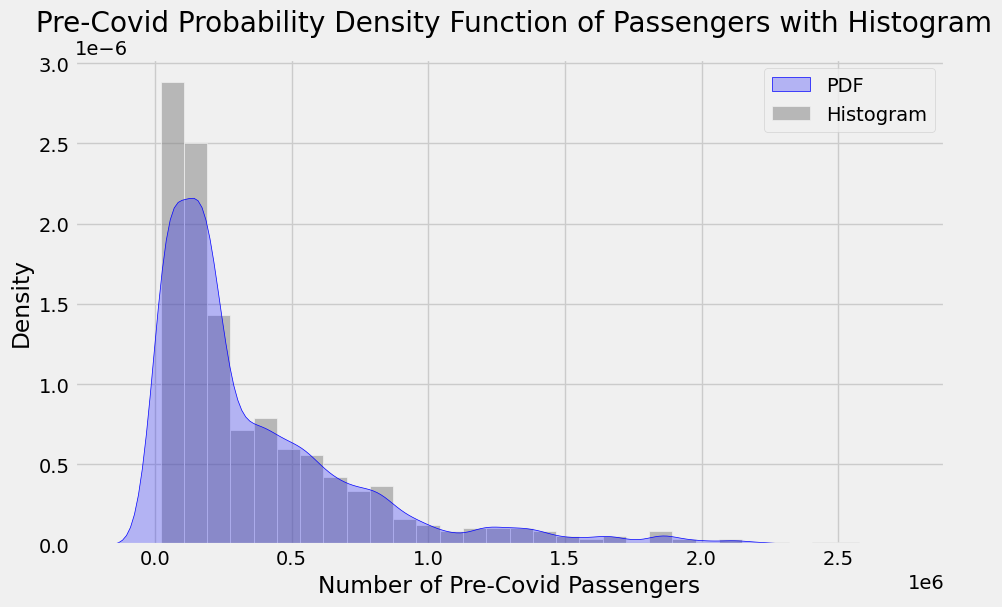

In [50]:
plt.figure(figsize=(10, 6))
sns.histplot(pre_covid['Passengers'], bins=30, kde=False, stat='density', color='gray', alpha=0.5, label='Histogram')

sns.kdeplot(pre_covid['Passengers'], bw_adjust=0.5, color='blue', label='PDF', fill=True)

plt.title(' Pre-Covid Probability Density Function of Passengers with Histogram')
plt.xlabel('Number of Pre-Covid Passengers')
plt.ylabel('Density')
plt.legend()

plt.show()

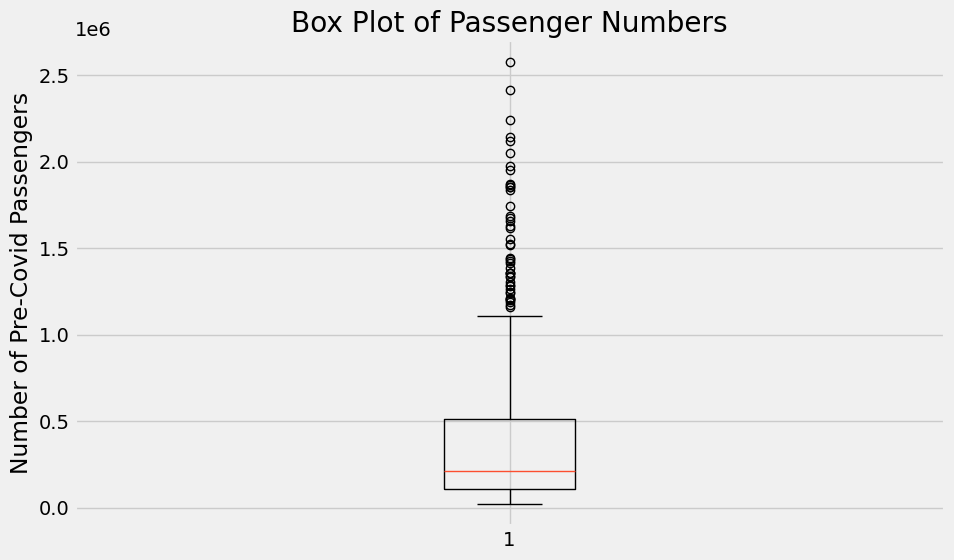

In [51]:
plt.figure(figsize=(10, 6))
plt.boxplot(pre_covid['Passengers'])

plt.title('Box Plot of Passenger Numbers')
plt.ylabel('Number of Pre-Covid Passengers')
plt.grid(True)

plt.show()

In [52]:
pre_covid[['Regions', 'Passengers']].info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 672 entries, 2013-01-01 to 2019-12-01
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Regions     672 non-null    object 
 1   Passengers  672 non-null    float64
dtypes: float64(1), object(1)
memory usage: 15.8+ KB


In [53]:
pre_covid.head()

Regions    Passengers  new_Passengers
Date                                                      
2013-01-01            Europe 563169.000000   563169.000000
2013-01-01         Caribbean 468194.000000   468194.000000
2013-01-01              Asia 372244.000000   372244.000000
2013-01-01     South America 125428.000000   125428.000000
2013-01-01  Central America  200178.000000   200178.000000

In [54]:
pre_covid.describe()

Passengers  new_Passengers
count     672.000000      672.000000
mean   375939.819940   375939.819940
std    416384.154473   416384.154473
min     20343.000000    20343.000000
25%    108816.500000   108816.500000
50%    208612.000000   208612.000000
75%    514200.500000   514200.500000
max   2574573.000000  2574573.000000

In [55]:
new_pre = pre_covid[['Regions', 'Passengers']]
new_pre.head()

Regions    Passengers
Date                                      
2013-01-01            Europe 563169.000000
2013-01-01         Caribbean 468194.000000
2013-01-01              Asia 372244.000000
2013-01-01     South America 125428.000000
2013-01-01  Central America  200178.000000

In [56]:
pre_covid.tail()

Regions    Passengers  new_Passengers
Date                                                      
2019-12-01     South America 279714.000000   279714.000000
2019-12-01  Central America  373412.000000   373412.000000
2019-12-01           Oceania 108902.000000   108902.000000
2019-12-01       Middle East 252460.000000   252460.000000
2019-12-01            Africa  58656.000000    58656.000000

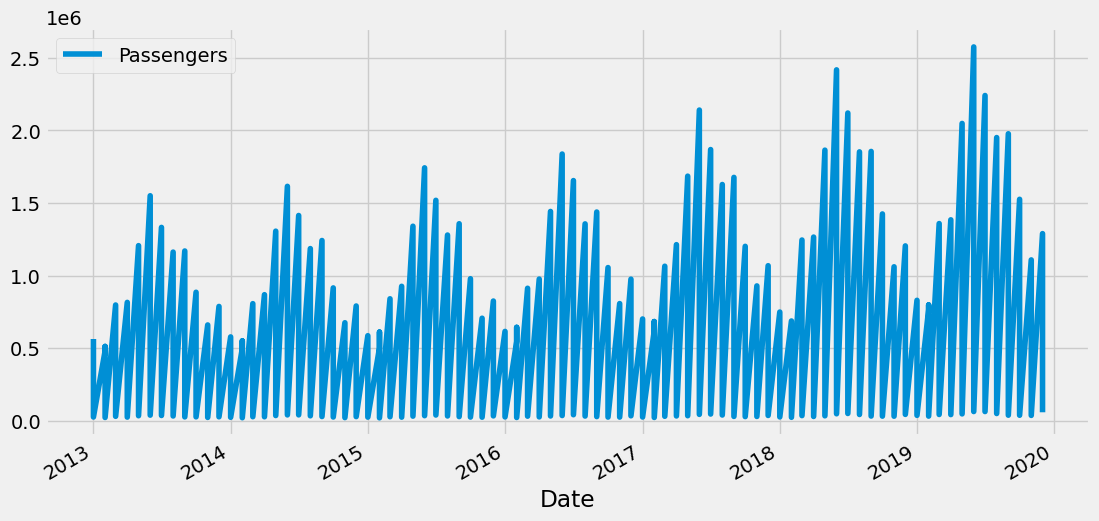

In [57]:
pre_covid.plot(y='Passengers', kind='line', figsize=(12, 6))
plt.show()

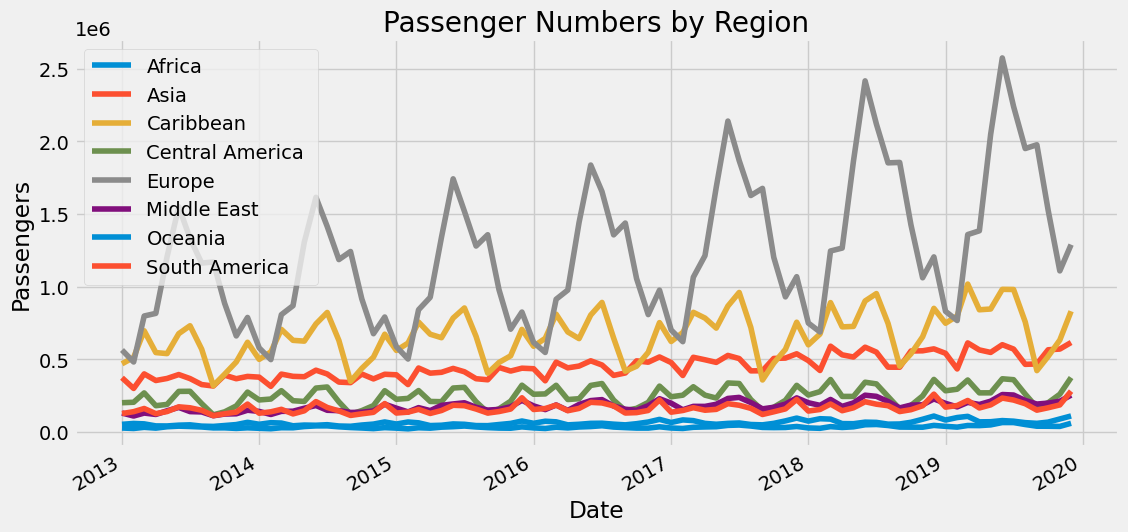

In [58]:
pre_covid_reset = pre_covid.reset_index()

plt.figure(figsize=(12, 6))

for region, group in pre_covid_reset.groupby('Regions'):
    plt.plot(group['Date'], group['Passengers'], label=region)


plt.xlabel('Date')
plt.ylabel('Passengers')
plt.title('Passenger Numbers by Region')
plt.legend()
plt.grid(True)

plt.gcf().autofmt_xdate()

plt.show()


In [59]:
pre_covid_reset.describe()

Date     Passengers  new_Passengers
count                            672     672.000000      672.000000
mean   2016-06-16 01:08:34.285714176  375939.819940   375939.819940
min              2013-01-01 00:00:00   20343.000000    20343.000000
25%              2014-09-23 12:00:00  108816.500000   108816.500000
50%              2016-06-16 00:00:00  208612.000000   208612.000000
75%              2018-03-08 18:00:00  514200.500000   514200.500000
max              2019-12-01 00:00:00 2574573.000000  2574573.000000
std                              NaN  416384.154473   416384.154473

In [60]:

pre_covid_reset = pre_covid.reset_index()
new_pre = pre_covid_reset[['Date', 'Regions', 'Passengers']]
new_pre.head()

Date           Regions    Passengers
0 2013-01-01            Europe 563169.000000
1 2013-01-01         Caribbean 468194.000000
2 2013-01-01              Asia 372244.000000
3 2013-01-01     South America 125428.000000
4 2013-01-01  Central America  200178.000000

### Train/Test Split

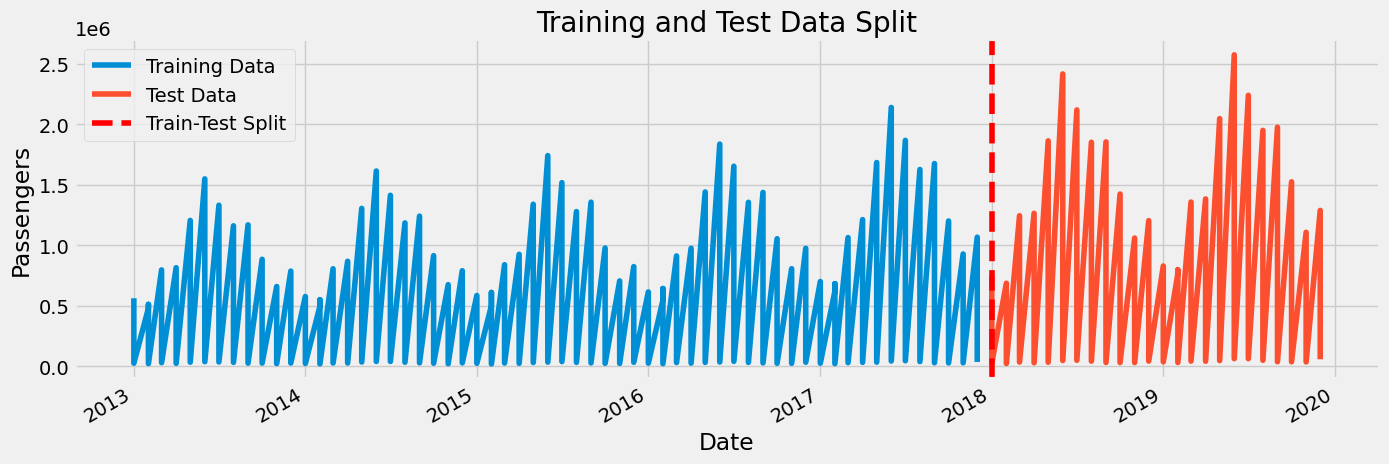

In [61]:

train_data = new_pre[new_pre['Date'] < '2018-01-01']
test_data = new_pre[new_pre['Date'] >= '2018-01-01']

fig, ax = plt.subplots(figsize=(15, 5))

train_data.plot(x='Date', y='Passengers', ax=ax, label='Training Data')
test_data.plot(x='Date', y='Passengers', ax=ax, label='Test Data')

ax.axvline('2018-01-01', color='red', linestyle='--', label='Train-Test Split')

plt.xlabel('Date')
plt.ylabel('Passengers')
plt.title('Training and Test Data Split')
plt.legend()
plt.grid(True)
plt.show()

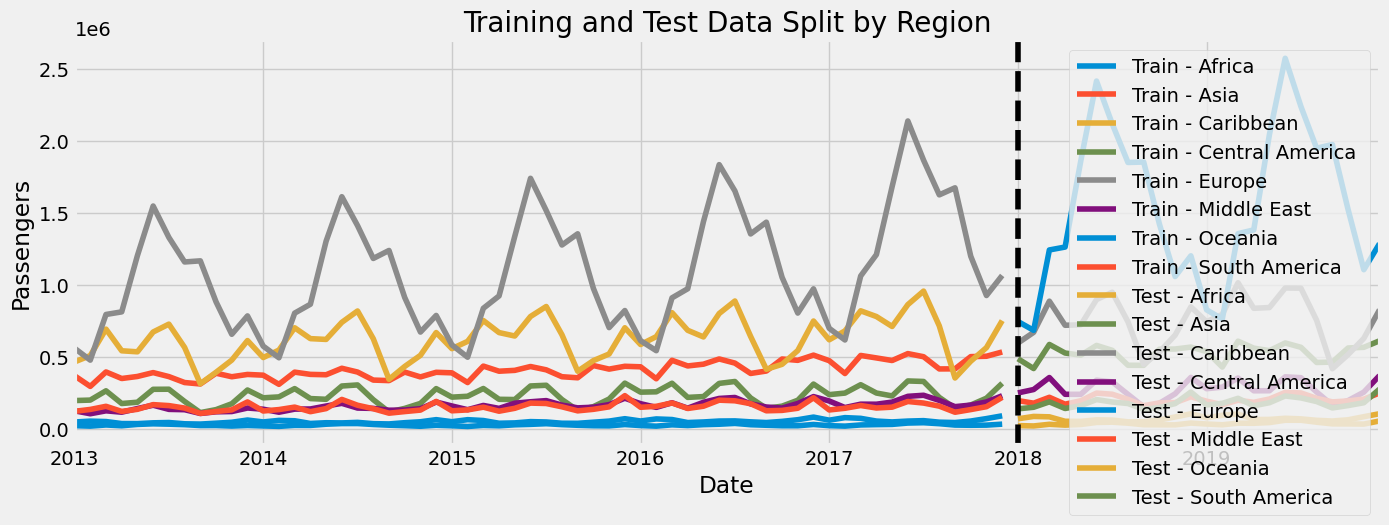

In [62]:
train_data = new_pre[new_pre['Date'] < '2018-01-01']
test_data = new_pre[new_pre['Date'] >= '2018-01-01']

fig, ax = plt.subplots(figsize=(15, 5))

for region, group in train_data.groupby('Regions'):
    group.plot(x='Date', y='Passengers', ax=ax, label=f'Train - {region}')

for region, group in test_data.groupby('Regions'):
    group.plot(x='Date', y='Passengers', ax=ax, label=f'Test - {region}')

ax.axvline('2018-01-01', color='black', ls='--')
plt.xlabel('Date')
plt.ylabel('Passengers')
plt.title('Training and Test Data Split by Region')
plt.legend()
plt.grid(True)
plt.show()

### Feature Creation

In [63]:
def create_features(new_pre):
    """
    Create time series features based on time series index.
    """
    new_pre_copy = new_pre.copy()
    new_pre_copy['dayofweek'] = new_pre_copy.Date.dt.dayofweek
    new_pre_copy['quarter'] = new_pre_copy.Date.dt.quarter
    new_pre_copy['month'] = new_pre_copy.Date.dt.month
    new_pre_copy['year'] = new_pre_copy.Date.dt.year
    new_pre_copy['dayofyear'] = new_pre_copy.Date.dt.dayofyear
    return new_pre_copy


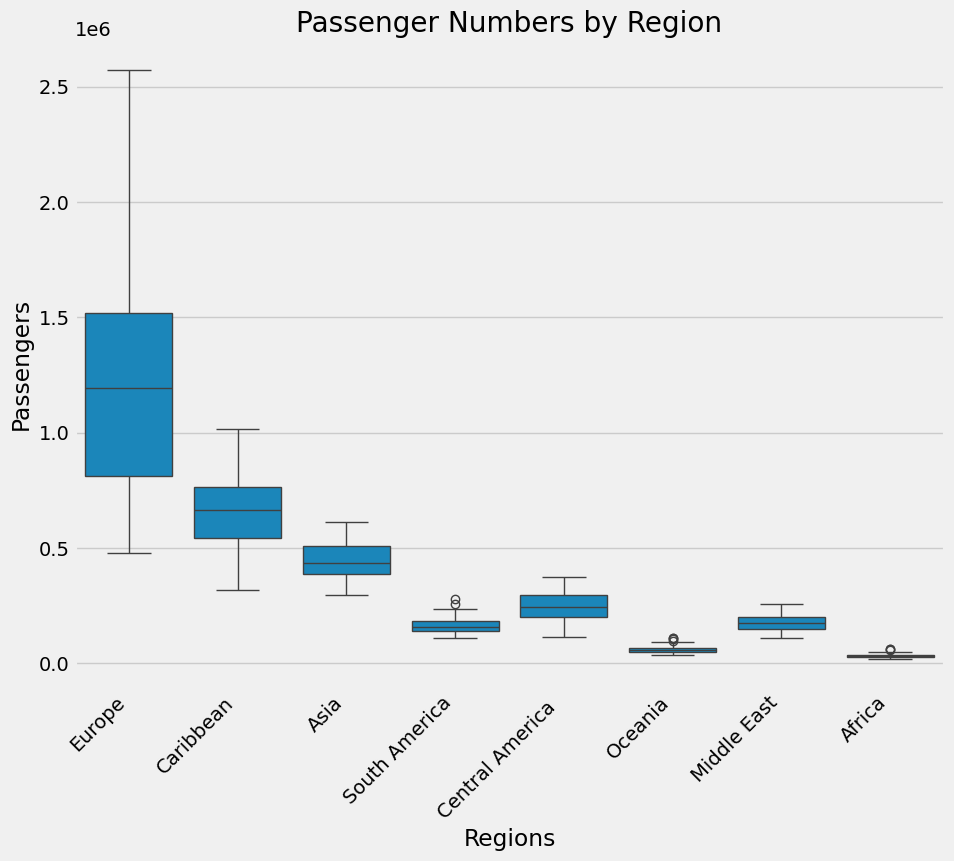

In [64]:
new_pre_copy = create_features(new_pre)
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=new_pre_copy, x='Regions', y='Passengers')
ax.set_title('Passenger Numbers by Region')
plt.xticks(rotation=45, ha='right')
plt.show()

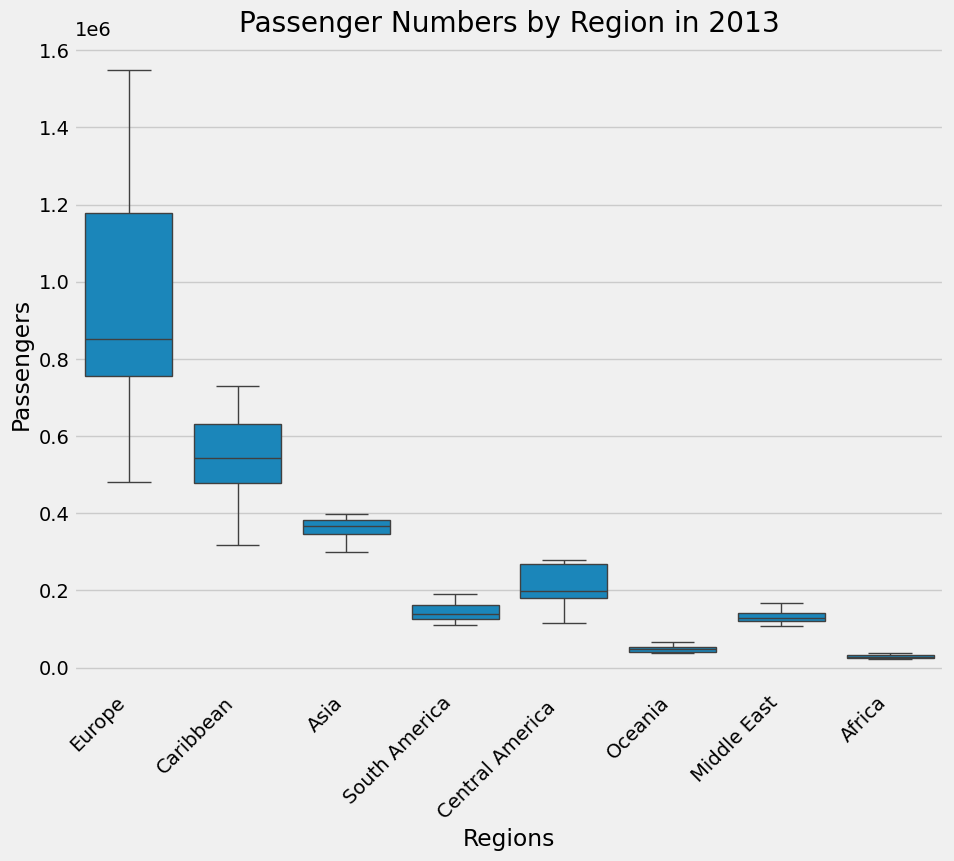

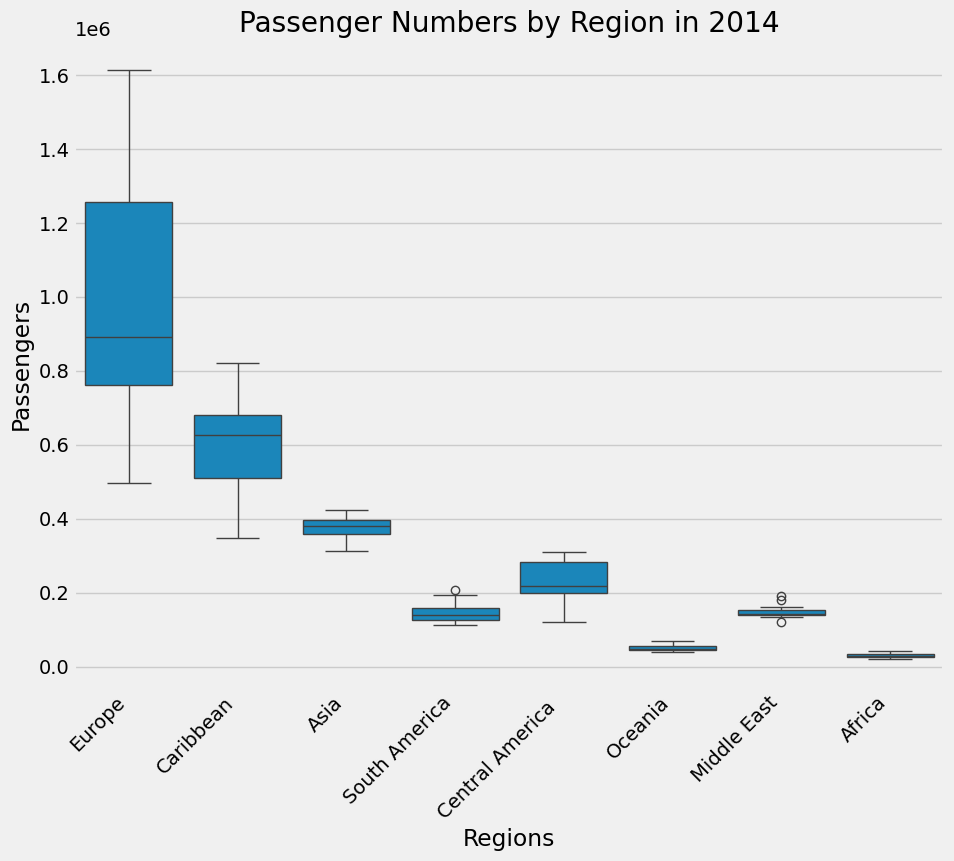

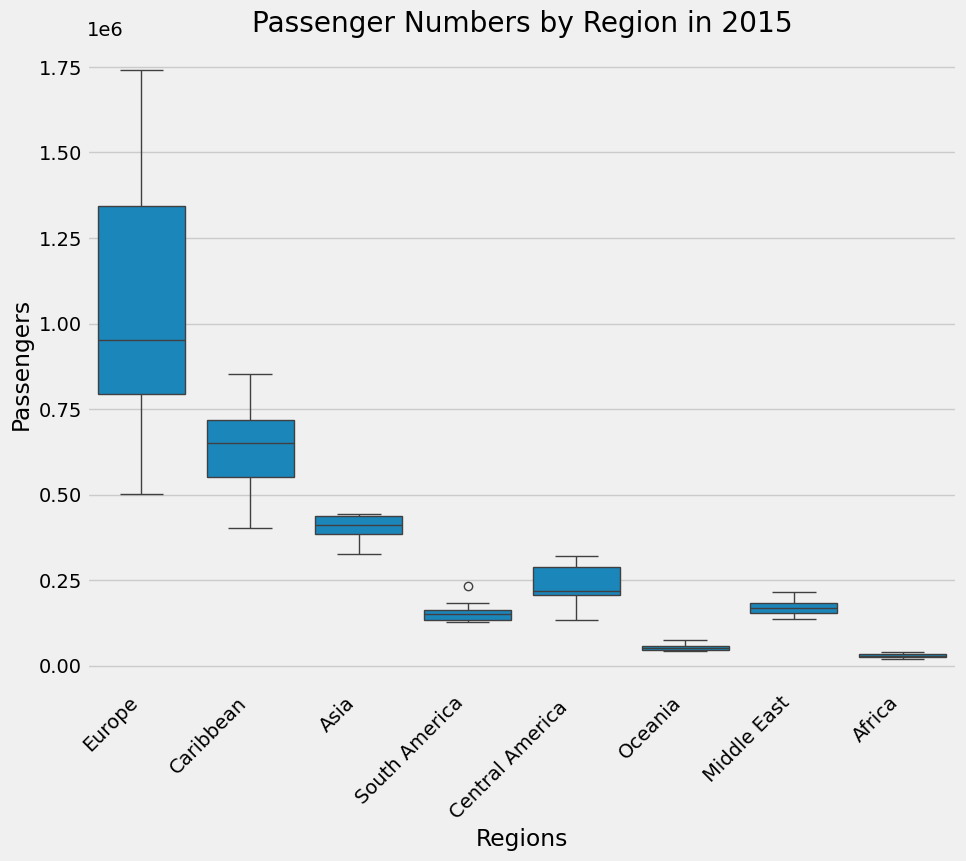

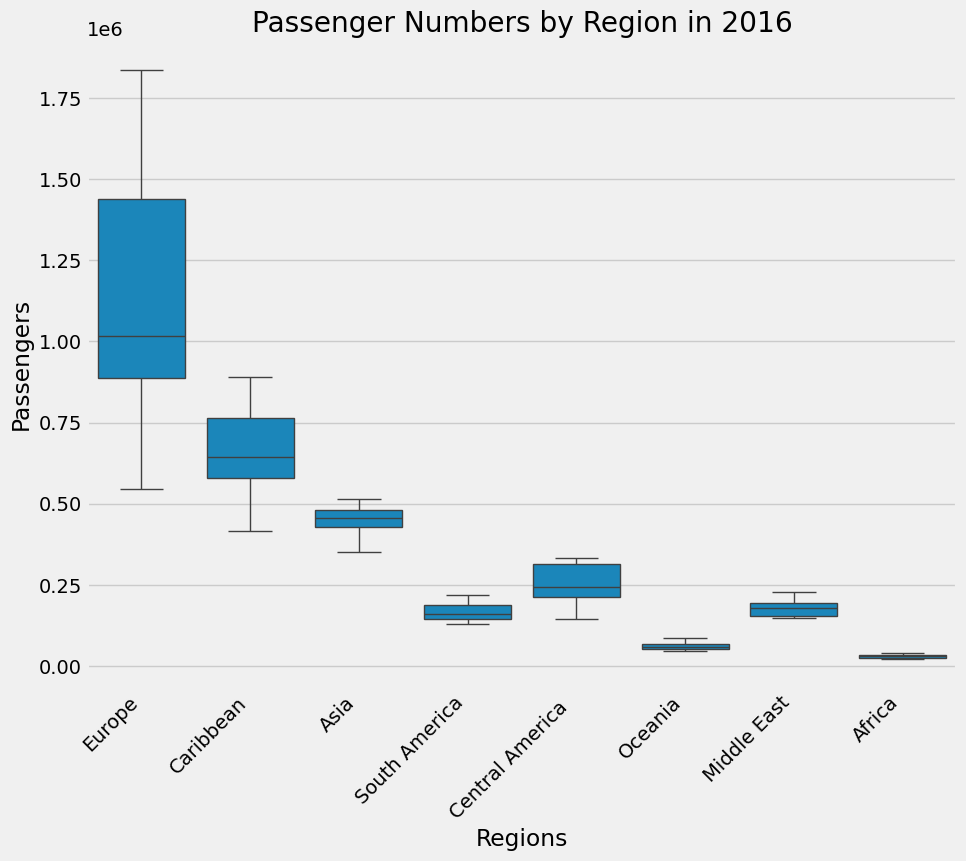

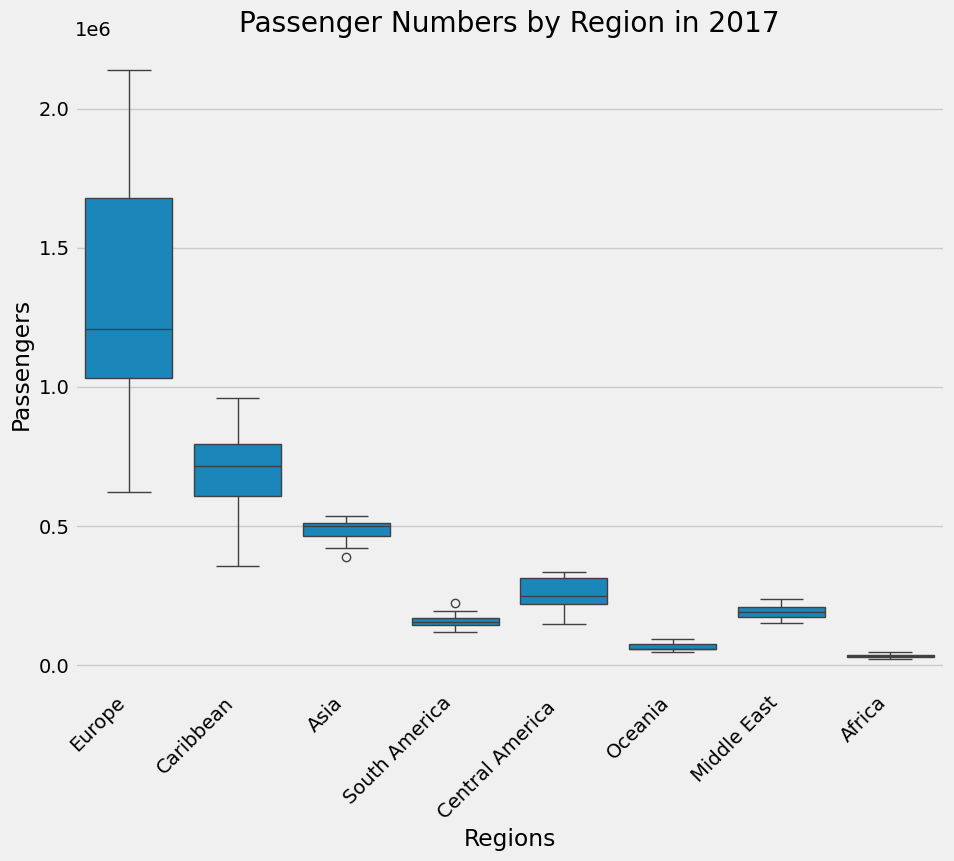

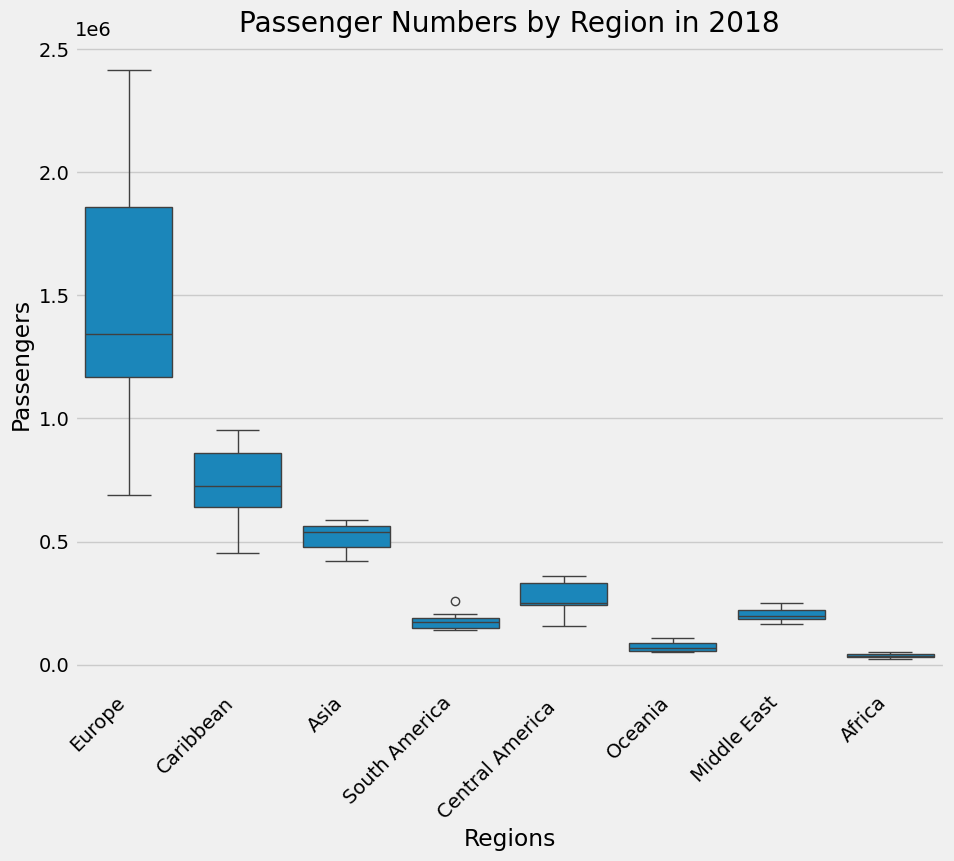

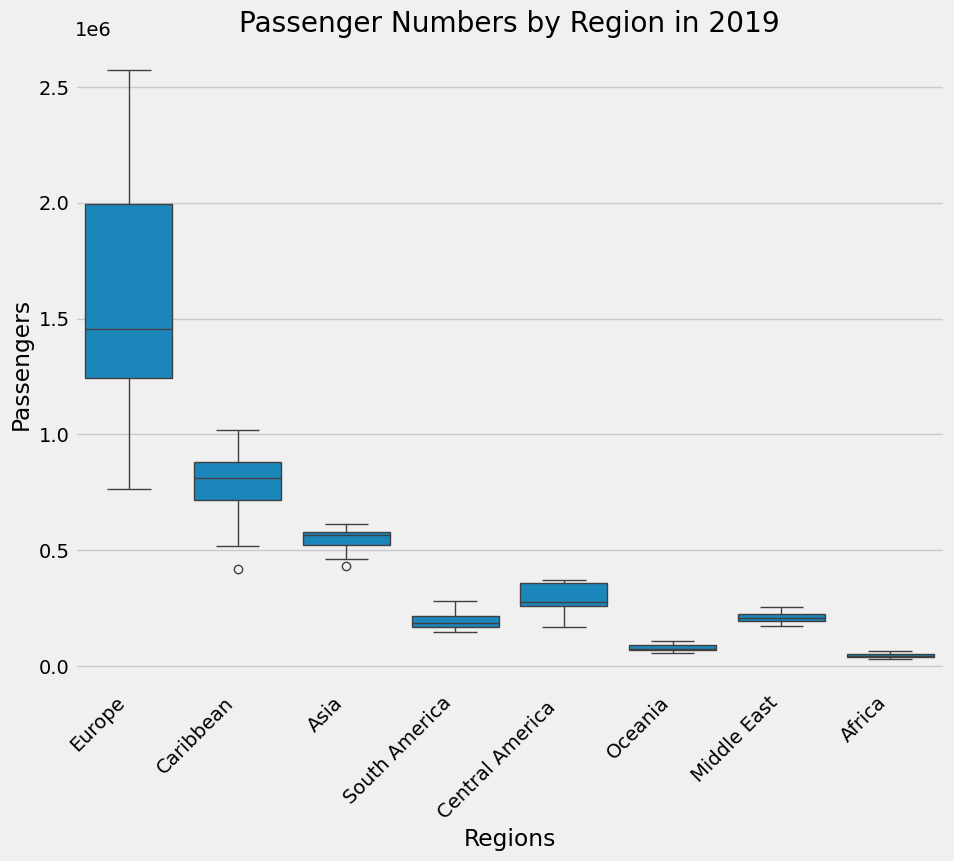

In [65]:
for year in new_pre_copy['year'].unique():
    year_data = new_pre_copy[new_pre_copy['year'] == year]
    fig, ax = plt.subplots(figsize=(10, 8))
    sns.boxplot(data=year_data, x='Regions', y='Passengers')
    ax.set_title(f'Passenger Numbers by Region in {year}')
    plt.xticks(rotation=45, ha='right')
    plt.show()

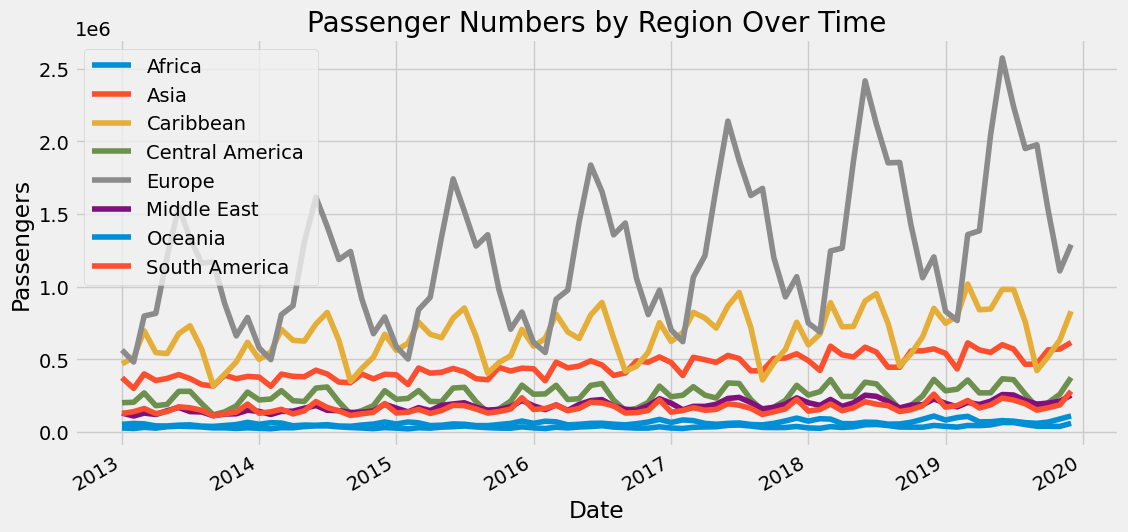

In [66]:
fig, ax = plt.subplots(figsize=(12, 6))
for region, group in new_pre_copy.groupby('Regions'):
    plt.plot(group['Date'], group['Passengers'], label=region)

plt.xlabel('Date')
plt.ylabel('Passengers')
plt.title('Passenger Numbers by Region Over Time')
plt.legend()
plt.grid(True)
plt.gcf().autofmt_xdate()
plt.show()

# Time-series Forecasting Model
- ARIMA
- SARIMA

In [67]:
test_data['Passengers'].shape

(192,)

### Using the ARIMA Model

In [68]:
import numpy as np
from math import sqrt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from statsmodels.tsa.arima.model import ARIMA

history = train_data['Passengers'].tolist()
predictions = list()

for t in range(len(test_data)):
    model = ARIMA(history, order=(1,1,1))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test_data.iloc[t]['Passengers']
    history.append(obs)
    print('predicted=%f, expected=%f' % (yhat, obs))

rmse = sqrt(mean_squared_error(test_data['Passengers'], predictions))
mae = mean_absolute_error(test_data['Passengers'], predictions)
r2 = r2_score(test_data['Passengers'], predictions)


n = len(test_data)
k = 2

# Fit the model on the entire dataset to get the log-likelihood
model = ARIMA(train_data['Passengers'], order=(1,1,1))
model_fit = model.fit()

log_likelihood = model_fit.llf
aic = 2 * k - 2 * log_likelihood
bic = k * np.log(n) - 2 * log_likelihood

print(f'RMSE: {rmse}')
print(f'MAE: {mae}')
print(f'R^2: {r2}')
print(f'AIC: {aic}')
print(f'BIC: {bic}')

predicted=312253.477642, expected=748793.000000
predicted=429277.205226, expected=598896.000000
predicted=407261.320986, expected=490348.000000
predicted=390758.823511, expected=142741.000000
predicted=333305.091593, expected=253091.000000
predicted=350066.720315, expected=73516.000000
predicted=318960.429808, expected=200003.000000
predicted=338077.349518, expected=26621.000000
predicted=307533.044298, expected=687296.000000
predicted=416289.290703, expected=673271.000000
predicted=416421.089324, expected=422237.000000
predicted=376209.963273, expected=153627.000000
predicted=331362.241852, expected=276689.000000
predicted=350611.476429, expected=90014.000000
predicted=318526.417690, expected=181962.000000
predicted=332178.496168, expected=23962.000000
predicted=304141.517221, expected=1244957.000000
predicted=504842.683826, expected=889631.000000
predicted=454456.769676, expected=589421.000000
predicted=407332.729946, expected=191110.000000
predicted=340314.502551, expected=359897.00

Test RMSE: 509181.277
Test MAE: 328948.523
Test R2: -0.007


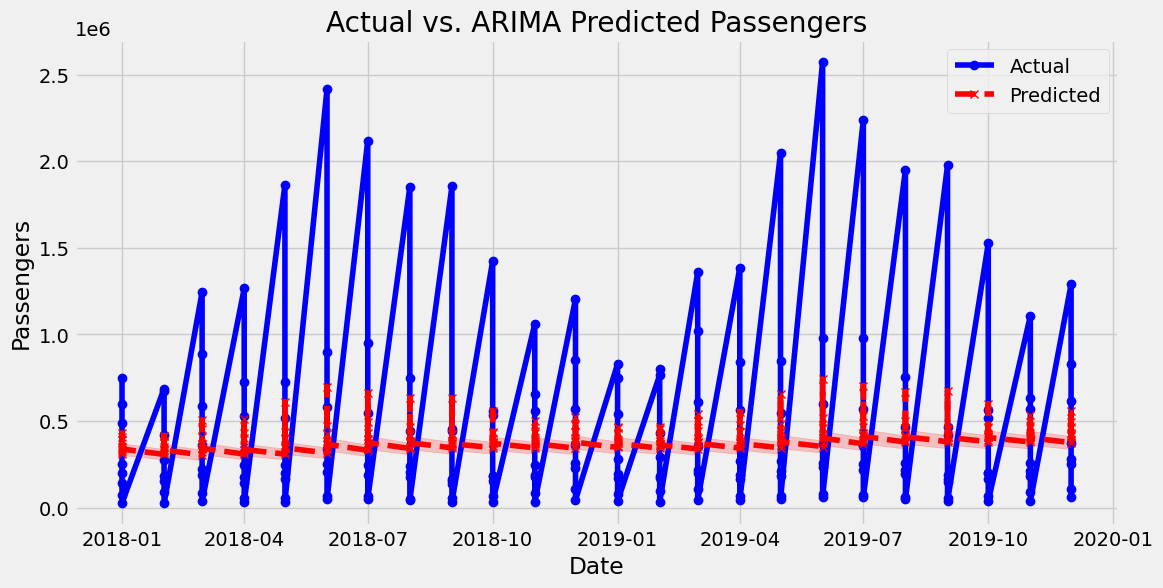

In [69]:
print('Test RMSE: %.3f' % rmse)
print('Test MAE: %.3f' % mae)
print('Test R2: %.3f' % r2)

plt.figure(figsize=(12, 6))
plt.plot(test_data['Date'], test_data['Passengers'], label='Actual', linestyle='-', marker='o', color='blue')
plt.plot(test_data['Date'], predictions, label='Predicted', linestyle='--', marker='x', color='red')
plt.fill_between(test_data['Date'], 0.9 * pd.Series(predictions), 1.1 * pd.Series(predictions), color='red', alpha=0.2)

plt.xlabel('Date')
plt.ylabel('Passengers')
plt.title('Actual vs. ARIMA Predicted Passengers')
plt.legend()
plt.grid(True)

plt.show()

#### With Regions

<ipython-input-70-5c60fe514e2f>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['prediction'] = predictions


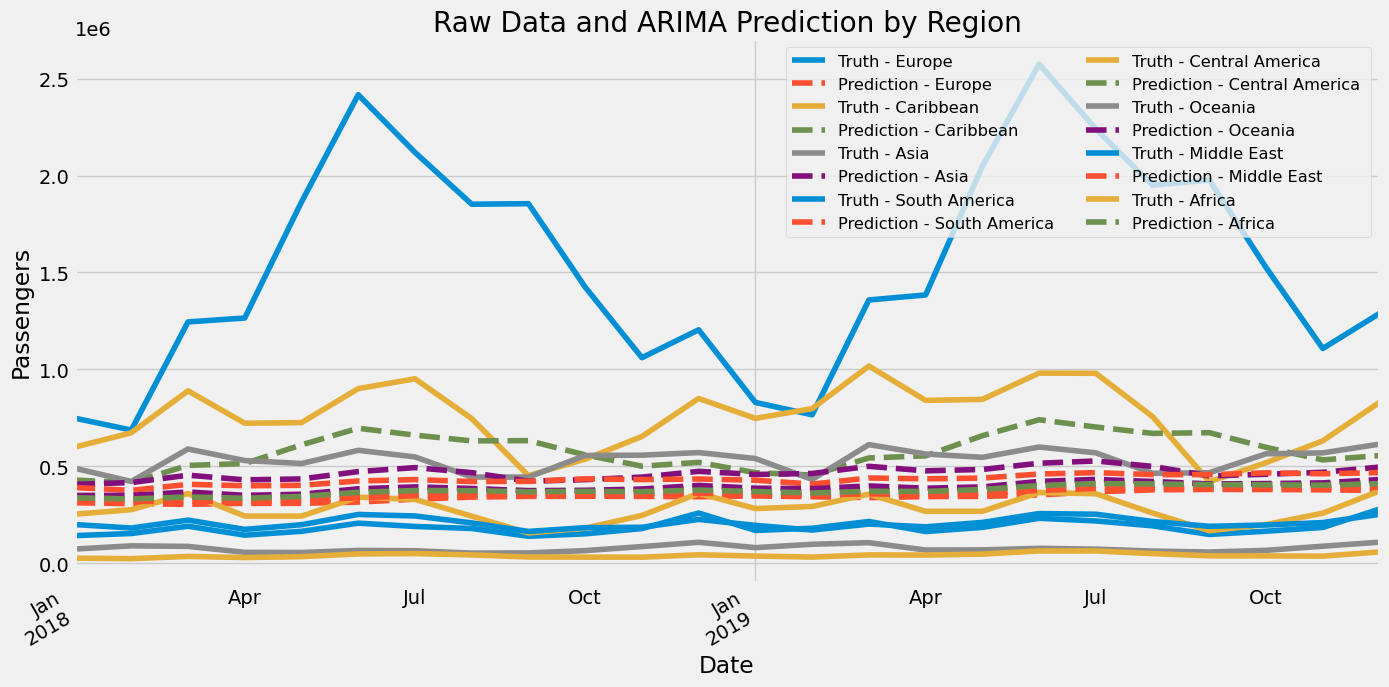

In [70]:
fig, ax = plt.subplots(figsize=(15, 8))

test_data['prediction'] = predictions

for region in test_data['Regions'].unique():
    region_data = test_data[test_data['Regions'] == region]
    region_data.plot(x='Date', y='Passengers', ax=ax, label=f'Truth - {region}')
    region_data.plot(x='Date', y='prediction', ax=ax, style='--', label=f'Prediction - {region}')

plt.legend(loc='upper right', fontsize='small', ncol=2)  # Adjust location, font size, and number of columns

ax.set_title('Raw Data and ARIMA Prediction by Region')
plt.xlabel('Date')
plt.ylabel('Passengers')
plt.grid(True)
plt.gcf().autofmt_xdate()
plt.show()

## Individual ARIMA

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Region: Europe, Mean: 1532984.416667, RMSE: 343121.596392, NRMSE: 0.223826
Region: Caribbean, Mean: 752918.583333, RMSE: 155508.294969, NRMSE: 0.206541
Region: Asia, Mean: 533275.125000, RMSE: 65061.986070, NRMSE: 0.122005


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Region: South America, Mean: 185103.375000, RMSE: 37131.989817, NRMSE: 0.200601
Region: Central America , Mean: 278672.958333, RMSE: 64585.511683, NRMSE: 0.231761
Region: Oceania, Mean: 75791.000000, RMSE: 15775.947420, NRMSE: 0.208151


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/st

Region: Middle East, Mean: 207847.708333, RMSE: 27617.097177, NRMSE: 0.132872


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


Region: Africa, Mean: 40999.958333, RMSE: 9126.209648, NRMSE: 0.222591
             Region         Model          RMSE    NRMSE           MAE  \
0            Europe  ARIMA(1,1,1) 343121.596392 0.223826 284167.110730   
1         Caribbean  ARIMA(1,1,1) 155508.294969 0.206541 131743.702529   
2              Asia  ARIMA(1,1,1)  65061.986070 0.122005  51120.120894   
3     South America  ARIMA(1,1,1)  37131.989817 0.200601  27842.250211   
4  Central America   ARIMA(1,1,1)  64585.511683 0.231761  54121.273468   
5           Oceania  ARIMA(1,1,1)  15775.947420 0.208151  13029.457471   
6       Middle East  ARIMA(1,1,1)  27617.097177 0.132872  23450.898046   
7            Africa  ARIMA(1,1,1)   9126.209648 0.222591   7322.243194   

        R^2        AIC        BIC           Mean  
0  0.588375 685.886237 689.420399 1532984.416667  
1  0.100546 646.938831 650.472993  752918.583333  
2 -0.272388 605.765437 609.299598  533275.125000  
3 -0.111671 577.529700 581.063862  185103.375000  
4 -0.01

<ipython-input-71-b4313c0193cf>:71: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['prediction'] = all_predictions


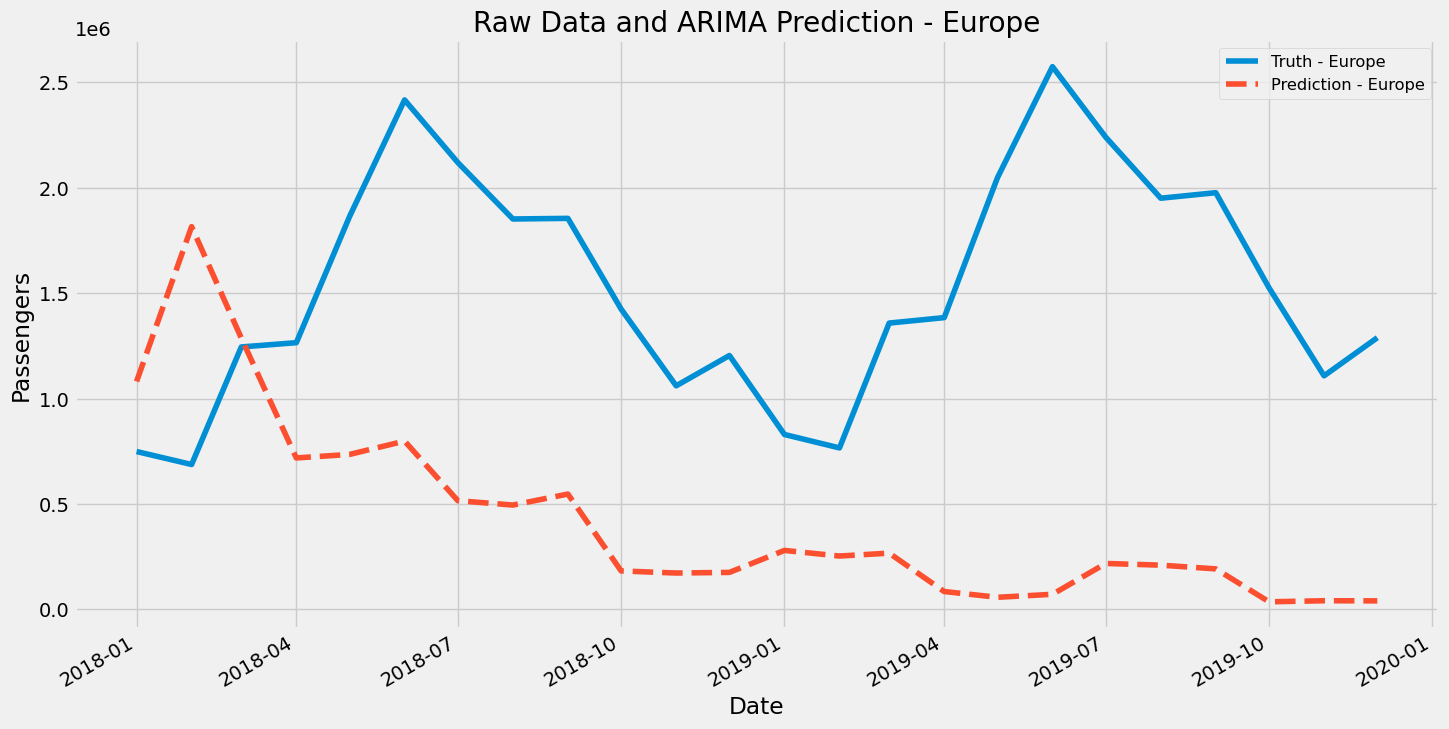

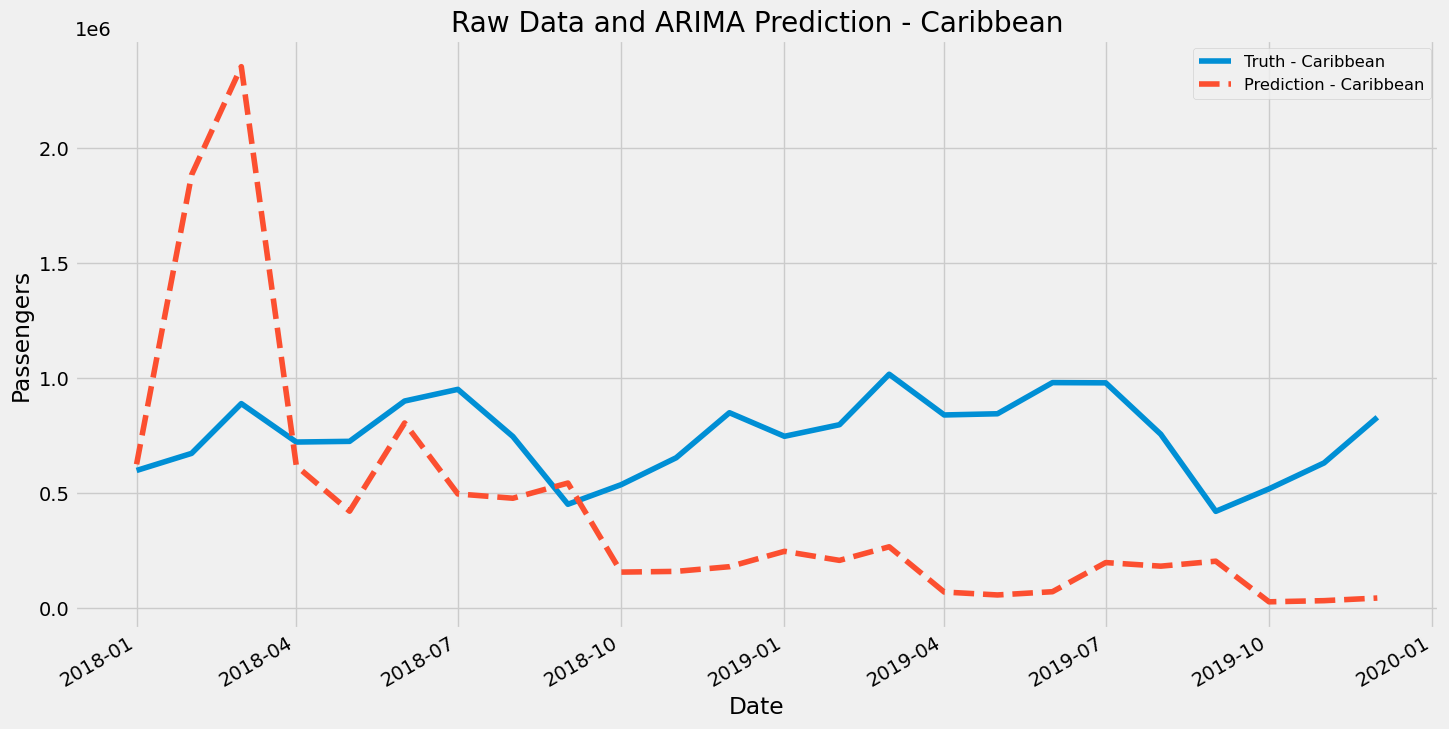

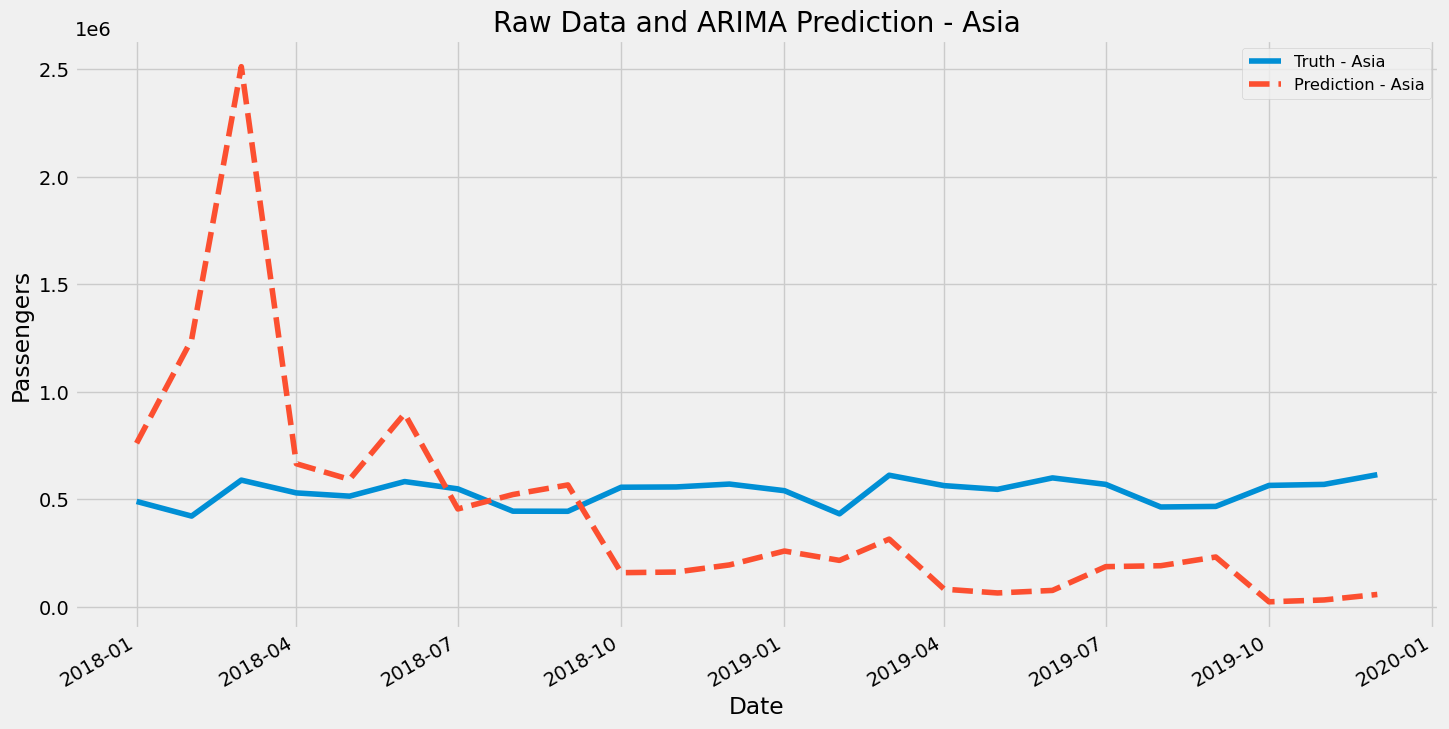

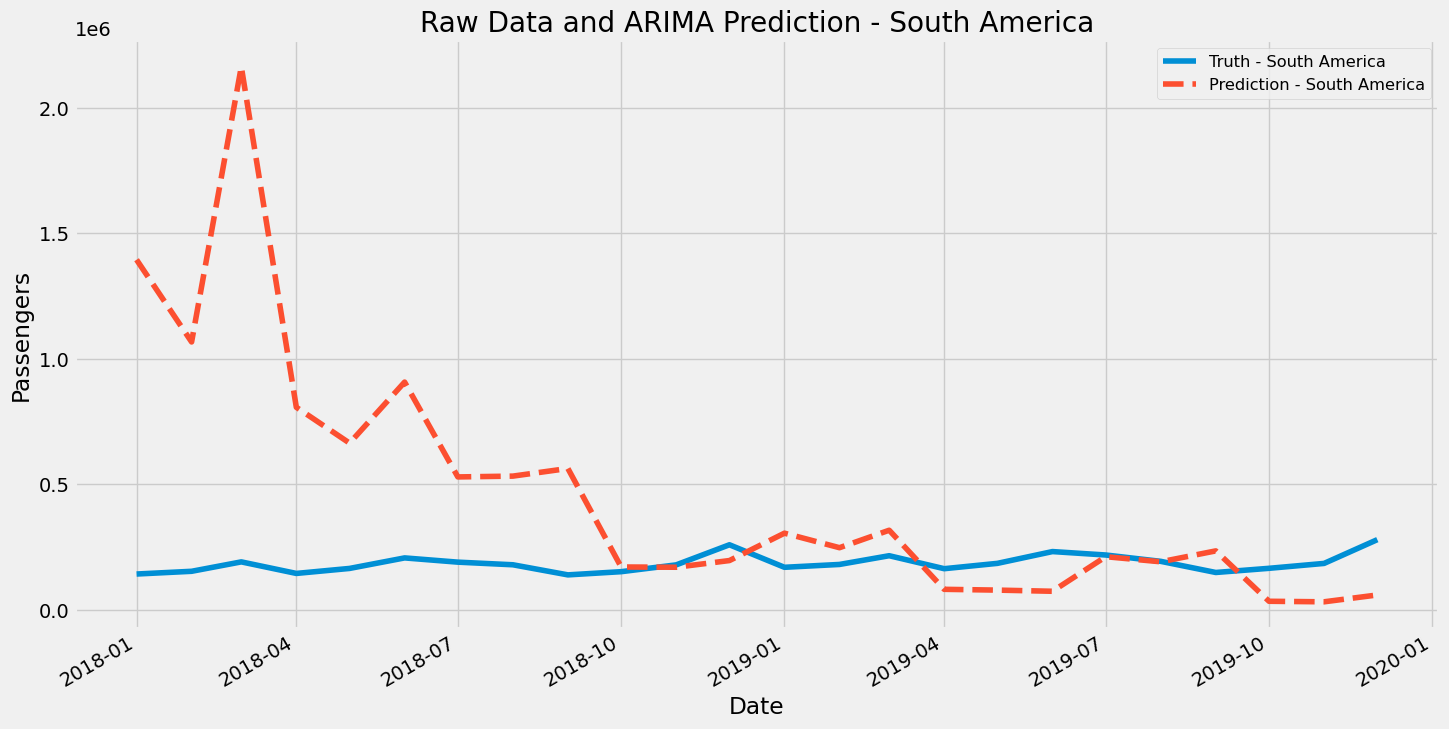

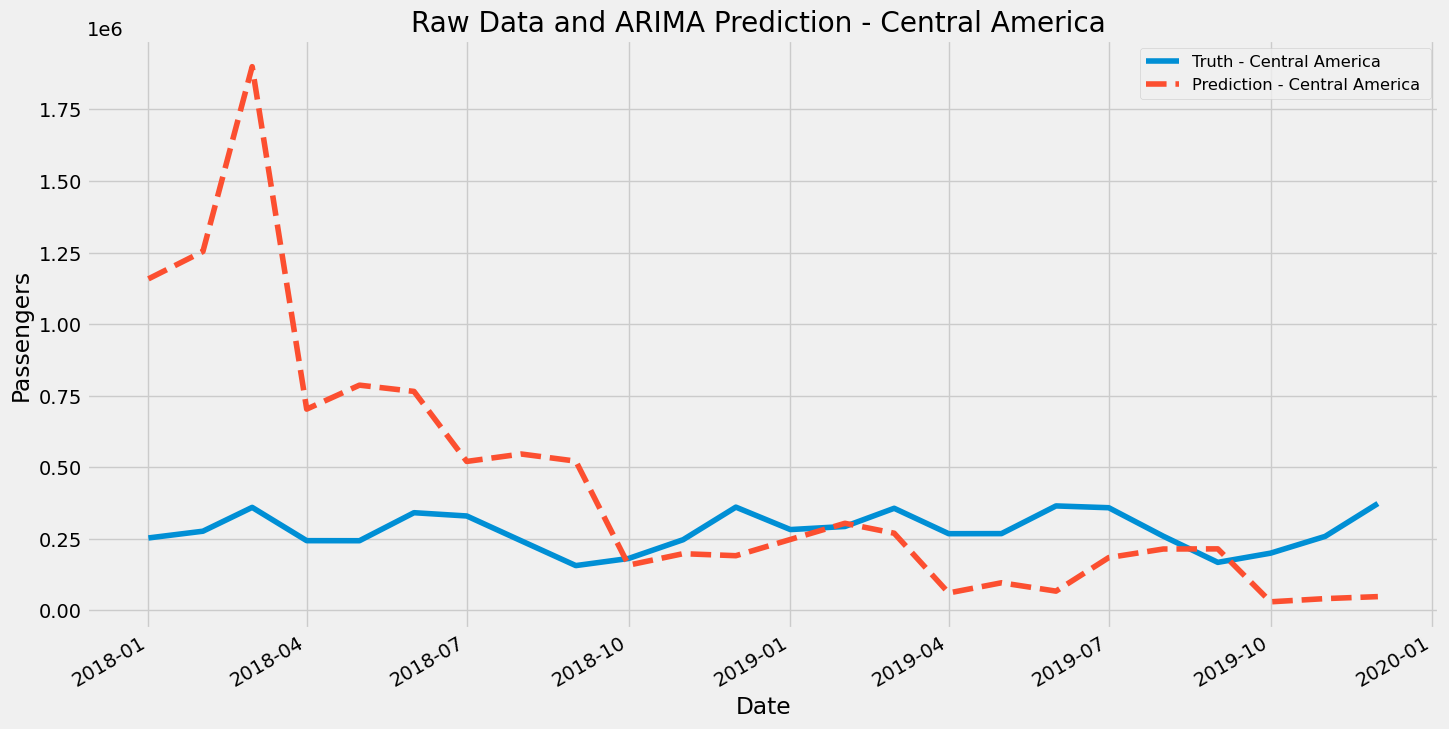

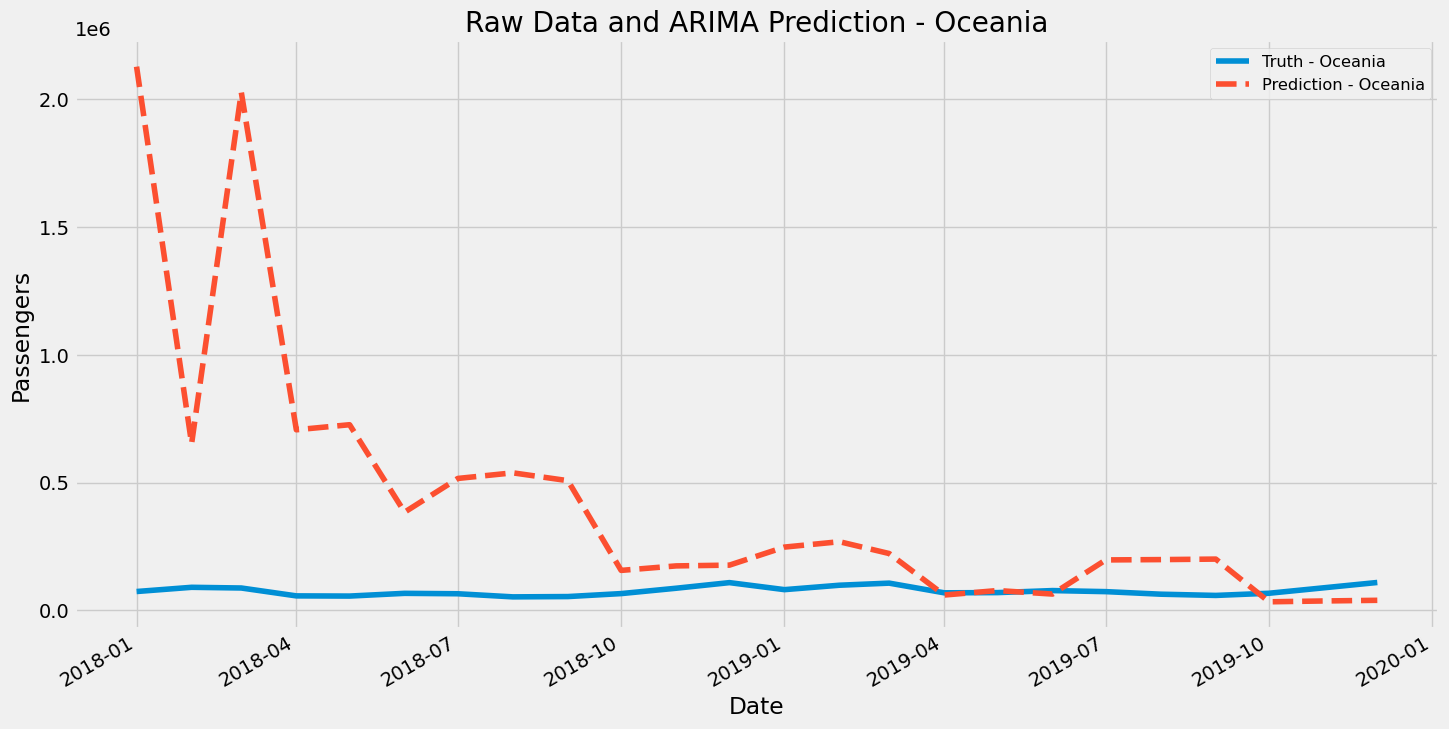

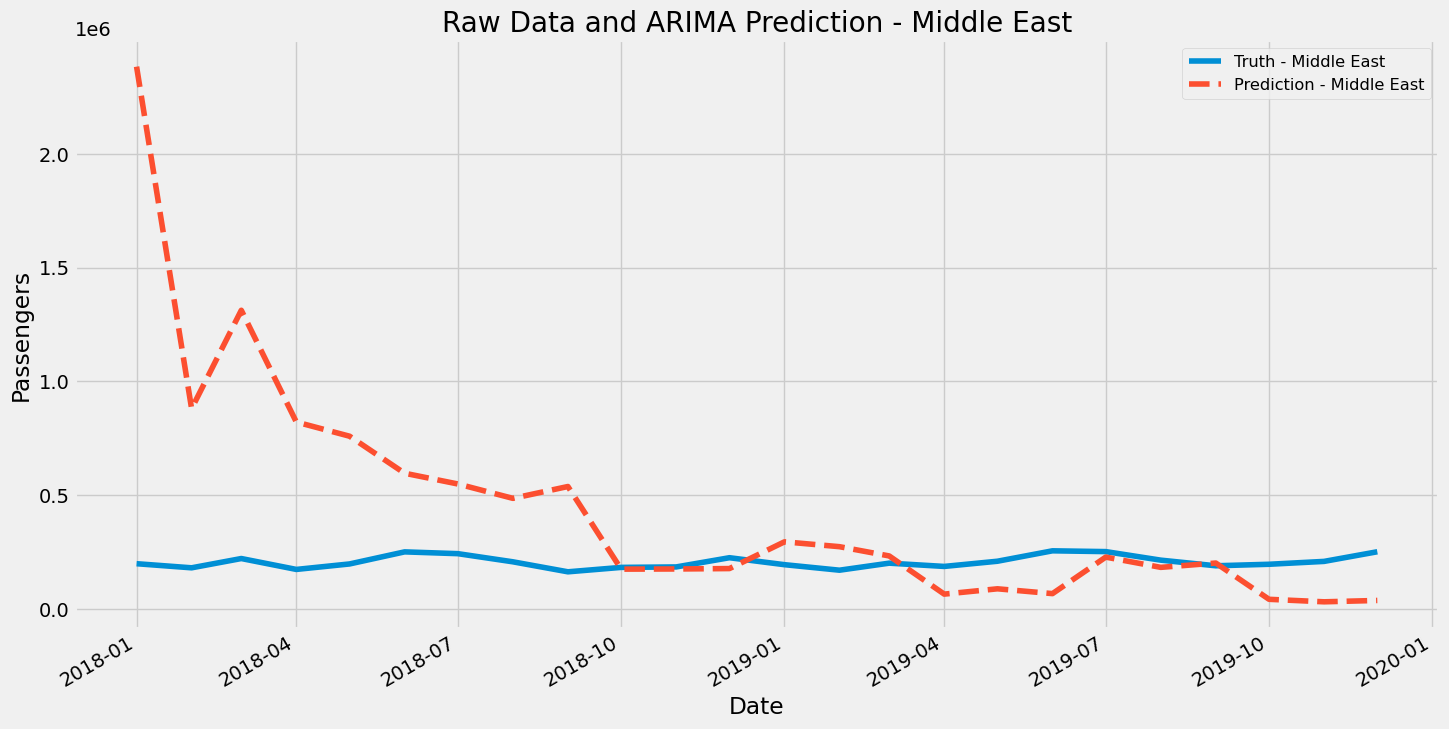

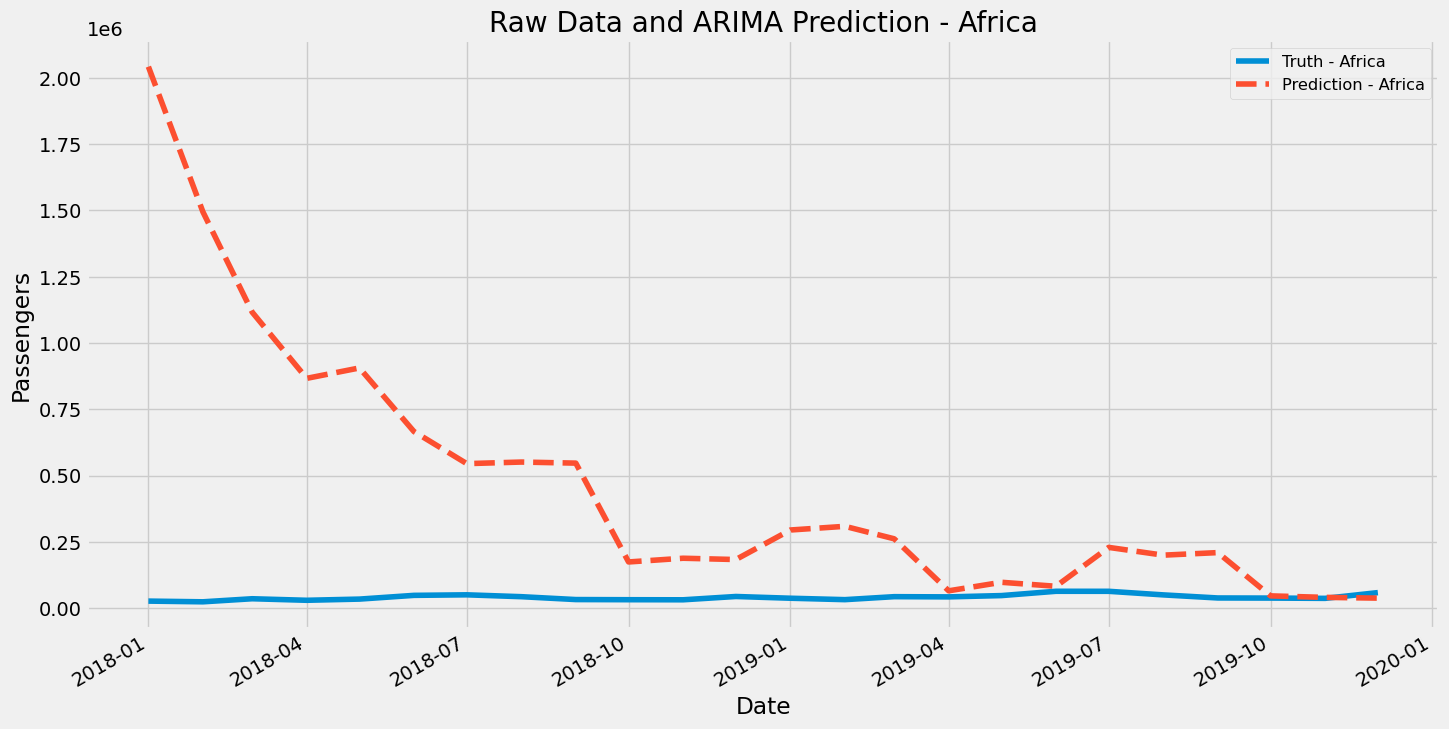

In [71]:
import numpy as np
import pandas as pd
from math import sqrt, log, pi
import matplotlib.pyplot as plt

pd.options.display.float_format = '{:.6f}'.format

regions = test_data['Regions'].unique()

metrics = []
all_predictions = []

for region in regions:
    region_train_data = train_data[train_data['Regions'] == region]
    region_test_data = test_data[test_data['Regions'] == region]

    history = region_train_data['Passengers'].tolist()
    predictions = list()

    for t in range(len(region_test_data)):
        model = ARIMA(history, order=(1,1,1))
        model_fit = model.fit()
        output = model_fit.forecast()
        yhat = output[0]
        predictions.append(yhat)
        obs = region_test_data.iloc[t]['Passengers']
        history.append(obs)

    all_predictions.extend(predictions)

    actual = region_test_data['Passengers'].values
    predicted = np.array(predictions)

    mse = np.mean((actual - predicted) ** 2)
    rmse = sqrt(mse)

    mae = np.mean(np.abs(actual - predicted))

    ss_total = np.sum((actual - np.mean(actual)) ** 2)
    ss_residual = np.sum((actual - predicted) ** 2)
    r2 = 1 - (ss_residual / ss_total)

    n = len(actual)
    k = 3
    residuals = actual - predicted
    sigma2 = np.var(residuals)
    log_likelihood = -n / 2 * (log(2 * pi) + log(sigma2) + 1)
    aic = 2 * k - 2 * log_likelihood
    bic = k * log(n) - 2 * log_likelihood

    mean_val = np.mean(actual)
    nrmse = rmse / mean_val

    print(f"Region: {region}, Mean: {mean_val:.6f}, RMSE: {rmse:.6f}, NRMSE: {nrmse:.6f}")

    metrics.append({
        'Region': region,
        'Model': 'ARIMA(1,1,1)',
        'RMSE': rmse,
        'NRMSE': nrmse,
        'MAE': mae,
        'R^2': r2,
        'AIC': aic,
        'BIC': bic,
        'Mean': mean_val
    })

metrics_df = pd.DataFrame(metrics)
print(metrics_df)

test_data['prediction'] = all_predictions

for region in regions:
    region_data = test_data[test_data['Regions'] == region]

    plt.figure(figsize=(15, 8))
    plt.plot(region_data['Date'], region_data['Passengers'], label=f'Truth - {region}')
    plt.plot(region_data['Date'], region_data['prediction'], linestyle='--', label=f'Prediction - {region}')

    plt.title(f'Raw Data and ARIMA Prediction - {region}')
    plt.xlabel('Date')
    plt.ylabel('Passengers')
    plt.legend(loc='upper right', fontsize='small')
    plt.grid(True)
    plt.xticks(rotation=45)

    plt.tight_layout()
    plt.gcf().autofmt_xdate()
    plt.show()

# Machine Learning Algorithms
- XGBoost
- Random Forest

### Create the Model

In [72]:
train = create_features(train_data)
test = create_features(test_data)


train = pd.get_dummies(train, columns=['Regions'])
test = pd.get_dummies(test, columns=['Regions'])


FEATURES = ['dayofyear', 'dayofweek', 'quarter', 'month', 'year'] + \
           [col for col in train.columns if 'Regions_' in col]

TARGET = 'Passengers'


X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]


### Using the XGBoost

In [73]:
reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',
                       n_estimators=1000,
                       early_stopping_rounds=50,
                       objective='reg:linear',
                       max_depth=3,
                       learning_rate=0.01)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=100)

[0]	validation_0-rmse:501260.90383	validation_1-rmse:674207.90211
[100]	validation_0-rmse:213147.72935	validation_1-rmse:376704.49299


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [18:58:17] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[200]	validation_0-rmse:112930.84981	validation_1-rmse:241828.80790
[300]	validation_0-rmse:78370.03330	validation_1-rmse:185650.43711
[400]	validation_0-rmse:63964.36826	validation_1-rmse:160881.53814
[500]	validation_0-rmse:55614.56480	validation_1-rmse:146493.09532
[600]	validation_0-rmse:48768.89349	validation_1-rmse:136175.39443
[700]	validation_0-rmse:44301.20420	validation_1-rmse:129368.77021
[800]	validation_0-rmse:40759.17040	validation_1-rmse:124295.68603
[900]	validation_0-rmse:37632.40075	validation_1-rmse:120581.59527
[999]	validation_0-rmse:34954.49871	validation_1-rmse:117383.98125


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, objective='reg:linear', ...)

### Feature Importance

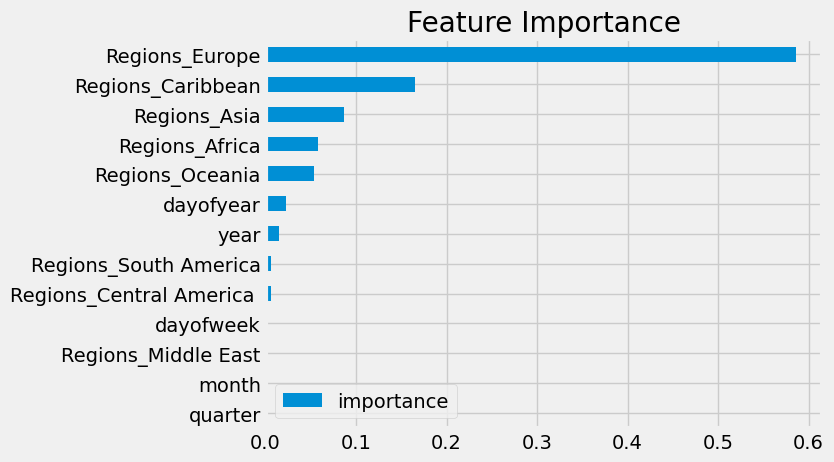

In [74]:
fi = pd.DataFrame(data=reg.feature_importances_,
             index=reg.feature_names_in_,
             columns=['importance'])
fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()

### Different Model Observations in Africa

Running ARIMA model for Africa


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
<ipython-input-76-1bc1f22e4fb8>:102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  region_test_data['prediction_arima'] = predictions_arima
<ipython-input-76-1bc1f22e4fb8>:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using

Running XGBoost model for Africa
[0]	validation_0-rmse:501260.90383	validation_1-rmse:674207.90211
[100]	validation_0-rmse:213147.72935	validation_1-rmse:376704.49299
[200]	validation_0-rmse:112930.84981	validation_1-rmse:241828.80790
[300]	validation_0-rmse:78370.03330	validation_1-rmse:185650.43711
[400]	validation_0-rmse:63964.36826	validation_1-rmse:160881.53814
[500]	validation_0-rmse:55614.56480	validation_1-rmse:146493.09532
[600]	validation_0-rmse:48768.89349	validation_1-rmse:136175.39443
[700]	validation_0-rmse:44301.20420	validation_1-rmse:129368.77021
[800]	validation_0-rmse:40759.17040	validation_1-rmse:124295.68603
[900]	validation_0-rmse:37632.40075	validation_1-rmse:120581.59527
[999]	validation_0-rmse:34954.49871	validation_1-rmse:117383.98125
Running LSTM model for Africa
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


15/15 - 8s - 544ms/step - loss: 0.0427 - val_loss: 0.0628
Epoch 2/200
15/15 - 0s - 10ms/step - loss: 0.0265 - val_loss: 0.0472
Epoch 3/200
15/15 - 0s - 20ms/step - loss: 0.0206 - val_loss: 0.0377
Epoch 4/200
15/15 - 1s - 79ms/step - loss: 0.0137 - val_loss: 0.0260
Epoch 5/200
15/15 - 0s - 13ms/step - loss: 0.0075 - val_loss: 0.0154
Epoch 6/200
15/15 - 0s - 11ms/step - loss: 0.0050 - val_loss: 0.0112
Epoch 7/200
15/15 - 0s - 13ms/step - loss: 0.0049 - val_loss: 0.0107
Epoch 8/200
15/15 - 0s - 11ms/step - loss: 0.0048 - val_loss: 0.0110
Epoch 9/200
15/15 - 0s - 23ms/step - loss: 0.0047 - val_loss: 0.0110
Epoch 10/200
15/15 - 0s - 6ms/step - loss: 0.0047 - val_loss: 0.0108
Epoch 11/200
15/15 - 0s - 6ms/step - loss: 0.0046 - val_loss: 0.0108
Epoch 12/200
15/15 - 0s - 9ms/step - loss: 0.0046 - val_loss: 0.0107
Epoch 13/200
15/15 - 0s - 6ms/step - loss: 0.0046 - val_loss: 0.0107
Epoch 14/200
15/15 - 0s - 9ms/step - loss: 0.0046 - val_loss: 0.0106
Epoch 15/200
15/15 - 0s - 20ms/step - loss: 0

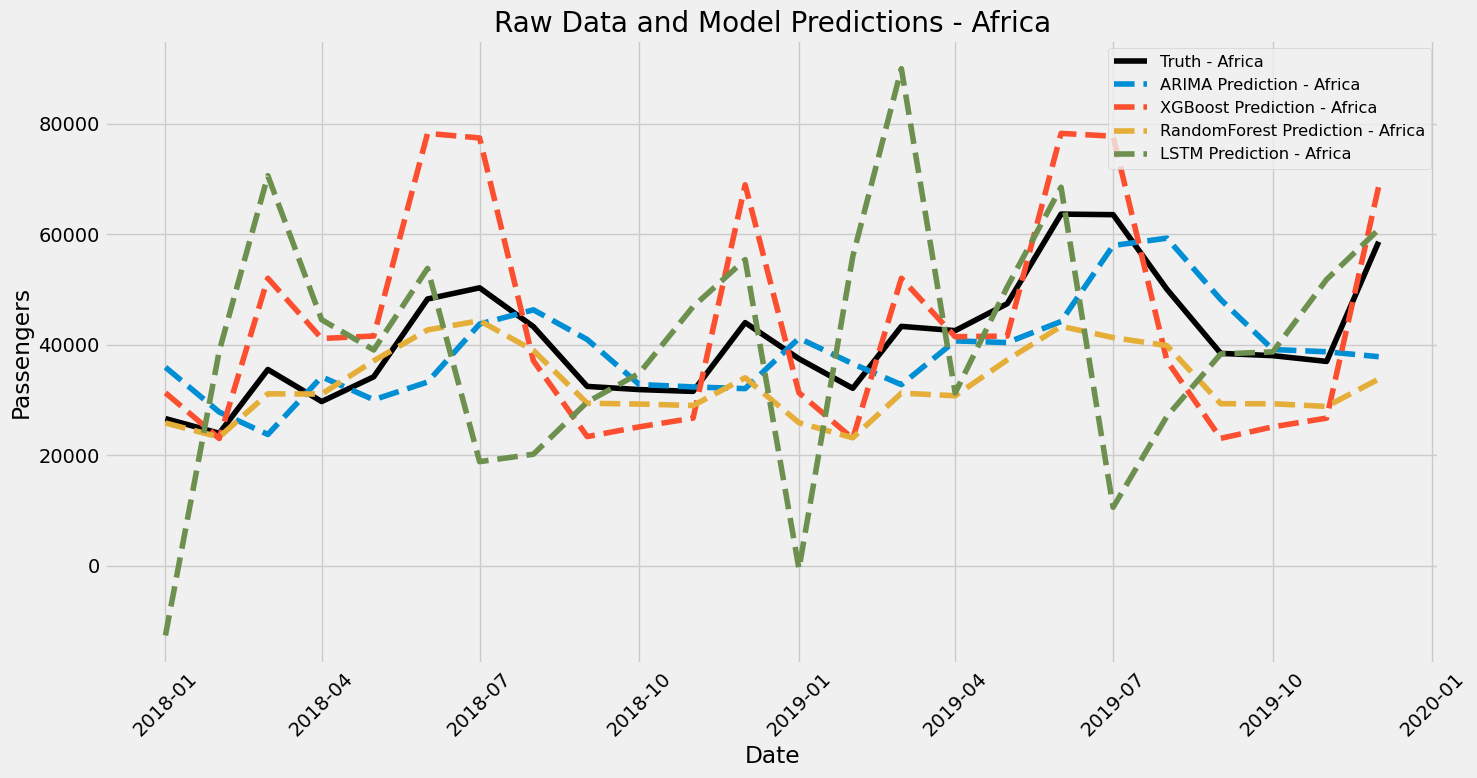

In [76]:
import numpy as np
import pandas as pd
from math import sqrt, log, pi
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
import xgboost as xgb
from tabulate import tabulate
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense


pd.options.display.float_format = '{:.6f}'.format

# Define metric calculation functions
def calculate_rmse(y_true, y_pred):
    mse = np.mean((y_true - y_pred) ** 2)
    return sqrt(mse)

def calculate_r2(y_true, y_pred):
    ss_res = np.sum((y_true - y_pred) ** 2)
    ss_tot = np.sum((y_true - np.mean(y_true)) ** 2)
    return 1 - (ss_res / ss_tot)

def calculate_mae(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred))

def calculate_mean(y_true):
    return np.mean(y_true)

def calculate_aic(y_true, y_pred, num_params):
    resid = y_true - y_pred
    sse = np.sum(resid ** 2)
    aic = 2 * num_params + len(y_true) * log(sse / len(y_true))
    return aic

def calculate_bic(y_true, y_pred, num_params):
    resid = y_true - y_pred
    sse = np.sum(resid ** 2)
    bic = num_params * log(len(y_true)) + len(y_true) * log(sse / len(y_true))
    return bic

def calculate_nrmse(y_true, y_pred):
    rmse = calculate_rmse(y_true, y_pred)
    return rmse / (np.max(y_true) - np.min(y_true))

def calculate_metrics(actual, predicted, k):
    rmse = calculate_rmse(actual, predicted)
    r2 = calculate_r2(actual, predicted)
    mae = calculate_mae(actual, predicted)
    mean_val = calculate_mean(actual)
    aic = calculate_aic(actual, predicted, k)
    bic = calculate_bic(actual, predicted, k)
    nrmse = calculate_nrmse(actual, predicted)
    return rmse, r2, mae, bic, aic, mean_val, nrmse


def create_features(df):
    df['Date'] = pd.to_datetime(df['Date'])
    df['dayofyear'] = df['Date'].dt.dayofyear
    df['dayofweek'] = df['Date'].dt.dayofweek
    df['quarter'] = df['Date'].dt.quarter
    df['month'] = df['Date'].dt.month
    df['year'] = df['Date'].dt.year
    return df

region = 'Africa'
region_train_data = train_data[train_data['Regions'] == region]
region_test_data = test_data[test_data['Regions'] == region]

# ARIMA Model
print(f"Running ARIMA model for {region}")
history = region_train_data['Passengers'].tolist()
predictions_arima = []

for t in range(len(region_test_data)):
    model = ARIMA(history, order=(1,1,1))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    predictions_arima.append(yhat)
    obs = region_test_data.iloc[t]['Passengers']
    history.append(obs)

actual = region_test_data['Passengers'].values
predicted_arima = np.array(predictions_arima)

rmse_arima, r2_arima, mae_arima, bic_arima, aic_arima, mean_val_arima, nrmse_arima = calculate_metrics(actual, predicted_arima, 3)

metrics_arima = {
    'Model': 'ARIMA(1,1,1)',
    'RMSE': rmse_arima,
    'NRMSE': nrmse_arima,
    'MAE': mae_arima,
    'R^2': r2_arima,
    'AIC': aic_arima,
    'BIC': bic_arima,
    'Mean': mean_val_arima
}

region_test_data['prediction_arima'] = predictions_arima

# XGBoost Model
print(f"Running XGBoost model for {region}")
train = create_features(train_data)
test = create_features(test_data)

train = pd.get_dummies(train, columns=['Regions'])
test = pd.get_dummies(test, columns=['Regions'])

FEATURES = ['dayofyear', 'dayofweek', 'quarter', 'month', 'year'] + \
           [col for col in train.columns if 'Regions_' in col]
TARGET = 'Passengers'

X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',
                       n_estimators=1000,
                       early_stopping_rounds=50,
                       objective='reg:linear',
                       max_depth=3,
                       learning_rate=0.01)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=100)

test['prediction_xgb'] = reg.predict(X_test)

region_column = 'Regions_Africa'
region_data = test[test[region_column] == 1]

actual = region_data['Passengers'].values
predicted_xgb = region_data['prediction_xgb'].values
k_xgb = len(FEATURES)

rmse_xgb, r2_xgb, mae_xgb, bic_xgb, aic_xgb, mean_actual_xgb, nrmse_xgb = calculate_metrics(actual, predicted_xgb, k_xgb)

metrics_xgb = {
    'Model': 'XGBoost',
    'RMSE': rmse_xgb,
    'NRMSE': nrmse_xgb,
    'MAE': mae_xgb,
    'R^2': r2_xgb,
    'AIC': aic_xgb,
    'BIC': bic_xgb,
    'Mean': mean_actual_xgb
}

# Random Forest Model
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

test['prediction_rf'] = y_pred_rf

region_data_rf = test[test[region_column] == 1]

actual_rf = region_data_rf['Passengers'].values
predicted_rf = region_data_rf['prediction_rf'].values
k_rf = rf.n_estimators

rmse_rf, r2_rf, mae_rf, bic_rf, aic_rf, mean_actual_rf, nrmse_rf = calculate_metrics(actual_rf, predicted_rf, k_rf)

metrics_rf = {
    'Model': 'RandomForest',
    'RMSE': rmse_rf,
    'NRMSE': nrmse_rf,
    'MAE': mae_rf,
    'R^2': r2_rf,
    'AIC': aic_rf,
    'BIC': bic_rf,
    'Mean': mean_actual_rf
}

# LSTM Model
print(f"Running LSTM model for {region}")

feature_scaler = MinMaxScaler(feature_range=(0, 1))
target_scaler = MinMaxScaler(feature_range=(0, 1))

X_train_scaled = feature_scaler.fit_transform(X_train)
X_test_scaled = feature_scaler.transform(X_test)

y_train_scaled = target_scaler.fit_transform(y_train.values.reshape(-1, 1))
y_test_scaled = target_scaler.transform(y_test.values.reshape(-1, 1))

X_train_reshaped = np.reshape(X_train_scaled, (X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_test_reshaped = np.reshape(X_test_scaled, (X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

lstm_model = Sequential()
lstm_model.add(LSTM(50, return_sequences=True, input_shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2])))
lstm_model.add(LSTM(50))
lstm_model.add(Dense(1))

lstm_model.compile(loss='mean_squared_error', optimizer='adam')
lstm_model.fit(X_train_reshaped, y_train_scaled, epochs=200, batch_size=32, validation_data=(X_test_reshaped, y_test_scaled), verbose=2, shuffle=False)

y_pred_lstm_scaled = lstm_model.predict(X_test_reshaped)

y_test_inv = target_scaler.inverse_transform(y_test_scaled)
y_pred_lstm_inv = target_scaler.inverse_transform(y_pred_lstm_scaled)

test['prediction_lstm'] = y_pred_lstm_inv
new_pre_copy_new = test.copy()

africa_data = new_pre_copy_new[new_pre_copy_new['Regions_Africa'] == 1]

if not africa_data.empty:
    africa_data = africa_data.dropna(subset=['Passengers', 'prediction_lstm'])

    actual = africa_data['Passengers'].values
    predicted = africa_data['prediction_lstm'].values

    rmse_lstm, r2_lstm, mae_lstm, bic_lstm, aic_lstm, mean_lstm, nrmse_lstm = calculate_metrics(actual, predicted, lstm_model.count_params())

    metrics_lstm = {
        'Model': 'LSTM',
        'RMSE': rmse_lstm,
        'NRMSE': nrmse_lstm,
        'MAE': mae_lstm,
        'R^2': r2_lstm,
        'AIC': aic_lstm,
        'BIC': bic_lstm,
        'Mean': mean_lstm
    }

metrics_df = pd.DataFrame([metrics_arima, metrics_xgb, metrics_rf, metrics_lstm])

print(tabulate(metrics_df, headers="keys", tablefmt="grid"))

# Plot predictions for Africa
plt.figure(figsize=(15, 8))
plt.plot(region_test_data['Date'], region_test_data['Passengers'], label='Truth - Africa', color='black')
plt.plot(region_test_data['Date'], region_test_data['prediction_arima'], linestyle='--', label='ARIMA Prediction - Africa')
plt.plot(region_data['Date'], region_data['prediction_xgb'], linestyle='--', label='XGBoost Prediction - Africa')
plt.plot(region_data_rf['Date'], region_data_rf['prediction_rf'], linestyle='--', label='RandomForest Prediction - Africa')
plt.plot(africa_data['Date'], africa_data['prediction_lstm'], linestyle='--', label='LSTM Prediction - Africa')

plt.title('Raw Data and Model Predictions - Africa')
plt.xlabel('Date')
plt.ylabel('Passengers')
plt.legend(loc='upper right', fontsize='small')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [77]:

metrics_df = metrics_df.round(2)

print(tabulate(metrics_df, headers="keys", tablefmt="grid"))



+----+--------------+----------+---------+----------+-------+----------+-----------+--------+
|    | Model        |     RMSE |   NRMSE |      MAE |   R^2 |      AIC |       BIC |   Mean |
+====+==============+==========+=========+==========+=======+==========+===========+========+
|  0 | ARIMA(1,1,1) |  9126.21 |    0.23 |  7322.24 |  0.26 |   443.71 |    447.24 |  41000 |
+----+--------------+----------+---------+----------+-------+----------+-----------+--------+
|  1 | XGBoost      | 13473.1  |    0.34 | 11302.3  | -0.62 |   482.41 |    497.72 |  41000 |
+----+--------------+----------+---------+----------+-------+----------+-----------+--------+
|  2 | RandomForest | 10607.3  |    0.27 |  8440.06 | -0    |   644.93 |    762.73 |  41000 |
+----+--------------+----------+---------+----------+-------+----------+-----------+--------+
|  3 | LSTM         | 23368.4  |    0.59 | 17642.3  | -3.87 | 66584.8  | 105521    |  41000 |
+----+--------------+----------+---------+----------+-------

### Different Model Observations in Asia

Running ARIMA model for Asia
Running XGBoost model for Asia
[0]	validation_0-rmse:501260.90383	validation_1-rmse:674207.90211
[100]	validation_0-rmse:213147.72935	validation_1-rmse:376704.49299
[200]	validation_0-rmse:112930.84981	validation_1-rmse:241828.80790
[300]	validation_0-rmse:78370.03330	validation_1-rmse:185650.43711


<ipython-input-79-141f71f7210f>:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  region_test_data['prediction_arima'] = predictions_arima
<ipython-input-76-1bc1f22e4fb8>:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Date'] = pd.to_datetime(df['Date'])
<ipython-input-76-1bc1f22e4fb8>:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pa

[400]	validation_0-rmse:63964.36826	validation_1-rmse:160881.53814
[500]	validation_0-rmse:55614.56480	validation_1-rmse:146493.09532
[600]	validation_0-rmse:48768.89349	validation_1-rmse:136175.39443
[700]	validation_0-rmse:44301.20420	validation_1-rmse:129368.77021
[800]	validation_0-rmse:40759.17040	validation_1-rmse:124295.68603
[900]	validation_0-rmse:37632.40075	validation_1-rmse:120581.59527
[999]	validation_0-rmse:34954.49871	validation_1-rmse:117383.98125
Running LSTM model for Asia
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


15/15 - 6s - 376ms/step - loss: 0.0419 - val_loss: 0.0638
Epoch 2/200
15/15 - 1s - 78ms/step - loss: 0.0257 - val_loss: 0.0455
Epoch 3/200
15/15 - 0s - 25ms/step - loss: 0.0196 - val_loss: 0.0357
Epoch 4/200
15/15 - 1s - 44ms/step - loss: 0.0125 - val_loss: 0.0245
Epoch 5/200
15/15 - 0s - 8ms/step - loss: 0.0068 - val_loss: 0.0145
Epoch 6/200
15/15 - 0s - 7ms/step - loss: 0.0051 - val_loss: 0.0112
Epoch 7/200
15/15 - 0s - 23ms/step - loss: 0.0050 - val_loss: 0.0110
Epoch 8/200
15/15 - 1s - 43ms/step - loss: 0.0049 - val_loss: 0.0112
Epoch 9/200
15/15 - 0s - 11ms/step - loss: 0.0048 - val_loss: 0.0112
Epoch 10/200
15/15 - 0s - 9ms/step - loss: 0.0048 - val_loss: 0.0111
Epoch 11/200
15/15 - 0s - 9ms/step - loss: 0.0048 - val_loss: 0.0110
Epoch 12/200
15/15 - 0s - 9ms/step - loss: 0.0048 - val_loss: 0.0110
Epoch 13/200
15/15 - 0s - 10ms/step - loss: 0.0047 - val_loss: 0.0110
Epoch 14/200
15/15 - 0s - 10ms/step - loss: 0.0047 - val_loss: 0.0109
Epoch 15/200
15/15 - 0s - 13ms/step - loss: 0

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


15/15 - 4s - 251ms/step - loss: 0.0253 - val_loss: 0.0352
Epoch 2/200
15/15 - 0s - 13ms/step - loss: 0.0107 - val_loss: 0.0194
Epoch 3/200
15/15 - 0s - 9ms/step - loss: 0.0054 - val_loss: 0.0123
Epoch 4/200
15/15 - 0s - 9ms/step - loss: 0.0053 - val_loss: 0.0117
Epoch 5/200
15/15 - 0s - 10ms/step - loss: 0.0052 - val_loss: 0.0126
Epoch 6/200
15/15 - 0s - 12ms/step - loss: 0.0049 - val_loss: 0.0127
Epoch 7/200
15/15 - 0s - 12ms/step - loss: 0.0049 - val_loss: 0.0125
Epoch 8/200
15/15 - 0s - 20ms/step - loss: 0.0049 - val_loss: 0.0124
Epoch 9/200
15/15 - 0s - 13ms/step - loss: 0.0049 - val_loss: 0.0124
Epoch 10/200
15/15 - 0s - 13ms/step - loss: 0.0048 - val_loss: 0.0123
Epoch 11/200
15/15 - 0s - 7ms/step - loss: 0.0048 - val_loss: 0.0121
Epoch 12/200
15/15 - 0s - 9ms/step - loss: 0.0048 - val_loss: 0.0120
Epoch 13/200
15/15 - 0s - 7ms/step - loss: 0.0048 - val_loss: 0.0120
Epoch 14/200
15/15 - 0s - 7ms/step - loss: 0.0048 - val_loss: 0.0120
Epoch 15/200
15/15 - 0s - 8ms/step - loss: 0.0

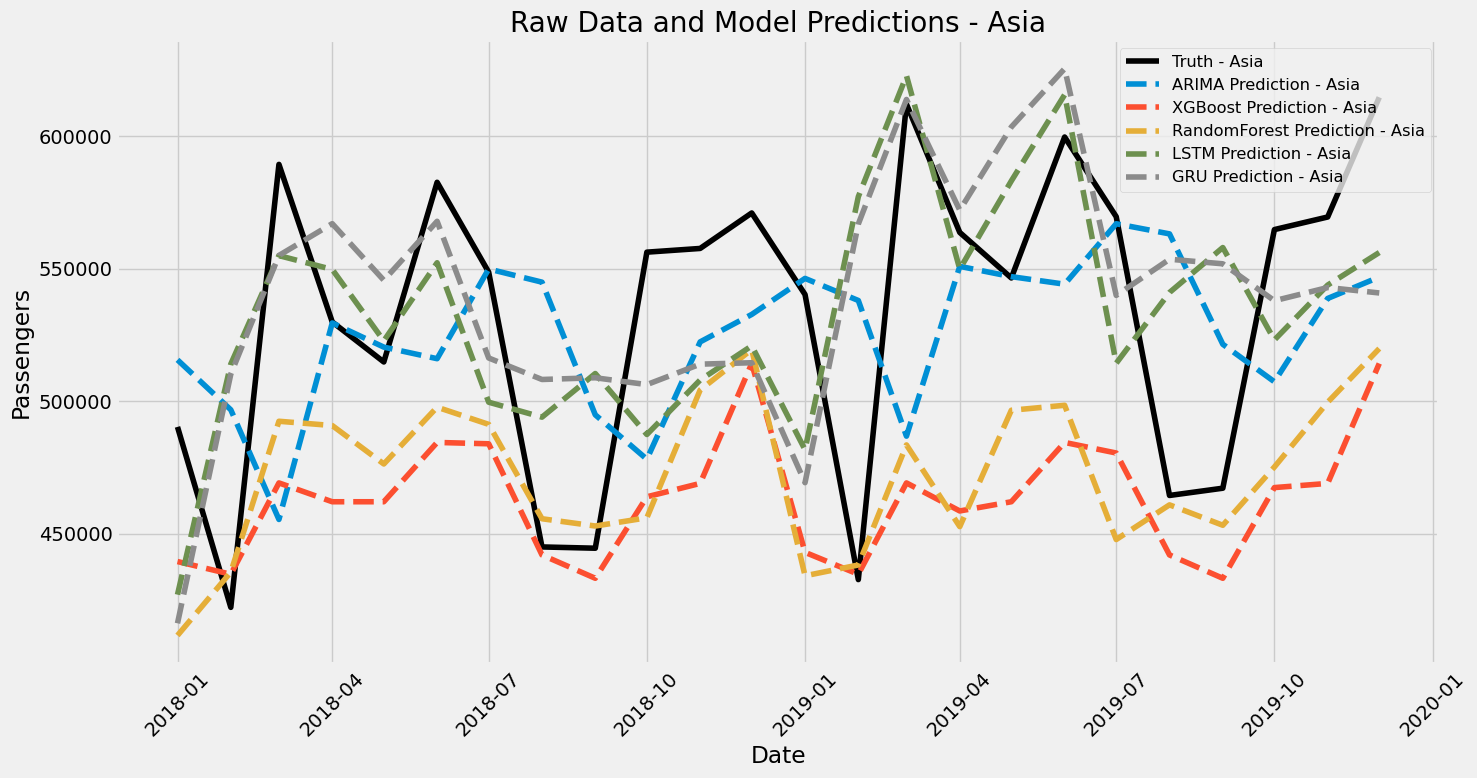

In [79]:
import numpy as np
import pandas as pd
from math import sqrt, log, pi
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
import xgboost as xgb
from tabulate import tabulate
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, GRU, Dense

pd.options.display.float_format = '{:.6f}'.format

def calculate_rmse(y_true, y_pred):
    mse = np.mean((y_true - y_pred) ** 2)
    return sqrt(mse)

def calculate_r2(y_true, y_pred):
    ss_res = np.sum((y_true - y_pred) ** 2)
    ss_tot = np.sum((y_true - np.mean(y_true)) ** 2)
    return 1 - (ss_res / ss_tot)

def calculate_mae(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred))

def calculate_mean(y_true):
    return np.mean(y_true)

def calculate_aic(y_true, y_pred, num_params):
    resid = y_true - y_pred
    sse = np.sum(resid ** 2)
    aic = 2 * num_params + len(y_true) * log(sse / len(y_true))
    return aic

def calculate_bic(y_true, y_pred, num_params):
    resid = y_true - y_pred
    sse = np.sum(resid ** 2)
    bic = num_params * log(len(y_true)) + len(y_true) * log(sse / len(y_true))
    return bic

def calculate_nrmse(y_true, y_pred):
    rmse = calculate_rmse(y_true, y_pred)
    return rmse / (np.max(y_true) - np.min(y_true))

new_pre_copy_new = test_data.copy()

region = 'Asia'
region_train_data = train_data[train_data['Regions'] == region]
region_test_data = test_data[test_data['Regions'] == region]

# ARIMA Model
print(f"Running ARIMA model for {region}")
history = region_train_data['Passengers'].tolist()
predictions_arima = []

for t in range(len(region_test_data)):
    model = ARIMA(history, order=(1,1,1))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    predictions_arima.append(yhat)
    obs = region_test_data.iloc[t]['Passengers']
    history.append(obs)

actual = region_test_data['Passengers'].values
predicted_arima = np.array(predictions_arima)

rmse_arima = calculate_rmse(actual, predicted_arima)
r2_arima = calculate_r2(actual, predicted_arima)
mae_arima = calculate_mae(actual, predicted_arima)
mean_val_arima = calculate_mean(actual)
k_arima = 3  # Number of parameters in ARIMA(1,1,1) including constant term
aic_arima = calculate_aic(actual, predicted_arima, k_arima)
bic_arima = calculate_bic(actual, predicted_arima, k_arima)
nrmse_arima = calculate_nrmse(actual, predicted_arima)

metrics_arima = {
    'Model': 'ARIMA(1,1,1)',
    'RMSE': rmse_arima,
    'NRMSE': nrmse_arima,
    'MAE': mae_arima,
    'R^2': r2_arima,
    'AIC': aic_arima,
    'BIC': bic_arima,
    'Mean': mean_val_arima
}

region_test_data['prediction_arima'] = predictions_arima

# XGBoost Model
print(f"Running XGBoost model for {region}")
train = create_features(train_data)
test = create_features(test_data)

train = pd.get_dummies(train, columns=['Regions'])
test = pd.get_dummies(test, columns=['Regions'])

FEATURES = ['dayofyear', 'dayofweek', 'quarter', 'month', 'year'] + \
           [col for col in train.columns if 'Regions_' in col]
TARGET = 'Passengers'

X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',
                       n_estimators=1000,
                       early_stopping_rounds=50,
                       objective='reg:squarederror',  # Corrected objective
                       max_depth=3,
                       learning_rate=0.01)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=100)

test['prediction_xgb'] = reg.predict(X_test)

region_column = 'Regions_Asia'
region_data = test[test[region_column] == 1]

actual = region_data['Passengers'].values
predicted_xgb = region_data['prediction_xgb'].values
k_xgb = len(FEATURES)

rmse_xgb = calculate_rmse(actual, predicted_xgb)
r2_xgb = calculate_r2(actual, predicted_xgb)
mae_xgb = calculate_mae(actual, predicted_xgb)
aic_xgb = calculate_aic(actual, predicted_xgb, k_xgb)
bic_xgb = calculate_bic(actual, predicted_xgb, k_xgb)
nrmse_xgb = calculate_nrmse(actual, predicted_xgb)

metrics_xgb = {
    'Model': 'XGBoost',
    'RMSE': rmse_xgb,
    'NRMSE': nrmse_xgb,
    'MAE': mae_xgb,
    'R^2': r2_xgb,
    'AIC': aic_xgb,
    'BIC': bic_xgb,
    'Mean': calculate_mean(actual)
}

# Random Forest Model
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

test['prediction_rf'] = y_pred_rf

region_data_rf = test[test[region_column] == 1]

actual_rf = region_data_rf['Passengers'].values
predicted_rf = region_data_rf['prediction_rf'].values
k_rf = len(FEATURES)  # Corrected to use the number of features instead of n_estimators

rmse_rf = calculate_rmse(actual_rf, predicted_rf)
r2_rf = calculate_r2(actual_rf, predicted_rf)
mae_rf = calculate_mae(actual_rf, predicted_rf)
aic_rf = calculate_aic(actual_rf, predicted_rf, k_rf)
bic_rf = calculate_bic(actual_rf, predicted_rf, k_rf)
nrmse_rf = calculate_nrmse(actual_rf, predicted_rf)

metrics_rf = {
    'Model': 'RandomForest',
    'RMSE': rmse_rf,
    'NRMSE': nrmse_rf,
    'MAE': mae_rf,
    'R^2': r2_rf,
    'AIC': aic_rf,
    'BIC': bic_rf,
    'Mean': calculate_mean(actual_rf)
}

# LSTM Model
print(f"Running LSTM model for {region}")

feature_scaler = MinMaxScaler(feature_range=(0, 1))
target_scaler = MinMaxScaler(feature_range=(0, 1))

X_train_scaled = feature_scaler.fit_transform(X_train)
X_test_scaled = feature_scaler.transform(X_test)

y_train_scaled = target_scaler.fit_transform(y_train.values.reshape(-1, 1))
y_test_scaled = target_scaler.transform(y_test.values.reshape(-1, 1))

X_train_reshaped = np.reshape(X_train_scaled, (X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_test_reshaped = np.reshape(X_test_scaled, (X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

lstm_model = Sequential()
lstm_model.add(LSTM(50, return_sequences=True, input_shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2])))
lstm_model.add(LSTM(50))
lstm_model.add(Dense(1))

lstm_model.compile(loss='mean_squared_error', optimizer='adam')
lstm_model.fit(X_train_reshaped, y_train_scaled, epochs=200, batch_size=32, validation_data=(X_test_reshaped, y_test_scaled), verbose=2, shuffle=False)

y_pred_lstm_scaled = lstm_model.predict(X_test_reshaped)

y_test_inv = target_scaler.inverse_transform(y_test_scaled)
y_pred_lstm_inv = target_scaler.inverse_transform(y_pred_lstm_scaled)

test['Date'] = test_data['Date']

test['prediction_lstm'] = y_pred_lstm_inv
new_pre_copy_new = new_pre_copy_new.merge(test[['Date', 'prediction_lstm']], how='left', left_index=True, right_index=True)

asia_data = new_pre_copy_new[new_pre_copy_new['Regions'] == 'Asia']

if not asia_data.empty:
    asia_data = asia_data.dropna(subset=['Passengers', 'prediction_lstm'])

    actual = asia_data['Passengers'].values
    predicted = asia_data['prediction_lstm'].values

    rmse_lstm = calculate_rmse(actual, predicted)
    r2_lstm = calculate_r2(actual, predicted)
    mae_lstm = calculate_mae(actual, predicted)
    mean_lstm = calculate_mean(actual)
    num_params_lstm = lstm_model.count_params()  # Number of parameters in the model
    aic_lstm = calculate_aic(actual, predicted, num_params_lstm)
    bic_lstm = calculate_bic(actual, predicted, num_params_lstm)
    nrmse_lstm = calculate_nrmse(actual, predicted)

    metrics_lstm = {
        'Model': 'LSTM',
        'RMSE': rmse_lstm,
        'NRMSE': nrmse_lstm,
        'MAE': mae_lstm,
        'R^2': r2_lstm,
        'AIC': aic_lstm,
        'BIC': bic_lstm,
        'Mean': mean_lstm
    }

# GRU Model
print(f"Running GRU model for {region}")

X_train_scaled = feature_scaler.fit_transform(X_train)
X_test_scaled = feature_scaler.transform(X_test)

y_train_scaled = target_scaler.fit_transform(y_train.values.reshape(-1, 1))
y_test_scaled = target_scaler.transform(y_test.values.reshape(-1, 1))

X_train_reshaped = np.reshape(X_train_scaled, (X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_test_reshaped = np.reshape(X_test_scaled, (X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

gru_model = Sequential()
gru_model.add(GRU(50, return_sequences=True, input_shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2])))
gru_model.add(GRU(50))
gru_model.add(Dense(1))

gru_model.compile(loss='mean_squared_error', optimizer='adam')
gru_model.fit(X_train_reshaped, y_train_scaled, epochs=200, batch_size=32, validation_data=(X_test_reshaped, y_test_scaled), verbose=2, shuffle=False)

y_pred_gru_scaled = gru_model.predict(X_test_reshaped)

y_pred_gru_inv = target_scaler.inverse_transform(y_pred_gru_scaled)

test['prediction_gru'] = y_pred_gru_inv
new_pre_copy_new = new_pre_copy_new.merge(test[['Date', 'prediction_gru']], how='left', left_index=True, right_index=True)

asia_data = new_pre_copy_new[new_pre_copy_new['Regions'] == 'Asia']

if not asia_data.empty:
    asia_data = asia_data.dropna(subset=['Passengers', 'prediction_gru'])

    actual = asia_data['Passengers'].values
    predicted = asia_data['prediction_gru'].values

    rmse_gru = calculate_rmse(actual, predicted)
    r2_gru = calculate_r2(actual, predicted)
    mae_gru = calculate_mae(actual, predicted)
    mean_gru = calculate_mean(actual)
    num_params_gru = gru_model.count_params()  # Number of parameters in the model
    aic_gru = calculate_aic(actual, predicted, num_params_gru)
    bic_gru = calculate_bic(actual, predicted, num_params_gru)
    nrmse_gru = calculate_nrmse(actual, predicted)

    metrics_gru = {
        'Model': 'GRU',
        'RMSE': rmse_gru,
        'NRMSE': nrmse_gru,
        'MAE': mae_gru,
        'R^2': r2_gru,
        'AIC': aic_gru,
        'BIC': bic_gru,
        'Mean': mean_gru
    }


metrics_df = pd.DataFrame([metrics_arima, metrics_xgb, metrics_rf, metrics_lstm, metrics_gru])


print(tabulate(metrics_df, headers="keys", tablefmt="grid"))

# Plot predictions for Asia
plt.figure(figsize=(15, 8))
plt.plot(region_test_data['Date'], region_test_data['Passengers'], label='Truth - Asia', color='black')
plt.plot(region_test_data['Date'], region_test_data['prediction_arima'], linestyle='--', label='ARIMA Prediction - Asia')
plt.plot(region_data['Date'], region_data['prediction_xgb'], linestyle='--', label='XGBoost Prediction - Asia')
plt.plot(region_data_rf['Date'], region_data_rf['prediction_rf'], linestyle='--', label='RandomForest Prediction - Asia')
plt.plot(asia_data['Date'], asia_data['prediction_lstm'], linestyle='--', label='LSTM Prediction - Asia')
plt.plot(asia_data['Date'], asia_data['prediction_gru'], linestyle='--', label='GRU Prediction - Asia')

plt.title('Raw Data and Model Predictions - Asia')
plt.xlabel('Date')
plt.ylabel('Passengers')
plt.legend(loc='upper right', fontsize='small')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [80]:

metrics_df = metrics_df.round(2)

print(tabulate(metrics_df, headers="keys", tablefmt="grid"))

+----+--------------+---------+---------+---------+-------+----------+-----------+--------+
|    | Model        |    RMSE |   NRMSE |     MAE |   R^2 |      AIC |       BIC |   Mean |
+====+==============+=========+=========+=========+=======+==========+===========+========+
|  0 | ARIMA(1,1,1) | 65062   |    0.34 | 51120.1 | -0.27 |   537.99 |    541.52 | 533275 |
+----+--------------+---------+---------+---------+-------+----------+-----------+--------+
|  1 | XGBoost      | 81353.4 |    0.42 | 71266.7 | -0.99 |   568.71 |    584.03 | 533275 |
+----+--------------+---------+---------+---------+-------+----------+-----------+--------+
|  2 | RandomForest | 74971.8 |    0.39 | 63719.8 | -0.69 |   564.79 |    580.11 | 533275 |
+----+--------------+---------+---------+---------+-------+----------+-----------+--------+
|  3 | LSTM         | 58842.4 |    0.31 | 50383.7 | -0.04 | 66629.2  | 105565    | 533275 |
+----+--------------+---------+---------+---------+-------+----------+----------

### Different Model Observations in Caribbean

Running ARIMA model for Caribbean
Running XGBoost model for Caribbean
[0]	validation_0-rmse:501260.90383	validation_1-rmse:674207.90211


<ipython-input-82-5f5db0b0aa11>:93: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  region_test_data['prediction_arima'] = predictions_arima
<ipython-input-76-1bc1f22e4fb8>:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Date'] = pd.to_datetime(df['Date'])
<ipython-input-76-1bc1f22e4fb8>:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pa

[100]	validation_0-rmse:213147.72935	validation_1-rmse:376704.49299
[200]	validation_0-rmse:112930.84981	validation_1-rmse:241828.80790
[300]	validation_0-rmse:78370.03330	validation_1-rmse:185650.43711
[400]	validation_0-rmse:63964.36826	validation_1-rmse:160881.53814
[500]	validation_0-rmse:55614.56480	validation_1-rmse:146493.09532
[600]	validation_0-rmse:48768.89349	validation_1-rmse:136175.39443
[700]	validation_0-rmse:44301.20420	validation_1-rmse:129368.77021
[800]	validation_0-rmse:40759.17040	validation_1-rmse:124295.68603
[900]	validation_0-rmse:37632.40075	validation_1-rmse:120581.59527
[999]	validation_0-rmse:34954.49871	validation_1-rmse:117383.98125
Running LSTM model for Caribbean
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


15/15 - 7s - 461ms/step - loss: 0.0412 - val_loss: 0.0611
Epoch 2/200
15/15 - 0s - 12ms/step - loss: 0.0267 - val_loss: 0.0478
Epoch 3/200
15/15 - 0s - 10ms/step - loss: 0.0209 - val_loss: 0.0388
Epoch 4/200
15/15 - 0s - 9ms/step - loss: 0.0144 - val_loss: 0.0280
Epoch 5/200
15/15 - 0s - 20ms/step - loss: 0.0086 - val_loss: 0.0184
Epoch 6/200
15/15 - 1s - 74ms/step - loss: 0.0058 - val_loss: 0.0133
Epoch 7/200
15/15 - 0s - 19ms/step - loss: 0.0054 - val_loss: 0.0118
Epoch 8/200
15/15 - 0s - 21ms/step - loss: 0.0051 - val_loss: 0.0115
Epoch 9/200
15/15 - 0s - 18ms/step - loss: 0.0049 - val_loss: 0.0113
Epoch 10/200
15/15 - 0s - 17ms/step - loss: 0.0048 - val_loss: 0.0111
Epoch 11/200
15/15 - 0s - 22ms/step - loss: 0.0048 - val_loss: 0.0110
Epoch 12/200
15/15 - 0s - 21ms/step - loss: 0.0047 - val_loss: 0.0110
Epoch 13/200
15/15 - 1s - 38ms/step - loss: 0.0047 - val_loss: 0.0109
Epoch 14/200
15/15 - 1s - 79ms/step - loss: 0.0047 - val_loss: 0.0109
Epoch 15/200
15/15 - 0s - 23ms/step - los

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


15/15 - 5s - 351ms/step - loss: 0.0275 - val_loss: 0.0416
Epoch 2/200
15/15 - 0s - 6ms/step - loss: 0.0148 - val_loss: 0.0267
Epoch 3/200
15/15 - 0s - 10ms/step - loss: 0.0077 - val_loss: 0.0164
Epoch 4/200
15/15 - 0s - 7ms/step - loss: 0.0057 - val_loss: 0.0129
Epoch 5/200
15/15 - 0s - 10ms/step - loss: 0.0052 - val_loss: 0.0126
Epoch 6/200
15/15 - 0s - 11ms/step - loss: 0.0050 - val_loss: 0.0126
Epoch 7/200
15/15 - 0s - 7ms/step - loss: 0.0050 - val_loss: 0.0126
Epoch 8/200
15/15 - 0s - 7ms/step - loss: 0.0050 - val_loss: 0.0127
Epoch 9/200
15/15 - 0s - 16ms/step - loss: 0.0050 - val_loss: 0.0127
Epoch 10/200
15/15 - 0s - 32ms/step - loss: 0.0049 - val_loss: 0.0125
Epoch 11/200
15/15 - 0s - 8ms/step - loss: 0.0048 - val_loss: 0.0123
Epoch 12/200
15/15 - 0s - 22ms/step - loss: 0.0048 - val_loss: 0.0122
Epoch 13/200
15/15 - 0s - 15ms/step - loss: 0.0048 - val_loss: 0.0121
Epoch 14/200
15/15 - 0s - 10ms/step - loss: 0.0048 - val_loss: 0.0120
Epoch 15/200
15/15 - 0s - 9ms/step - loss: 0.

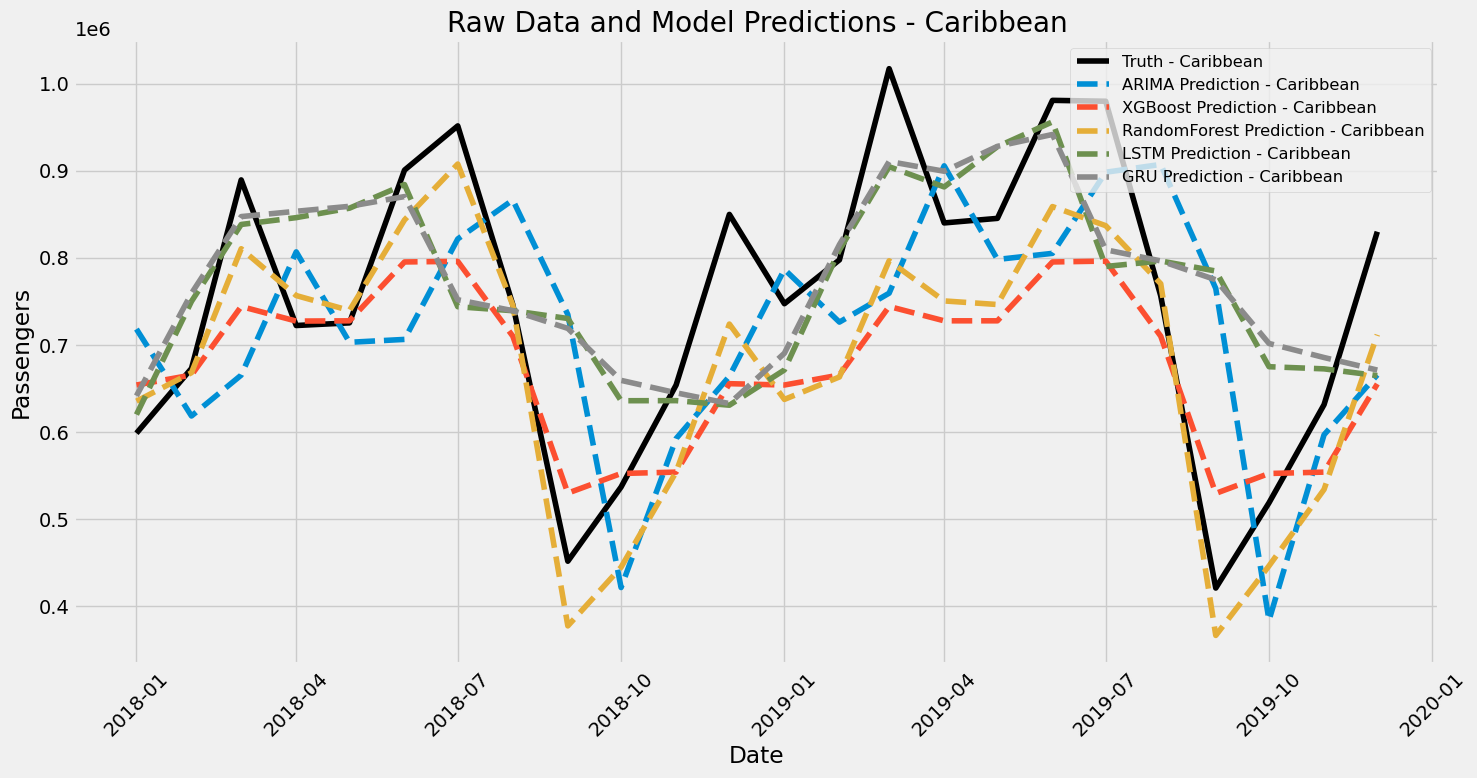

In [82]:
import numpy as np
import pandas as pd
from math import sqrt, log, pi
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
import xgboost as xgb
from tabulate import tabulate
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, GRU, Dense

pd.options.display.float_format = '{:.6f}'.format

# Define metric calculation functions
def calculate_rmse(y_true, y_pred):
    mse = np.mean((y_true - y_pred) ** 2)
    return sqrt(mse)

def calculate_r2(y_true, y_pred):
    ss_res = np.sum((y_true - y_pred) ** 2)
    ss_tot = np.sum((y_true - np.mean(y_true)) ** 2)
    return 1 - (ss_res / ss_tot)

def calculate_mae(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred))

def calculate_mean(y_true):
    return np.mean(y_true)

def calculate_aic(y_true, y_pred, num_params):
    resid = y_true - y_pred
    sse = np.sum(resid ** 2)
    aic = 2 * num_params + len(y_true) * log(sse / len(y_true))
    return aic

def calculate_bic(y_true, y_pred, num_params):
    resid = y_true - y_pred
    sse = np.sum(resid ** 2)
    bic = num_params * log(len(y_true)) + len(y_true) * log(sse / len(y_true))
    return bic

def calculate_nrmse(y_true, y_pred):
    rmse = calculate_rmse(y_true, y_pred)
    return rmse / (np.max(y_true) - np.min(y_true))


new_pre_copy_new = test_data.copy()

region = 'Caribbean'
region_train_data = train_data[train_data['Regions'] == region]
region_test_data = test_data[test_data['Regions'] == region]

# ARIMA Model
print(f"Running ARIMA model for {region}")
history = region_train_data['Passengers'].tolist()
predictions_arima = []

for t in range(len(region_test_data)):
    model = ARIMA(history, order=(1,1,1))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    predictions_arima.append(yhat)
    obs = region_test_data.iloc[t]['Passengers']
    history.append(obs)

actual = region_test_data['Passengers'].values
predicted_arima = np.array(predictions_arima)

rmse_arima = calculate_rmse(actual, predicted_arima)
r2_arima = calculate_r2(actual, predicted_arima)
mae_arima = calculate_mae(actual, predicted_arima)
mean_val_arima = calculate_mean(actual)
k_arima = 3
aic_arima = calculate_aic(actual, predicted_arima, k_arima)
bic_arima = calculate_bic(actual, predicted_arima, k_arima)
nrmse_arima = calculate_nrmse(actual, predicted_arima)

metrics_arima = {
    'Model': 'ARIMA(1,1,1)',
    'RMSE': rmse_arima,
    'NRMSE': nrmse_arima,
    'MAE': mae_arima,
    'R^2': r2_arima,
    'AIC': aic_arima,
    'BIC': bic_arima,
    'Mean': mean_val_arima
}

region_test_data['prediction_arima'] = predictions_arima

# XGBoost Model
print(f"Running XGBoost model for {region}")
train = create_features(train_data)
test = create_features(test_data)

train = pd.get_dummies(train, columns=['Regions'])
test = pd.get_dummies(test, columns=['Regions'])

FEATURES = ['dayofyear', 'dayofweek', 'quarter', 'month', 'year'] + \
           [col for col in train.columns if 'Regions_' in col]
TARGET = 'Passengers'

X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',
                       n_estimators=1000,
                       early_stopping_rounds=50,
                       objective='reg:squarederror',  # Corrected objective
                       max_depth=3,
                       learning_rate=0.01)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=100)

test['prediction_xgb'] = reg.predict(X_test)

region_column = 'Regions_Caribbean'
region_data = test[test[region_column] == 1]

actual = region_data['Passengers'].values
predicted_xgb = region_data['prediction_xgb'].values
k_xgb = len(FEATURES)

rmse_xgb = calculate_rmse(actual, predicted_xgb)
r2_xgb = calculate_r2(actual, predicted_xgb)
mae_xgb = calculate_mae(actual, predicted_xgb)
aic_xgb = calculate_aic(actual, predicted_xgb, k_xgb)
bic_xgb = calculate_bic(actual, predicted_xgb, k_xgb)
nrmse_xgb = calculate_nrmse(actual, predicted_xgb)

# XGBoost metrics
metrics_xgb = {
    'Model': 'XGBoost',
    'RMSE': rmse_xgb,
    'NRMSE': nrmse_xgb,
    'MAE': mae_xgb,
    'R^2': r2_xgb,
    'AIC': aic_xgb,
    'BIC': bic_xgb,
    'Mean': calculate_mean(actual)
}

# Random Forest Model
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

test['prediction_rf'] = y_pred_rf

region_data_rf = test[test[region_column] == 1]

actual_rf = region_data_rf['Passengers'].values
predicted_rf = region_data_rf['prediction_rf'].values
k_rf = len(FEATURES)  # Corrected to use the number of features instead of n_estimators

rmse_rf = calculate_rmse(actual_rf, predicted_rf)
r2_rf = calculate_r2(actual_rf, predicted_rf)
mae_rf = calculate_mae(actual_rf, predicted_rf)
aic_rf = calculate_aic(actual_rf, predicted_rf, k_rf)
bic_rf = calculate_bic(actual_rf, predicted_rf, k_rf)
nrmse_rf = calculate_nrmse(actual_rf, predicted_rf)

# Random Forest metrics
metrics_rf = {
    'Model': 'RandomForest',
    'RMSE': rmse_rf,
    'NRMSE': nrmse_rf,
    'MAE': mae_rf,
    'R^2': r2_rf,
    'AIC': aic_rf,
    'BIC': bic_rf,
    'Mean': calculate_mean(actual_rf)
}

# LSTM Model
print(f"Running LSTM model for {region}")

feature_scaler = MinMaxScaler(feature_range=(0, 1))
target_scaler = MinMaxScaler(feature_range=(0, 1))

X_train_scaled = feature_scaler.fit_transform(X_train)
X_test_scaled = feature_scaler.transform(X_test)

y_train_scaled = target_scaler.fit_transform(y_train.values.reshape(-1, 1))
y_test_scaled = target_scaler.transform(y_test.values.reshape(-1, 1))

X_train_reshaped = np.reshape(X_train_scaled, (X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_test_reshaped = np.reshape(X_test_scaled, (X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

lstm_model = Sequential()
lstm_model.add(LSTM(50, return_sequences=True, input_shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2])))
lstm_model.add(LSTM(50))
lstm_model.add(Dense(1))

lstm_model.compile(loss='mean_squared_error', optimizer='adam')
lstm_model.fit(X_train_reshaped, y_train_scaled, epochs=200, batch_size=32, validation_data=(X_test_reshaped, y_test_scaled), verbose=2, shuffle=False)

y_pred_lstm_scaled = lstm_model.predict(X_test_reshaped)

y_test_inv = target_scaler.inverse_transform(y_test_scaled)
y_pred_lstm_inv = target_scaler.inverse_transform(y_pred_lstm_scaled)

test['Date'] = test_data['Date']

test['prediction_lstm'] = y_pred_lstm_inv
new_pre_copy_new = new_pre_copy_new.merge(test[['Date', 'prediction_lstm']], how='left', left_index=True, right_index=True)

caribbean_data = new_pre_copy_new[new_pre_copy_new['Regions'] == 'Caribbean']

if not caribbean_data.empty:
    caribbean_data = caribbean_data.dropna(subset=['Passengers', 'prediction_lstm'])

    actual = caribbean_data['Passengers'].values
    predicted = caribbean_data['prediction_lstm'].values

    rmse_lstm = calculate_rmse(actual, predicted)
    r2_lstm = calculate_r2(actual, predicted)
    mae_lstm = calculate_mae(actual, predicted)
    mean_lstm = calculate_mean(actual)
    num_params_lstm = lstm_model.count_params()
    aic_lstm = calculate_aic(actual, predicted, num_params_lstm)
    bic_lstm = calculate_bic(actual, predicted, num_params_lstm)
    nrmse_lstm = calculate_nrmse(actual, predicted)

    metrics_lstm = {
        'Model': 'LSTM',
        'RMSE': rmse_lstm,
        'NRMSE': nrmse_lstm,
        'MAE': mae_lstm,
        'R^2': r2_lstm,
        'AIC': aic_lstm,
        'BIC': bic_lstm,
        'Mean': mean_lstm
    }

# GRU Model
print(f"Running GRU model for {region}")

X_train_scaled = feature_scaler.fit_transform(X_train)
X_test_scaled = feature_scaler.transform(X_test)

y_train_scaled = target_scaler.fit_transform(y_train.values.reshape(-1, 1))
y_test_scaled = target_scaler.transform(y_test.values.reshape(-1, 1))

X_train_reshaped = np.reshape(X_train_scaled, (X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_test_reshaped = np.reshape(X_test_scaled, (X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

gru_model = Sequential()
gru_model.add(GRU(50, return_sequences=True, input_shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2])))
gru_model.add(GRU(50))
gru_model.add(Dense(1))

gru_model.compile(loss='mean_squared_error', optimizer='adam')
gru_model.fit(X_train_reshaped, y_train_scaled, epochs=200, batch_size=32, validation_data=(X_test_reshaped, y_test_scaled), verbose=2, shuffle=False)

y_pred_gru_scaled = gru_model.predict(X_test_reshaped)

y_pred_gru_inv = target_scaler.inverse_transform(y_pred_gru_scaled)

test['prediction_gru'] = y_pred_gru_inv
new_pre_copy_new = new_pre_copy_new.merge(test[['Date', 'prediction_gru']], how='left', left_index=True, right_index=True)

caribbean_data = new_pre_copy_new[new_pre_copy_new['Regions'] == 'Caribbean']

if not caribbean_data.empty:
    caribbean_data = caribbean_data.dropna(subset=['Passengers', 'prediction_gru'])

    actual = caribbean_data['Passengers'].values
    predicted = caribbean_data['prediction_gru'].values

    rmse_gru = calculate_rmse(actual, predicted)
    r2_gru = calculate_r2(actual, predicted)
    mae_gru = calculate_mae(actual, predicted)
    mean_gru = calculate_mean(actual)
    num_params_gru = gru_model.count_params()
    aic_gru = calculate_aic(actual, predicted, num_params_gru)
    bic_gru = calculate_bic(actual, predicted, num_params_gru)
    nrmse_gru = calculate_nrmse(actual, predicted)

    # GRU metrics
    metrics_gru = {
        'Model': 'GRU',
        'RMSE': rmse_gru,
        'NRMSE': nrmse_gru,
        'MAE': mae_gru,
        'R^2': r2_gru,
        'AIC': aic_gru,
        'BIC': bic_gru,
        'Mean': mean_gru
    }

metrics_df = pd.DataFrame([metrics_arima, metrics_xgb, metrics_rf, metrics_lstm, metrics_gru])


print(tabulate(metrics_df, headers="keys", tablefmt="grid"))

# Plot predictions for Caribbean
plt.figure(figsize=(15, 8))
plt.plot(region_test_data['Date'], region_test_data['Passengers'], label='Truth - Caribbean', color='black')
plt.plot(region_test_data['Date'], region_test_data['prediction_arima'], linestyle='--', label='ARIMA Prediction - Caribbean')
plt.plot(region_data['Date'], predicted_xgb, linestyle='--', label='XGBoost Prediction - Caribbean')
plt.plot(region_data_rf['Date'], predicted_rf, linestyle='--', label='RandomForest Prediction - Caribbean')
plt.plot(caribbean_data['Date'], caribbean_data['prediction_lstm'], linestyle='--', label='LSTM Prediction - Caribbean')
plt.plot(caribbean_data['Date'], caribbean_data['prediction_gru'], linestyle='--', label='GRU Prediction - Caribbean')

plt.title('Raw Data and Model Predictions - Caribbean')
plt.xlabel('Date')
plt.ylabel('Passengers')
plt.legend(loc='upper right', fontsize='small')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [83]:

metrics_df = metrics_df.round(2)

print(tabulate(metrics_df, headers="keys", tablefmt="grid"))

+----+--------------+----------+---------+----------+-------+----------+-----------+--------+
|    | Model        |     RMSE |   NRMSE |      MAE |   R^2 |      AIC |       BIC |   Mean |
+====+==============+==========+=========+==========+=======+==========+===========+========+
|  0 | ARIMA(1,1,1) | 155508   |    0.26 | 131744   |  0.1  |   579.81 |    583.35 | 752919 |
+----+--------------+----------+---------+----------+-------+----------+-----------+--------+
|  1 | XGBoost      | 122773   |    0.21 | 101617   |  0.44 |   588.47 |    603.78 | 752919 |
+----+--------------+----------+---------+----------+-------+----------+-----------+--------+
|  2 | RandomForest |  95221.4 |    0.16 |  80707.5 |  0.66 |   576.27 |    591.58 | 752919 |
+----+--------------+----------+---------+----------+-------+----------+-----------+--------+
|  3 | LSTM         | 140204   |    0.24 | 106452   |  0.27 | 66670.8  | 105607    | 752919 |
+----+--------------+----------+---------+----------+-------

## All Models for Europe




Running ARIMA model for Europe


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Running XGBoost model for Europe
[0]	validation_0-rmse:501260.90383	validation_1-rmse:674207.90211


<ipython-input-85-cda6ad79416d>:93: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  region_test_data['prediction_arima'] = predictions_arima
<ipython-input-76-1bc1f22e4fb8>:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Date'] = pd.to_datetime(df['Date'])
<ipython-input-76-1bc1f22e4fb8>:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pa

[100]	validation_0-rmse:213147.72935	validation_1-rmse:376704.49299
[200]	validation_0-rmse:112930.84981	validation_1-rmse:241828.80790
[300]	validation_0-rmse:78370.03330	validation_1-rmse:185650.43711
[400]	validation_0-rmse:63964.36826	validation_1-rmse:160881.53814
[500]	validation_0-rmse:55614.56480	validation_1-rmse:146493.09532
[600]	validation_0-rmse:48768.89349	validation_1-rmse:136175.39443
[700]	validation_0-rmse:44301.20420	validation_1-rmse:129368.77021
[800]	validation_0-rmse:40759.17040	validation_1-rmse:124295.68603
[900]	validation_0-rmse:37632.40075	validation_1-rmse:120581.59527
[999]	validation_0-rmse:34954.49871	validation_1-rmse:117383.98125
Running LSTM model for Europe


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/200
15/15 - 10s - 647ms/step - loss: 0.0429 - val_loss: 0.0665
Epoch 2/200
15/15 - 0s - 11ms/step - loss: 0.0286 - val_loss: 0.0514
Epoch 3/200
15/15 - 0s - 13ms/step - loss: 0.0238 - val_loss: 0.0440
Epoch 4/200
15/15 - 0s - 10ms/step - loss: 0.0179 - val_loss: 0.0341
Epoch 5/200
15/15 - 0s - 19ms/step - loss: 0.0112 - val_loss: 0.0220
Epoch 6/200
15/15 - 0s - 10ms/step - loss: 0.0063 - val_loss: 0.0138
Epoch 7/200
15/15 - 0s - 10ms/step - loss: 0.0052 - val_loss: 0.0113
Epoch 8/200
15/15 - 0s - 9ms/step - loss: 0.0050 - val_loss: 0.0112
Epoch 9/200
15/15 - 0s - 7ms/step - loss: 0.0049 - val_loss: 0.0113
Epoch 10/200
15/15 - 0s - 6ms/step - loss: 0.0048 - val_loss: 0.0111
Epoch 11/200
15/15 - 0s - 10ms/step - loss: 0.0047 - val_loss: 0.0110
Epoch 12/200
15/15 - 0s - 9ms/step - loss: 0.0047 - val_loss: 0.0110
Epoch 13/200
15/15 - 0s - 6ms/step - loss: 0.0047 - val_loss: 0.0110
Epoch 14/200
15/15 - 0s - 9ms/step - loss: 0.0047 - val_loss: 0.0109
Epoch 15/200
15/15 - 0s - 11ms/st

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


15/15 - 4s - 257ms/step - loss: 0.0270 - val_loss: 0.0394
Epoch 2/200
15/15 - 0s - 7ms/step - loss: 0.0137 - val_loss: 0.0252
Epoch 3/200
15/15 - 0s - 10ms/step - loss: 0.0068 - val_loss: 0.0147
Epoch 4/200
15/15 - 0s - 26ms/step - loss: 0.0053 - val_loss: 0.0120
Epoch 5/200
15/15 - 0s - 8ms/step - loss: 0.0051 - val_loss: 0.0122
Epoch 6/200
15/15 - 0s - 6ms/step - loss: 0.0049 - val_loss: 0.0124
Epoch 7/200
15/15 - 0s - 8ms/step - loss: 0.0049 - val_loss: 0.0124
Epoch 8/200
15/15 - 0s - 10ms/step - loss: 0.0048 - val_loss: 0.0123
Epoch 9/200
15/15 - 0s - 7ms/step - loss: 0.0048 - val_loss: 0.0122
Epoch 10/200
15/15 - 0s - 7ms/step - loss: 0.0048 - val_loss: 0.0121
Epoch 11/200
15/15 - 0s - 9ms/step - loss: 0.0048 - val_loss: 0.0121
Epoch 12/200
15/15 - 0s - 7ms/step - loss: 0.0048 - val_loss: 0.0120
Epoch 13/200
15/15 - 0s - 7ms/step - loss: 0.0047 - val_loss: 0.0119
Epoch 14/200
15/15 - 0s - 6ms/step - loss: 0.0047 - val_loss: 0.0118
Epoch 15/200
15/15 - 0s - 10ms/step - loss: 0.0047

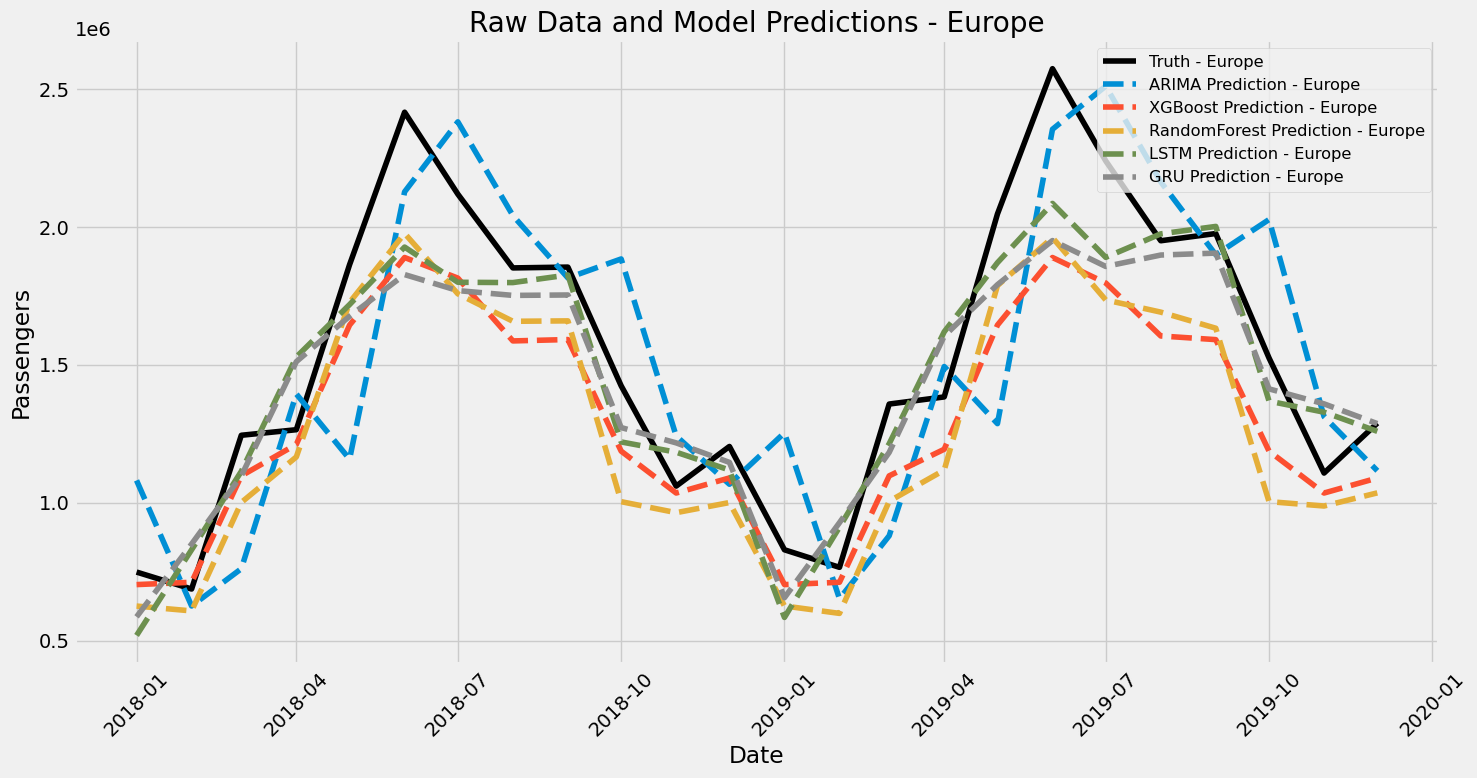

In [85]:
import numpy as np
import pandas as pd
from math import sqrt, log, pi
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
import xgboost as xgb
from tabulate import tabulate
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, GRU, Dense

pd.options.display.float_format = '{:.6f}'.format

# Define metric calculation functions
def calculate_rmse(y_true, y_pred):
    mse = np.mean((y_true - y_pred) ** 2)
    return sqrt(mse)

def calculate_r2(y_true, y_pred):
    ss_res = np.sum((y_true - y_pred) ** 2)
    ss_tot = np.sum((y_true - np.mean(y_true)) ** 2)
    return 1 - (ss_res / ss_tot)

def calculate_mae(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred))

def calculate_mean(y_true):
    return np.mean(y_true)

def calculate_aic(y_true, y_pred, num_params):
    resid = y_true - y_pred
    sse = np.sum(resid ** 2)
    aic = 2 * num_params + len(y_true) * log(sse / len(y_true))
    return aic

def calculate_bic(y_true, y_pred, num_params):
    resid = y_true - y_pred
    sse = np.sum(resid ** 2)
    bic = num_params * log(len(y_true)) + len(y_true) * log(sse / len(y_true))
    return bic

def calculate_nrmse(y_true, y_pred):
    rmse = calculate_rmse(y_true, y_pred)
    return rmse / (np.max(y_true) - np.min(y_true))



new_pre_copy_new = test_data.copy()

region = 'Europe'
region_train_data = train_data[train_data['Regions'] == region]
region_test_data = test_data[test_data['Regions'] == region]

# ARIMA Model
print(f"Running ARIMA model for {region}")
history = region_train_data['Passengers'].tolist()
predictions_arima = []

for t in range(len(region_test_data)):
    model = ARIMA(history, order=(1,1,1))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    predictions_arima.append(yhat)
    obs = region_test_data.iloc[t]['Passengers']
    history.append(obs)

actual = region_test_data['Passengers'].values
predicted_arima = np.array(predictions_arima)

rmse_arima = calculate_rmse(actual, predicted_arima)
r2_arima = calculate_r2(actual, predicted_arima)
mae_arima = calculate_mae(actual, predicted_arima)
mean_val_arima = calculate_mean(actual)
k_arima = 3  # Number of parameters in ARIMA(1,1,1) including constant term
aic_arima = calculate_aic(actual, predicted_arima, k_arima)
bic_arima = calculate_bic(actual, predicted_arima, k_arima)
nrmse_arima = calculate_nrmse(actual, predicted_arima)

# ARIMA metrics
metrics_arima = {
    'Model': 'ARIMA(1,1,1)',
    'RMSE': rmse_arima,
    'NRMSE': nrmse_arima,
    'MAE': mae_arima,
    'R^2': r2_arima,
    'AIC': aic_arima,
    'BIC': bic_arima,
    'Mean': mean_val_arima
}

region_test_data['prediction_arima'] = predictions_arima

# XGBoost Model
print(f"Running XGBoost model for {region}")
train = create_features(train_data)
test = create_features(test_data)

train = pd.get_dummies(train, columns=['Regions'])
test = pd.get_dummies(test, columns=['Regions'])

FEATURES = ['dayofyear', 'dayofweek', 'quarter', 'month', 'year'] + \
           [col for col in train.columns if 'Regions_' in col]
TARGET = 'Passengers'

X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',
                       n_estimators=1000,
                       early_stopping_rounds=50,
                       objective='reg:squarederror',  # Corrected objective
                       max_depth=3,
                       learning_rate=0.01)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=100)

# XGBoost predictions
test['prediction_xgb'] = reg.predict(X_test)

region_column = 'Regions_Europe'
region_data = test[test[region_column] == 1]

actual = region_data['Passengers'].values
predicted_xgb = region_data['prediction_xgb'].values
k_xgb = len(FEATURES)

rmse_xgb = calculate_rmse(actual, predicted_xgb)
r2_xgb = calculate_r2(actual, predicted_xgb)
mae_xgb = calculate_mae(actual, predicted_xgb)
aic_xgb = calculate_aic(actual, predicted_xgb, k_xgb)
bic_xgb = calculate_bic(actual, predicted_xgb, k_xgb)
nrmse_xgb = calculate_nrmse(actual, predicted_xgb)

# XGBoost metrics
metrics_xgb = {
    'Model': 'XGBoost',
    'RMSE': rmse_xgb,
    'NRMSE': nrmse_xgb,
    'MAE': mae_xgb,
    'R^2': r2_xgb,
    'AIC': aic_xgb,
    'BIC': bic_xgb,
    'Mean': calculate_mean(actual)
}

# Random Forest Model
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

test['prediction_rf'] = y_pred_rf

region_data_rf = test[test[region_column] == 1]

actual_rf = region_data_rf['Passengers'].values
predicted_rf = region_data_rf['prediction_rf'].values
k_rf = len(FEATURES)

rmse_rf = calculate_rmse(actual_rf, predicted_rf)
r2_rf = calculate_r2(actual_rf, predicted_rf)
mae_rf = calculate_mae(actual_rf, predicted_rf)
aic_rf = calculate_aic(actual_rf, predicted_rf, k_rf)
bic_rf = calculate_bic(actual_rf, predicted_rf, k_rf)
nrmse_rf = calculate_nrmse(actual_rf, predicted_rf)

# Random Forest metrics
metrics_rf = {
    'Model': 'RandomForest',
    'RMSE': rmse_rf,
    'NRMSE': nrmse_rf,
    'MAE': mae_rf,
    'R^2': r2_rf,
    'AIC': aic_rf,
    'BIC': bic_rf,
    'Mean': calculate_mean(actual_rf)
}

# LSTM Model
print(f"Running LSTM model for {region}")

feature_scaler = MinMaxScaler(feature_range=(0, 1))
target_scaler = MinMaxScaler(feature_range=(0, 1))

X_train_scaled = feature_scaler.fit_transform(X_train)
X_test_scaled = feature_scaler.transform(X_test)

y_train_scaled = target_scaler.fit_transform(y_train.values.reshape(-1, 1))
y_test_scaled = target_scaler.transform(y_test.values.reshape(-1, 1))

X_train_reshaped = np.reshape(X_train_scaled, (X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_test_reshaped = np.reshape(X_test_scaled, (X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

lstm_model = Sequential()
lstm_model.add(LSTM(50, return_sequences=True, input_shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2])))
lstm_model.add(LSTM(50))
lstm_model.add(Dense(1))

lstm_model.compile(loss='mean_squared_error', optimizer='adam')
lstm_model.fit(X_train_reshaped, y_train_scaled, epochs=200, batch_size=32, validation_data=(X_test_reshaped, y_test_scaled), verbose=2, shuffle=False)

y_pred_lstm_scaled = lstm_model.predict(X_test_reshaped)

y_test_inv = target_scaler.inverse_transform(y_test_scaled)
y_pred_lstm_inv = target_scaler.inverse_transform(y_pred_lstm_scaled)

test['Date'] = test_data['Date']

test['prediction_lstm'] = y_pred_lstm_inv
new_pre_copy_new = new_pre_copy_new.merge(test[['Date', 'prediction_lstm']], how='left', left_index=True, right_index=True)

europe_data = new_pre_copy_new[new_pre_copy_new['Regions'] == 'Europe']

if not europe_data.empty:
    europe_data = europe_data.dropna(subset=['Passengers', 'prediction_lstm'])

    actual = europe_data['Passengers'].values
    predicted = europe_data['prediction_lstm'].values

    rmse_lstm = calculate_rmse(actual, predicted)
    r2_lstm = calculate_r2(actual, predicted)
    mae_lstm = calculate_mae(actual, predicted)
    aic_lstm = calculate_aic(actual, predicted, lstm_model.count_params())
    bic_lstm = calculate_bic(actual, predicted, lstm_model.count_params())
    nrmse_lstm = calculate_nrmse(actual, predicted)

    metrics_lstm = {
        'Model': 'LSTM',
        'RMSE': rmse_lstm,
        'NRMSE': nrmse_lstm,
        'MAE': mae_lstm,
        'R^2': r2_lstm,
        'AIC': aic_lstm,
        'BIC': bic_lstm,
        'Mean': calculate_mean(actual)
    }

# GRU Model
print(f"Running GRU model for {region}")

X_train_scaled = feature_scaler.fit_transform(X_train)
X_test_scaled = feature_scaler.transform(X_test)

y_train_scaled = target_scaler.fit_transform(y_train.values.reshape(-1, 1))
y_test_scaled = target_scaler.transform(y_test.values.reshape(-1, 1))

X_train_reshaped = np.reshape(X_train_scaled, (X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_test_reshaped = np.reshape(X_test_scaled, (X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

gru_model = Sequential()
gru_model.add(GRU(50, return_sequences=True, input_shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2])))
gru_model.add(GRU(50))
gru_model.add(Dense(1))

gru_model.compile(loss='mean_squared_error', optimizer='adam')
gru_model.fit(X_train_reshaped, y_train_scaled, epochs=200, batch_size=32, validation_data=(X_test_reshaped, y_test_scaled), verbose=2, shuffle=False)

y_pred_gru_scaled = gru_model.predict(X_test_reshaped)

y_pred_gru_inv = target_scaler.inverse_transform(y_pred_gru_scaled)

test['prediction_gru'] = y_pred_gru_inv
new_pre_copy_new = new_pre_copy_new.merge(test[['Date', 'prediction_gru']], how='left', left_index=True, right_index=True)

europe_data = new_pre_copy_new[new_pre_copy_new['Regions'] == 'Europe']

if not europe_data.empty:
    europe_data = europe_data.dropna(subset=['Passengers', 'prediction_gru'])

    actual = europe_data['Passengers'].values
    predicted = europe_data['prediction_gru'].values

    rmse_gru = calculate_rmse(actual, predicted)
    r2_gru = calculate_r2(actual, predicted)
    mae_gru = calculate_mae(actual, predicted)
    aic_gru = calculate_aic(actual, predicted, gru_model.count_params())
    bic_gru = calculate_bic(actual, predicted, gru_model.count_params())
    nrmse_gru = calculate_nrmse(actual, predicted)

    # GRU metrics
    metrics_gru = {
        'Model': 'GRU',
        'RMSE': rmse_gru,
        'NRMSE': nrmse_gru,
        'MAE': mae_gru,
        'R^2': r2_gru,
        'AIC': aic_gru,
        'BIC': bic_gru,
        'Mean': calculate_mean(actual)
    }

metrics_df = pd.DataFrame([metrics_arima, metrics_xgb, metrics_rf, metrics_lstm, metrics_gru])

print(tabulate(metrics_df, headers="keys", tablefmt="grid"))

# Plot predictions for Europe
plt.figure(figsize=(15, 8))
plt.plot(region_test_data['Date'], region_test_data['Passengers'], label='Truth - Europe', color='black')
plt.plot(region_test_data['Date'], region_test_data['prediction_arima'], linestyle='--', label='ARIMA Prediction - Europe')
plt.plot(region_data['Date'], predicted_xgb, linestyle='--', label='XGBoost Prediction - Europe')
plt.plot(region_data_rf['Date'], predicted_rf, linestyle='--', label='RandomForest Prediction - Europe')
plt.plot(europe_data['Date'], europe_data['prediction_lstm'], linestyle='--', label='LSTM Prediction - Europe')
plt.plot(europe_data['Date'], europe_data['prediction_gru'], linestyle='--', label='GRU Prediction - Europe')

plt.title('Raw Data and Model Predictions - Europe')
plt.xlabel('Date')
plt.ylabel('Passengers')
plt.legend(loc='upper right', fontsize='small')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [86]:
metrics_df = metrics_df.round(2)

print(tabulate(metrics_df, headers="keys", tablefmt="grid"))

+----+--------------+--------+---------+--------+-------+----------+-----------+-------------+
|    | Model        |   RMSE |   NRMSE |    MAE |   R^2 |      AIC |       BIC |        Mean |
+====+==============+========+=========+========+=======+==========+===========+=============+
|  0 | ARIMA(1,1,1) | 343122 |    0.18 | 284167 |  0.59 |   617.8  |    621.33 | 1.53298e+06 |
+----+--------------+--------+---------+--------+-------+----------+-----------+-------------+
|  1 | XGBoost      | 290915 |    0.15 | 238561 |  0.7  |   629.88 |    645.19 | 1.53298e+06 |
+----+--------------+--------+---------+--------+-------+----------+-----------+-------------+
|  2 | RandomForest | 304987 |    0.16 | 268881 |  0.67 |   632.15 |    647.46 | 1.53298e+06 |
+----+--------------+--------+---------+--------+-------+----------+-----------+-------------+
|  3 | LSTM         | 225047 |    0.12 | 185771 |  0.82 | 66693.6  | 105629    | 1.53298e+06 |
+----+--------------+--------+---------+--------+-

## All Models for Middle East

Running ARIMA model for Middle East


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/st

Running XGBoost model for Middle East
[0]	validation_0-rmse:501260.90383	validation_1-rmse:674207.90211


<ipython-input-87-935d320a4d89>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  region_test_data['prediction_arima'] = predictions_arima
<ipython-input-76-1bc1f22e4fb8>:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Date'] = pd.to_datetime(df['Date'])
<ipython-input-76-1bc1f22e4fb8>:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pa

[100]	validation_0-rmse:213147.72935	validation_1-rmse:376704.49299
[200]	validation_0-rmse:112930.84981	validation_1-rmse:241828.80790
[300]	validation_0-rmse:78370.03330	validation_1-rmse:185650.43711
[400]	validation_0-rmse:63964.36826	validation_1-rmse:160881.53814
[500]	validation_0-rmse:55614.56480	validation_1-rmse:146493.09532
[600]	validation_0-rmse:48768.89349	validation_1-rmse:136175.39443
[700]	validation_0-rmse:44301.20420	validation_1-rmse:129368.77021
[800]	validation_0-rmse:40759.17040	validation_1-rmse:124295.68603
[900]	validation_0-rmse:37632.40075	validation_1-rmse:120581.59527
[999]	validation_0-rmse:34954.49871	validation_1-rmse:117383.98125
Running LSTM model for Middle East
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


15/15 - 5s - 341ms/step - loss: 0.0394 - val_loss: 0.0595
Epoch 2/200
15/15 - 1s - 61ms/step - loss: 0.0277 - val_loss: 0.0493
Epoch 3/200
15/15 - 0s - 7ms/step - loss: 0.0217 - val_loss: 0.0402
Epoch 4/200
15/15 - 0s - 9ms/step - loss: 0.0148 - val_loss: 0.0275
Epoch 5/200
15/15 - 0s - 8ms/step - loss: 0.0079 - val_loss: 0.0158
Epoch 6/200
15/15 - 0s - 7ms/step - loss: 0.0052 - val_loss: 0.0112
Epoch 7/200
15/15 - 0s - 7ms/step - loss: 0.0051 - val_loss: 0.0109
Epoch 8/200
15/15 - 0s - 10ms/step - loss: 0.0049 - val_loss: 0.0113
Epoch 9/200
15/15 - 0s - 9ms/step - loss: 0.0048 - val_loss: 0.0112
Epoch 10/200
15/15 - 0s - 27ms/step - loss: 0.0047 - val_loss: 0.0111
Epoch 11/200
15/15 - 0s - 12ms/step - loss: 0.0047 - val_loss: 0.0110
Epoch 12/200
15/15 - 0s - 9ms/step - loss: 0.0047 - val_loss: 0.0110
Epoch 13/200
15/15 - 0s - 9ms/step - loss: 0.0047 - val_loss: 0.0110
Epoch 14/200
15/15 - 0s - 21ms/step - loss: 0.0046 - val_loss: 0.0109
Epoch 15/200
15/15 - 0s - 13ms/step - loss: 0.00

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


15/15 - 4s - 279ms/step - loss: 0.0297 - val_loss: 0.0417
Epoch 2/200
15/15 - 0s - 6ms/step - loss: 0.0148 - val_loss: 0.0277
Epoch 3/200
15/15 - 0s - 9ms/step - loss: 0.0069 - val_loss: 0.0155
Epoch 4/200
15/15 - 0s - 9ms/step - loss: 0.0053 - val_loss: 0.0124
Epoch 5/200
15/15 - 0s - 7ms/step - loss: 0.0051 - val_loss: 0.0124
Epoch 6/200
15/15 - 0s - 10ms/step - loss: 0.0050 - val_loss: 0.0125
Epoch 7/200
15/15 - 0s - 9ms/step - loss: 0.0049 - val_loss: 0.0125
Epoch 8/200
15/15 - 0s - 9ms/step - loss: 0.0049 - val_loss: 0.0124
Epoch 9/200
15/15 - 0s - 8ms/step - loss: 0.0049 - val_loss: 0.0124
Epoch 10/200
15/15 - 0s - 13ms/step - loss: 0.0048 - val_loss: 0.0123
Epoch 11/200
15/15 - 0s - 10ms/step - loss: 0.0048 - val_loss: 0.0122
Epoch 12/200
15/15 - 0s - 21ms/step - loss: 0.0048 - val_loss: 0.0122
Epoch 13/200
15/15 - 0s - 12ms/step - loss: 0.0048 - val_loss: 0.0121
Epoch 14/200
15/15 - 0s - 9ms/step - loss: 0.0048 - val_loss: 0.0120
Epoch 15/200
15/15 - 0s - 8ms/step - loss: 0.004

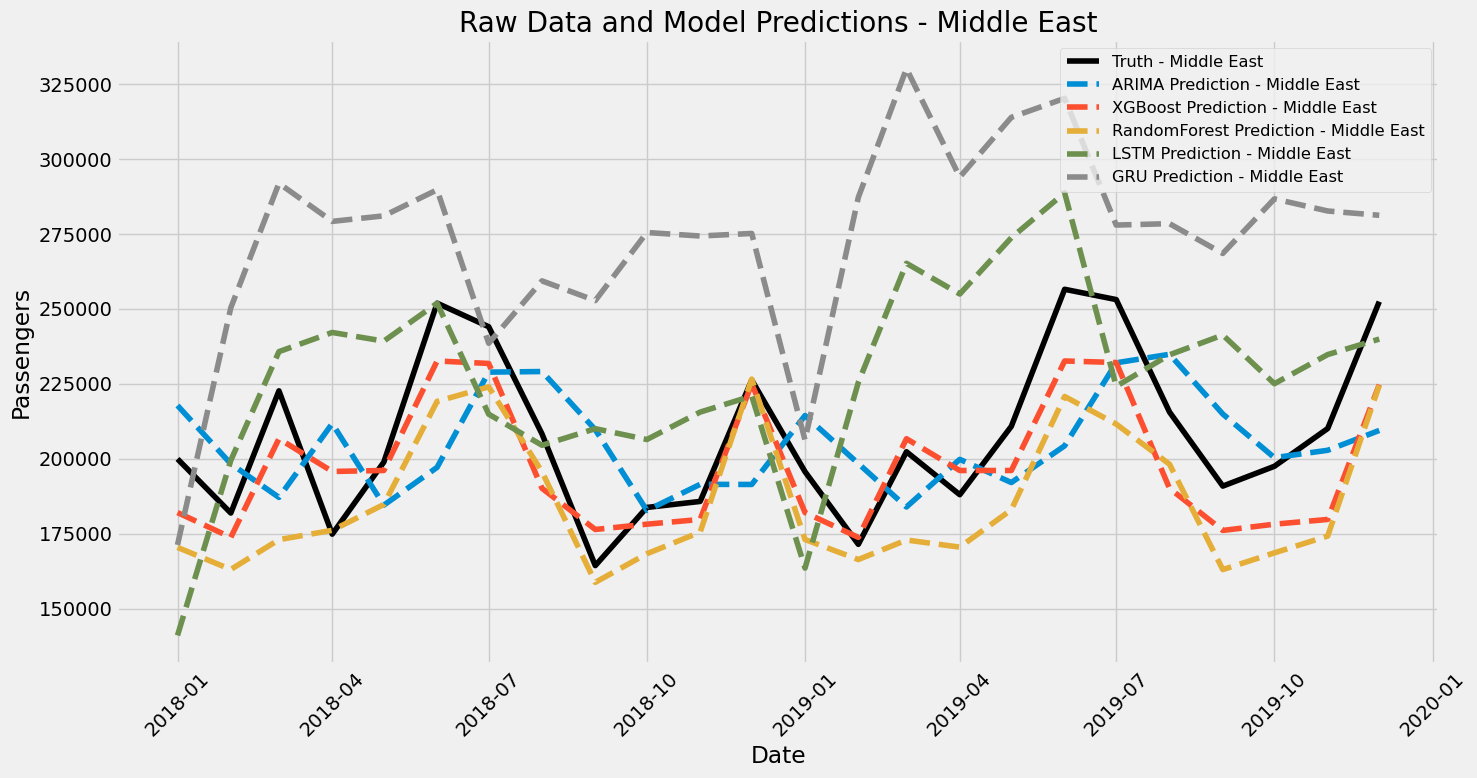

In [87]:
import numpy as np
import pandas as pd
from math import sqrt, log, pi
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
import xgboost as xgb
from tabulate import tabulate
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, GRU, Dense

pd.options.display.float_format = '{:.6f}'.format

# Define metric calculation functions
def calculate_rmse(y_true, y_pred):
    mse = np.mean((y_true - y_pred) ** 2)
    return sqrt(mse)

def calculate_r2(y_true, y_pred):
    ss_res = np.sum((y_true - y_pred) ** 2)
    ss_tot = np.sum((y_true - np.mean(y_true)) ** 2)
    return 1 - (ss_res / ss_tot)

def calculate_mae(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred))

def calculate_mean(y_true):
    return np.mean(y_true)

def calculate_aic(y_true, y_pred, num_params):
    resid = y_true - y_pred
    sse = np.sum(resid ** 2)
    aic = 2 * num_params + len(y_true) * log(sse / len(y_true))
    return aic

def calculate_bic(y_true, y_pred, num_params):
    resid = y_true - y_pred
    sse = np.sum(resid ** 2)
    bic = num_params * log(len(y_true)) + len(y_true) * log(sse / len(y_true))
    return bic

def calculate_nrmse(y_true, y_pred):
    rmse = calculate_rmse(y_true, y_pred)
    return rmse / (np.max(y_true) - np.min(y_true))

# Ensure test_data, train_data, and create_features are defined
new_pre_copy_new = test_data.copy()

region = 'Middle East'
region_train_data = train_data[train_data['Regions'] == region]
region_test_data = test_data[test_data['Regions'] == region]

# ARIMA Model
print(f"Running ARIMA model for {region}")
history = region_train_data['Passengers'].tolist()
predictions_arima = []

for t in range(len(region_test_data)):
    model = ARIMA(history, order=(1,1,1))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    predictions_arima.append(yhat)
    obs = region_test_data.iloc[t]['Passengers']
    history.append(obs)

actual = region_test_data['Passengers'].values
predicted_arima = np.array(predictions_arima)

# ARIMA metrics
rmse_arima = calculate_rmse(actual, predicted_arima)
r2_arima = calculate_r2(actual, predicted_arima)
mae_arima = calculate_mae(actual, predicted_arima)
mean_val_arima = calculate_mean(actual)
k_arima = 3
aic_arima = calculate_aic(actual, predicted_arima, k_arima)
bic_arima = calculate_bic(actual, predicted_arima, k_arima)
nrmse_arima = calculate_nrmse(actual, predicted_arima)

metrics_arima = {
    'Model': 'ARIMA(1,1,1)',
    'RMSE': rmse_arima,
    'NRMSE': nrmse_arima,
    'MAE': mae_arima,
    'R^2': r2_arima,
    'AIC': aic_arima,
    'BIC': bic_arima,
    'Mean': mean_val_arima
}

region_test_data['prediction_arima'] = predictions_arima

# XGBoost Model
print(f"Running XGBoost model for {region}")
train = create_features(train_data)
test = create_features(test_data)

train = pd.get_dummies(train, columns=['Regions'])
test = pd.get_dummies(test, columns=['Regions'])

FEATURES = ['dayofyear', 'dayofweek', 'quarter', 'month', 'year'] + \
           [col for col in train.columns if 'Regions_' in col]
TARGET = 'Passengers'

X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',
                       n_estimators=1000,
                       early_stopping_rounds=50,
                       objective='reg:squarederror',  # Corrected objective
                       max_depth=3,
                       learning_rate=0.01)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=100)

test['prediction_xgb'] = reg.predict(X_test)

region_column = 'Regions_Middle East'
region_data = test[test[region_column] == 1]

actual = region_data['Passengers'].values
predicted_xgb = region_data['prediction_xgb'].values
k_xgb = len(FEATURES)

rmse_xgb = calculate_rmse(actual, predicted_xgb)
r2_xgb = calculate_r2(actual, predicted_xgb)
mae_xgb = calculate_mae(actual, predicted_xgb)
aic_xgb = calculate_aic(actual, predicted_xgb, k_xgb)
bic_xgb = calculate_bic(actual, predicted_xgb, k_xgb)
nrmse_xgb = calculate_nrmse(actual, predicted_xgb)

# XGBoost metrics
metrics_xgb = {
    'Model': 'XGBoost',
    'RMSE': rmse_xgb,
    'NRMSE': nrmse_xgb,
    'MAE': mae_xgb,
    'R^2': r2_xgb,
    'AIC': aic_xgb,
    'BIC': bic_xgb,
    'Mean': calculate_mean(actual)
}

# Random Forest Model
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

test['prediction_rf'] = y_pred_rf

region_data_rf = test[test[region_column] == 1]

actual_rf = region_data_rf['Passengers'].values
predicted_rf = region_data_rf['prediction_rf'].values
k_rf = len(FEATURES)

rmse_rf = calculate_rmse(actual_rf, predicted_rf)
r2_rf = calculate_r2(actual_rf, predicted_rf)
mae_rf = calculate_mae(actual_rf, predicted_rf)
aic_rf = calculate_aic(actual_rf, predicted_rf, k_rf)
bic_rf = calculate_bic(actual_rf, predicted_rf, k_rf)
nrmse_rf = calculate_nrmse(actual_rf, predicted_rf)

# Random Forest metrics
metrics_rf = {
    'Model': 'RandomForest',
    'RMSE': rmse_rf,
    'NRMSE': nrmse_rf,
    'MAE': mae_rf,
    'R^2': r2_rf,
    'AIC': aic_rf,
    'BIC': bic_rf,
    'Mean': calculate_mean(actual_rf)
}

# LSTM Model
print(f"Running LSTM model for {region}")

feature_scaler = MinMaxScaler(feature_range=(0, 1))
target_scaler = MinMaxScaler(feature_range=(0, 1))

X_train_scaled = feature_scaler.fit_transform(X_train)
X_test_scaled = feature_scaler.transform(X_test)

y_train_scaled = target_scaler.fit_transform(y_train.values.reshape(-1, 1))
y_test_scaled = target_scaler.transform(y_test.values.reshape(-1, 1))

X_train_reshaped = np.reshape(X_train_scaled, (X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_test_reshaped = np.reshape(X_test_scaled, (X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

lstm_model = Sequential()
lstm_model.add(LSTM(50, return_sequences=True, input_shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2])))
lstm_model.add(LSTM(50))
lstm_model.add(Dense(1))

lstm_model.compile(loss='mean_squared_error', optimizer='adam')
lstm_model.fit(X_train_reshaped, y_train_scaled, epochs=200, batch_size=32, validation_data=(X_test_reshaped, y_test_scaled), verbose=2, shuffle=False)

y_pred_lstm_scaled = lstm_model.predict(X_test_reshaped)

y_test_inv = target_scaler.inverse_transform(y_test_scaled)
y_pred_lstm_inv = target_scaler.inverse_transform(y_pred_lstm_scaled)

test['Date'] = test_data['Date']

test['prediction_lstm'] = y_pred_lstm_inv
new_pre_copy_new = new_pre_copy_new.merge(test[['Date', 'prediction_lstm']], how='left', left_index=True, right_index=True)

middle_east_data = new_pre_copy_new[new_pre_copy_new['Regions'] == 'Middle East']

if not middle_east_data.empty:
    middle_east_data = middle_east_data.dropna(subset=['Passengers', 'prediction_lstm'])

    actual = middle_east_data['Passengers'].values
    predicted = middle_east_data['prediction_lstm'].values

    rmse_lstm = calculate_rmse(actual, predicted)
    r2_lstm = calculate_r2(actual, predicted)
    mae_lstm = calculate_mae(actual, predicted)
    aic_lstm = calculate_aic(actual, predicted, lstm_model.count_params())
    bic_lstm = calculate_bic(actual, predicted, lstm_model.count_params())
    nrmse_lstm = calculate_nrmse(actual, predicted)

    metrics_lstm = {
        'Model': 'LSTM',
        'RMSE': rmse_lstm,
        'NRMSE': nrmse_lstm,
        'MAE': mae_lstm,
        'R^2': r2_lstm,
        'AIC': aic_lstm,
        'BIC': bic_lstm,
        'Mean': calculate_mean(actual)
    }

# GRU Model
print(f"Running GRU model for {region}")
X_train_scaled = feature_scaler.fit_transform(X_train)
X_test_scaled = feature_scaler.transform(X_test)

y_train_scaled = target_scaler.fit_transform(y_train.values.reshape(-1, 1))
y_test_scaled = target_scaler.transform(y_test.values.reshape(-1, 1))

X_train_reshaped = np.reshape(X_train_scaled, (X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_test_reshaped = np.reshape(X_test_scaled, (X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

gru_model = Sequential()
gru_model.add(GRU(50, return_sequences=True, input_shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2])))
gru_model.add(GRU(50))
gru_model.add(Dense(1))

gru_model.compile(loss='mean_squared_error', optimizer='adam')
gru_model.fit(X_train_reshaped, y_train_scaled, epochs=200, batch_size=32, validation_data=(X_test_reshaped, y_test_scaled), verbose=2, shuffle=False)

y_pred_gru_scaled = gru_model.predict(X_test_reshaped)

y_pred_gru_inv = target_scaler.inverse_transform(y_pred_gru_scaled)

test['prediction_gru'] = y_pred_gru_inv
new_pre_copy_new = new_pre_copy_new.merge(test[['Date', 'prediction_gru']], how='left', left_index=True, right_index=True)

middle_east_data = new_pre_copy_new[new_pre_copy_new['Regions'] == 'Middle East']

if not middle_east_data.empty:
    middle_east_data = middle_east_data.dropna(subset=['Passengers', 'prediction_gru'])

    actual = middle_east_data['Passengers'].values
    predicted = middle_east_data['prediction_gru'].values

    rmse_gru = calculate_rmse(actual, predicted)
    r2_gru = calculate_r2(actual, predicted)
    mae_gru = calculate_mae(actual, predicted)
    aic_gru = calculate_aic(actual, predicted, gru_model.count_params())
    bic_gru = calculate_bic(actual, predicted, gru_model.count_params())
    nrmse_gru = calculate_nrmse(actual, predicted)

    metrics_gru = {
        'Model': 'GRU',
        'RMSE': rmse_gru,
        'NRMSE': nrmse_gru,
        'MAE': mae_gru,
        'R^2': r2_gru,
        'AIC': aic_gru,
        'BIC': bic_gru,
        'Mean': calculate_mean(actual)
    }

metrics_df = pd.DataFrame([metrics_arima, metrics_xgb, metrics_rf, metrics_lstm, metrics_gru])

print(tabulate(metrics_df, headers="keys", tablefmt="grid"))

# Plot predictions for Middle East
plt.figure(figsize=(15, 8))
plt.plot(region_test_data['Date'], region_test_data['Passengers'], label='Truth - Middle East', color='black')
plt.plot(region_test_data['Date'], region_test_data['prediction_arima'], linestyle='--', label='ARIMA Prediction - Middle East')
plt.plot(region_data['Date'], predicted_xgb, linestyle='--', label='XGBoost Prediction - Middle East')
plt.plot(region_data_rf['Date'], predicted_rf, linestyle='--', label='RandomForest Prediction - Middle East')
plt.plot(middle_east_data['Date'], middle_east_data['prediction_lstm'], linestyle='--', label='LSTM Prediction - Middle East')
plt.plot(middle_east_data['Date'], middle_east_data['prediction_gru'], linestyle='--', label='GRU Prediction - Middle East')

plt.title('Raw Data and Model Predictions - Middle East')
plt.xlabel('Date')
plt.ylabel('Passengers')
plt.legend(loc='upper right', fontsize='small')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [88]:
metrics_df = metrics_df.round(2)

print(tabulate(metrics_df, headers="keys", tablefmt="grid"))

+----+--------------+---------+---------+---------+-------+----------+-----------+--------+
|    | Model        |    RMSE |   NRMSE |     MAE |   R^2 |      AIC |       BIC |   Mean |
+====+==============+=========+=========+=========+=======+==========+===========+========+
|  0 | ARIMA(1,1,1) | 27617.1 |    0.3  | 23450.9 | -0.05 |   496.86 |    500.39 | 207848 |
+----+--------------+---------+---------+---------+-------+----------+-----------+--------+
|  1 | XGBoost      | 16556.5 |    0.18 | 14404.7 |  0.62 |   492.3  |    507.61 | 207848 |
+----+--------------+---------+---------+---------+-------+----------+-----------+--------+
|  2 | RandomForest | 25293   |    0.27 | 21994.3 |  0.12 |   512.64 |    527.95 | 207848 |
+----+--------------+---------+---------+---------+-------+----------+-----------+--------+
|  3 | LSTM         | 39317.7 |    0.43 | 33647.3 | -1.13 | 66609.8  | 105546    | 207848 |
+----+--------------+---------+---------+---------+-------+----------+----------

## All Models for Oceania

Running ARIMA model for Oceania
Running XGBoost model for Oceania
[0]	validation_0-rmse:501260.90383	validation_1-rmse:674207.90211


<ipython-input-89-cf3ddc7e96c6>:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  region_test_data['prediction_arima'] = predictions_arima
<ipython-input-76-1bc1f22e4fb8>:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Date'] = pd.to_datetime(df['Date'])
<ipython-input-76-1bc1f22e4fb8>:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pa

[100]	validation_0-rmse:213147.72935	validation_1-rmse:376704.49299
[200]	validation_0-rmse:112930.84981	validation_1-rmse:241828.80790
[300]	validation_0-rmse:78370.03330	validation_1-rmse:185650.43711
[400]	validation_0-rmse:63964.36826	validation_1-rmse:160881.53814
[500]	validation_0-rmse:55614.56480	validation_1-rmse:146493.09532
[600]	validation_0-rmse:48768.89349	validation_1-rmse:136175.39443
[700]	validation_0-rmse:44301.20420	validation_1-rmse:129368.77021
[800]	validation_0-rmse:40759.17040	validation_1-rmse:124295.68603
[900]	validation_0-rmse:37632.40075	validation_1-rmse:120581.59527
[999]	validation_0-rmse:34954.49871	validation_1-rmse:117383.98125
Running LSTM model for Oceania
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


15/15 - 4s - 257ms/step - loss: 0.0392 - val_loss: 0.0617
Epoch 2/200
15/15 - 0s - 7ms/step - loss: 0.0256 - val_loss: 0.0468
Epoch 3/200
15/15 - 0s - 7ms/step - loss: 0.0202 - val_loss: 0.0388
Epoch 4/200
15/15 - 0s - 9ms/step - loss: 0.0139 - val_loss: 0.0283
Epoch 5/200
15/15 - 0s - 10ms/step - loss: 0.0083 - val_loss: 0.0181
Epoch 6/200
15/15 - 0s - 8ms/step - loss: 0.0057 - val_loss: 0.0132
Epoch 7/200
15/15 - 0s - 7ms/step - loss: 0.0053 - val_loss: 0.0119
Epoch 8/200
15/15 - 0s - 6ms/step - loss: 0.0050 - val_loss: 0.0119
Epoch 9/200
15/15 - 0s - 6ms/step - loss: 0.0049 - val_loss: 0.0118
Epoch 10/200
15/15 - 0s - 8ms/step - loss: 0.0048 - val_loss: 0.0117
Epoch 11/200
15/15 - 0s - 18ms/step - loss: 0.0048 - val_loss: 0.0116
Epoch 12/200
15/15 - 0s - 6ms/step - loss: 0.0048 - val_loss: 0.0115
Epoch 13/200
15/15 - 0s - 9ms/step - loss: 0.0048 - val_loss: 0.0115
Epoch 14/200
15/15 - 0s - 7ms/step - loss: 0.0047 - val_loss: 0.0114
Epoch 15/200
15/15 - 0s - 7ms/step - loss: 0.0047 -

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


15/15 - 5s - 301ms/step - loss: 0.0304 - val_loss: 0.0413
Epoch 2/200
15/15 - 1s - 47ms/step - loss: 0.0153 - val_loss: 0.0273
Epoch 3/200
15/15 - 1s - 42ms/step - loss: 0.0070 - val_loss: 0.0149
Epoch 4/200
15/15 - 0s - 7ms/step - loss: 0.0053 - val_loss: 0.0120
Epoch 5/200
15/15 - 0s - 7ms/step - loss: 0.0052 - val_loss: 0.0124
Epoch 6/200
15/15 - 0s - 7ms/step - loss: 0.0050 - val_loss: 0.0126
Epoch 7/200
15/15 - 0s - 6ms/step - loss: 0.0049 - val_loss: 0.0124
Epoch 8/200
15/15 - 0s - 10ms/step - loss: 0.0049 - val_loss: 0.0123
Epoch 9/200
15/15 - 0s - 8ms/step - loss: 0.0049 - val_loss: 0.0123
Epoch 10/200
15/15 - 0s - 9ms/step - loss: 0.0049 - val_loss: 0.0122
Epoch 11/200
15/15 - 0s - 8ms/step - loss: 0.0049 - val_loss: 0.0122
Epoch 12/200
15/15 - 0s - 12ms/step - loss: 0.0048 - val_loss: 0.0121
Epoch 13/200
15/15 - 0s - 26ms/step - loss: 0.0048 - val_loss: 0.0120
Epoch 14/200
15/15 - 1s - 39ms/step - loss: 0.0048 - val_loss: 0.0119
Epoch 15/200
15/15 - 0s - 13ms/step - loss: 0.0

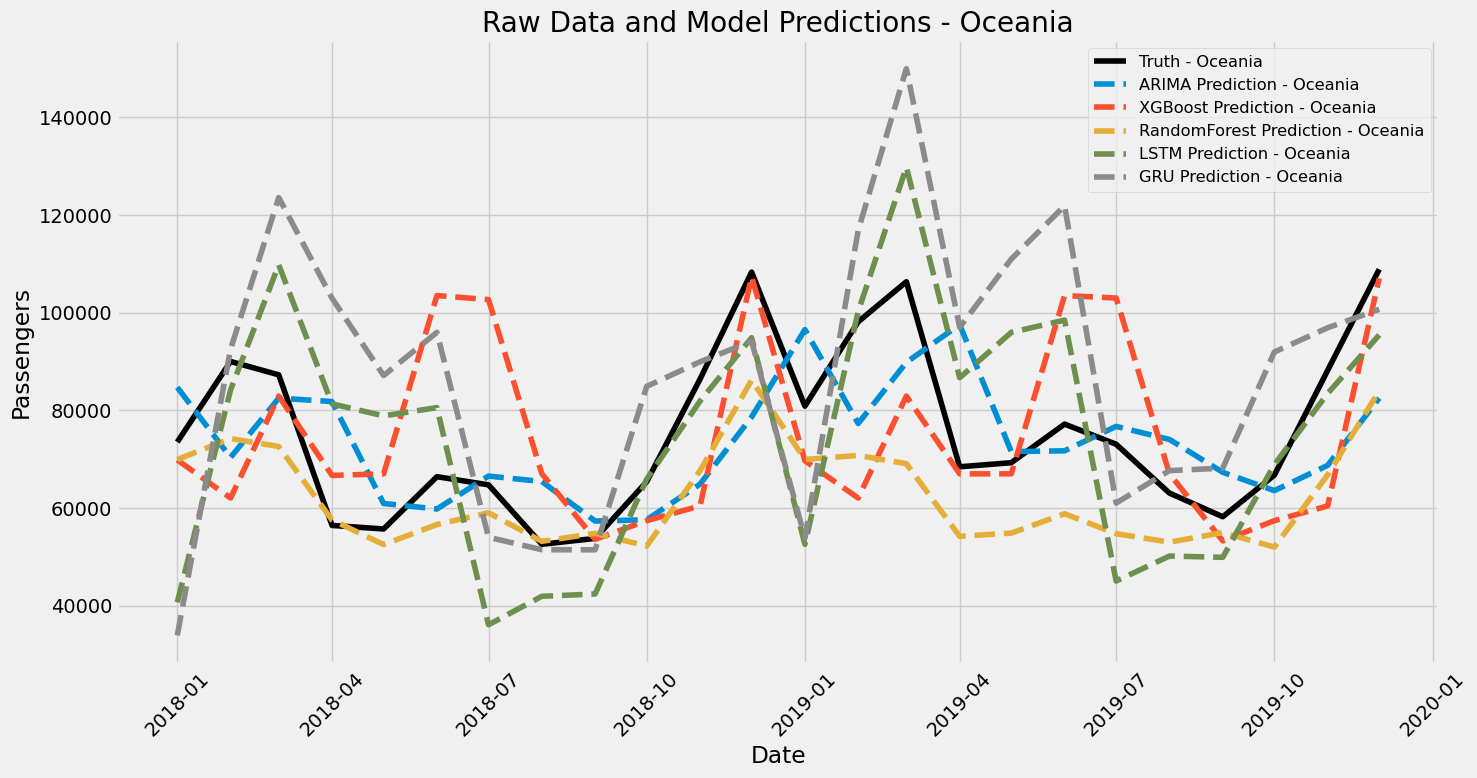

In [89]:
import numpy as np
import pandas as pd
from math import sqrt, log, pi
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
import xgboost as xgb
from tabulate import tabulate
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, GRU, Dense

pd.options.display.float_format = '{:.6f}'.format

def calculate_rmse(y_true, y_pred):
    mse = np.mean((y_true - y_pred) ** 2)
    return sqrt(mse)

def calculate_r2(y_true, y_pred):
    ss_res = np.sum((y_true - y_pred) ** 2)
    ss_tot = np.sum((y_true - np.mean(y_true)) ** 2)
    return 1 - (ss_res / ss_tot)

def calculate_mae(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred))

def calculate_mean(y_true):
    return np.mean(y_true)

def calculate_aic(y_true, y_pred, num_params):
    resid = y_true - y_pred
    sse = np.sum(resid ** 2)
    aic = 2 * num_params + len(y_true) * log(sse / len(y_true))
    return aic

def calculate_bic(y_true, y_pred, num_params):
    resid = y_true - y_pred
    sse = np.sum(resid ** 2)
    bic = num_params * log(len(y_true)) + len(y_true) * log(sse / len(y_true))
    return bic

def calculate_nrmse(y_true, y_pred):
    rmse = calculate_rmse(y_true, y_pred)
    return rmse / (np.max(y_true) - np.min(y_true))

new_pre_copy_new = test_data.copy()

region = 'Oceania'
region_train_data = train_data[train_data['Regions'] == region]
region_test_data = test_data[test_data['Regions'] == region]

# ARIMA Model
print(f"Running ARIMA model for {region}")
history = region_train_data['Passengers'].tolist()
predictions_arima = []

for t in range(len(region_test_data)):
    model = ARIMA(history, order=(1,1,1))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    predictions_arima.append(yhat)
    obs = region_test_data.iloc[t]['Passengers']
    history.append(obs)

actual = region_test_data['Passengers'].values
predicted_arima = np.array(predictions_arima)

rmse_arima = calculate_rmse(actual, predicted_arima)
r2_arima = calculate_r2(actual, predicted_arima)
mae_arima = calculate_mae(actual, predicted_arima)
mean_val_arima = calculate_mean(actual)
k_arima = 3  # Number of parameters in ARIMA(1,1,1) including constant term
aic_arima = calculate_aic(actual, predicted_arima, k_arima)
bic_arima = calculate_bic(actual, predicted_arima, k_arima)
nrmse_arima = calculate_nrmse(actual, predicted_arima)

metrics_arima = {
    'Model': 'ARIMA(1,1,1)',
    'RMSE': rmse_arima,
    'NRMSE': nrmse_arima,
    'MAE': mae_arima,
    'R^2': r2_arima,
    'AIC': aic_arima,
    'BIC': bic_arima,
    'Mean': mean_val_arima
}

region_test_data['prediction_arima'] = predictions_arima

# XGBoost Model
print(f"Running XGBoost model for {region}")
train = create_features(train_data)
test = create_features(test_data)

train = pd.get_dummies(train, columns=['Regions'])
test = pd.get_dummies(test, columns=['Regions'])

FEATURES = ['dayofyear', 'dayofweek', 'quarter', 'month', 'year'] + \
           [col for col in train.columns if 'Regions_' in col]
TARGET = 'Passengers'

X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',
                       n_estimators=1000,
                       early_stopping_rounds=50,
                       objective='reg:squarederror',
                       max_depth=3,
                       learning_rate=0.01)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=100)

test['prediction_xgb'] = reg.predict(X_test)

region_column = 'Regions_Oceania'
region_data = test[test[region_column] == 1]

actual = region_data['Passengers'].values
predicted_xgb = region_data['prediction_xgb'].values
k_xgb = len(FEATURES)

rmse_xgb, r2_xgb, mae_xgb, bic_xgb, aic_xgb, mean_actual_xgb, nrmse_xgb = (
    calculate_rmse(actual, predicted_xgb),
    calculate_r2(actual, predicted_xgb),
    calculate_mae(actual, predicted_xgb),
    calculate_bic(actual, predicted_xgb, k_xgb),
    calculate_aic(actual, predicted_xgb, k_xgb),
    calculate_mean(actual),
    calculate_nrmse(actual, predicted_xgb)
)

metrics_xgb = {
    'Model': 'XGBoost',
    'RMSE': rmse_xgb,
    'NRMSE': nrmse_xgb,
    'MAE': mae_xgb,
    'R^2': r2_xgb,
    'AIC': aic_xgb,
    'BIC': bic_xgb,
    'Mean': mean_actual_xgb
}

rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

test['prediction_rf'] = y_pred_rf

region_data_rf = test[test[region_column] == 1]

actual_rf = region_data_rf['Passengers'].values
predicted_rf = region_data_rf['prediction_rf'].values
k_rf = rf.n_estimators

rmse_rf, r2_rf, mae_rf, bic_rf, aic_rf, mean_actual_rf, nrmse_rf = (
    calculate_rmse(actual_rf, predicted_rf),
    calculate_r2(actual_rf, predicted_rf),
    calculate_mae(actual_rf, predicted_rf),
    calculate_bic(actual_rf, predicted_rf, k_rf),
    calculate_aic(actual_rf, predicted_rf, k_rf),
    calculate_mean(actual_rf),
    calculate_nrmse(actual_rf, predicted_rf)
)

metrics_rf = {
    'Model': 'RandomForest',
    'RMSE': rmse_rf,
    'NRMSE': nrmse_rf,
    'MAE': mae_rf,
    'R^2': r2_rf,
    'AIC': aic_rf,
    'BIC': bic_rf,
    'Mean': mean_actual_rf
}

# LSTM Model
print(f"Running LSTM model for {region}")

feature_scaler = MinMaxScaler(feature_range=(0, 1))
target_scaler = MinMaxScaler(feature_range=(0, 1))

X_train_scaled = feature_scaler.fit_transform(X_train)
X_test_scaled = feature_scaler.transform(X_test)

y_train_scaled = target_scaler.fit_transform(y_train.values.reshape(-1, 1))
y_test_scaled = target_scaler.transform(y_test.values.reshape(-1, 1))

X_train_reshaped = np.reshape(X_train_scaled, (X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_test_reshaped = np.reshape(X_test_scaled, (X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

lstm_model = Sequential()
lstm_model.add(LSTM(50, return_sequences=True, input_shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2])))
lstm_model.add(LSTM(50))
lstm_model.add(Dense(1))

lstm_model.compile(loss='mean_squared_error', optimizer='adam')
lstm_model.fit(X_train_reshaped, y_train_scaled, epochs=200, batch_size=32, validation_data=(X_test_reshaped, y_test_scaled), verbose=2, shuffle=False)

y_pred_lstm_scaled = lstm_model.predict(X_test_reshaped)

y_test_inv = target_scaler.inverse_transform(y_test_scaled)
y_pred_lstm_inv = target_scaler.inverse_transform(y_pred_lstm_scaled)

test['Date'] = test_data['Date']

test['prediction_lstm'] = y_pred_lstm_inv
new_pre_copy_new = new_pre_copy_new.merge(test[['Date', 'prediction_lstm']], how='left', left_index=True, right_index=True)

oceania_data = new_pre_copy_new[new_pre_copy_new['Regions'] == 'Oceania']

if not oceania_data.empty:
    oceania_data = oceania_data.dropna(subset=['Passengers', 'prediction_lstm'])

    actual = oceania_data['Passengers'].values
    predicted = oceania_data['prediction_lstm'].values

    rmse_lstm, r2_lstm, mae_lstm, mean_lstm, num_params_lstm, aic_lstm, bic_lstm, nrmse_lstm = (
        calculate_rmse(actual, predicted),
        calculate_r2(actual, predicted),
        calculate_mae(actual, predicted),
        calculate_mean(actual),
        lstm_model.count_params(),
        calculate_aic(actual, predicted, lstm_model.count_params()),
        calculate_bic(actual, predicted, lstm_model.count_params()),
        calculate_nrmse(actual, predicted)
    )

    metrics_lstm = {
        'Model': 'LSTM',
        'RMSE': rmse_lstm,
        'NRMSE': nrmse_lstm,
        'MAE': mae_lstm,
        'R^2': r2_lstm,
        'AIC': aic_lstm,
        'BIC': bic_lstm,
        'Mean': mean_lstm
    }

# GRU Model
print(f"Running GRU model for {region}")

X_train_scaled = feature_scaler.fit_transform(X_train)
X_test_scaled = feature_scaler.transform(X_test)

y_train_scaled = target_scaler.fit_transform(y_train.values.reshape(-1, 1))
y_test_scaled = target_scaler.transform(y_test.values.reshape(-1, 1))

X_train_reshaped = np.reshape(X_train_scaled, (X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_test_reshaped = np.reshape(X_test_scaled, (X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

gru_model = Sequential()
gru_model.add(GRU(50, return_sequences=True, input_shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2])))
gru_model.add(GRU(50))
gru_model.add(Dense(1))

gru_model.compile(loss='mean_squared_error', optimizer='adam')
gru_model.fit(X_train_reshaped, y_train_scaled, epochs=200, batch_size=32, validation_data=(X_test_reshaped, y_test_scaled), verbose=2, shuffle=False)

y_pred_gru_scaled = gru_model.predict(X_test_reshaped)

y_pred_gru_inv = target_scaler.inverse_transform(y_pred_gru_scaled)

test['prediction_gru'] = y_pred_gru_inv
new_pre_copy_new = new_pre_copy_new.merge(test[['Date', 'prediction_gru']], how='left', left_index=True, right_index=True)

oceania_data = new_pre_copy_new[new_pre_copy_new['Regions'] == 'Oceania']

if not oceania_data.empty:
    oceania_data = oceania_data.dropna(subset=['Passengers', 'prediction_gru'])

    actual = oceania_data['Passengers'].values
    predicted = oceania_data['prediction_gru'].values

    rmse_gru, r2_gru, mae_gru, mean_gru, num_params_gru, aic_gru, bic_gru, nrmse_gru = (
        calculate_rmse(actual, predicted),
        calculate_r2(actual, predicted),
        calculate_mae(actual, predicted),
        calculate_mean(actual),
        gru_model.count_params(),
        calculate_aic(actual, predicted, gru_model.count_params()),
        calculate_bic(actual, predicted, gru_model.count_params()),
        calculate_nrmse(actual, predicted)
    )

    metrics_gru = {
        'Model': 'GRU',
        'RMSE': rmse_gru,
        'NRMSE': nrmse_gru,
        'MAE': mae_gru,
        'R^2': r2_gru,
        'AIC': aic_gru,
        'BIC': bic_gru,
        'Mean': mean_gru
    }

metrics_df = pd.DataFrame([metrics_arima, metrics_xgb, metrics_rf, metrics_lstm, metrics_gru])

print(tabulate(metrics_df, headers="keys", tablefmt="grid"))

# Plot predictions for Oceania
plt.figure(figsize=(15, 8))
plt.plot(region_test_data['Date'], region_test_data['Passengers'], label='Truth - Oceania', color='black')
plt.plot(region_test_data['Date'], region_test_data['prediction_arima'], linestyle='--', label='ARIMA Prediction - Oceania')
plt.plot(region_data['Date'], predicted_xgb, linestyle='--', label='XGBoost Prediction - Oceania')
plt.plot(region_data_rf['Date'], predicted_rf, linestyle='--', label='RandomForest Prediction - Oceania')
plt.plot(oceania_data['Date'], oceania_data['prediction_lstm'], linestyle='--', label='LSTM Prediction - Oceania')
plt.plot(oceania_data['Date'], oceania_data['prediction_gru'], linestyle='--', label='GRU Prediction - Oceania')

plt.title('Raw Data and Model Predictions - Oceania')
plt.xlabel('Date')
plt.ylabel('Passengers')
plt.legend(loc='upper right', fontsize='small')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [90]:
metrics_df = metrics_df.round(2)

print(tabulate(metrics_df, headers="keys", tablefmt="grid"))


+----+--------------+---------+---------+---------+-------+----------+-----------+--------+
|    | Model        |    RMSE |   NRMSE |     MAE |   R^2 |      AIC |       BIC |   Mean |
+====+==============+=========+=========+=========+=======+==========+===========+========+
|  0 | ARIMA(1,1,1) | 15776   |    0.28 | 13029.5 |  0.15 |   469.98 |    473.51 |  75791 |
+----+--------------+---------+---------+---------+-------+----------+-----------+--------+
|  1 | XGBoost      | 19673.7 |    0.35 | 15029.4 | -0.33 |   500.58 |    515.89 |  75791 |
+----+--------------+---------+---------+---------+-------+----------+-----------+--------+
|  2 | RandomForest | 16308.9 |    0.29 | 13535.5 |  0.09 |   665.57 |    783.38 |  75791 |
+----+--------------+---------+---------+---------+-------+----------+-----------+--------+
|  3 | LSTM         | 18627.5 |    0.33 | 15929.1 | -0.19 | 66573.9  | 105510    |  75791 |
+----+--------------+---------+---------+---------+-------+----------+----------

## All Models for South America

Running ARIMA model for South America


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
<ipython-input-91-e4da65a8581e>:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  region_test_data['prediction_arima'] = predictions_arima
<ipython-input-76-1bc1f22e4fb8>:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,

Running XGBoost model for South America
[0]	validation_0-rmse:501260.90383	validation_1-rmse:674207.90211
[100]	validation_0-rmse:213147.72935	validation_1-rmse:376704.49299
[200]	validation_0-rmse:112930.84981	validation_1-rmse:241828.80790
[300]	validation_0-rmse:78370.03330	validation_1-rmse:185650.43711
[400]	validation_0-rmse:63964.36826	validation_1-rmse:160881.53814
[500]	validation_0-rmse:55614.56480	validation_1-rmse:146493.09532
[600]	validation_0-rmse:48768.89349	validation_1-rmse:136175.39443
[700]	validation_0-rmse:44301.20420	validation_1-rmse:129368.77021
[800]	validation_0-rmse:40759.17040	validation_1-rmse:124295.68603
[900]	validation_0-rmse:37632.40075	validation_1-rmse:120581.59527
[999]	validation_0-rmse:34954.49871	validation_1-rmse:117383.98125
Running LSTM model for South America
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


15/15 - 4s - 297ms/step - loss: 0.0405 - val_loss: 0.0643
Epoch 2/200
15/15 - 0s - 19ms/step - loss: 0.0254 - val_loss: 0.0455
Epoch 3/200
15/15 - 0s - 8ms/step - loss: 0.0192 - val_loss: 0.0355
Epoch 4/200
15/15 - 0s - 8ms/step - loss: 0.0120 - val_loss: 0.0242
Epoch 5/200
15/15 - 0s - 7ms/step - loss: 0.0067 - val_loss: 0.0148
Epoch 6/200
15/15 - 0s - 9ms/step - loss: 0.0053 - val_loss: 0.0119
Epoch 7/200
15/15 - 0s - 31ms/step - loss: 0.0051 - val_loss: 0.0114
Epoch 8/200
15/15 - 0s - 10ms/step - loss: 0.0049 - val_loss: 0.0114
Epoch 9/200
15/15 - 0s - 7ms/step - loss: 0.0048 - val_loss: 0.0112
Epoch 10/200
15/15 - 0s - 10ms/step - loss: 0.0048 - val_loss: 0.0111
Epoch 11/200
15/15 - 0s - 10ms/step - loss: 0.0047 - val_loss: 0.0110
Epoch 12/200
15/15 - 0s - 25ms/step - loss: 0.0047 - val_loss: 0.0110
Epoch 13/200
15/15 - 0s - 12ms/step - loss: 0.0047 - val_loss: 0.0109
Epoch 14/200
15/15 - 0s - 11ms/step - loss: 0.0047 - val_loss: 0.0109
Epoch 15/200
15/15 - 0s - 11ms/step - loss: 0

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


15/15 - 6s - 368ms/step - loss: 0.0313 - val_loss: 0.0435
Epoch 2/200
15/15 - 0s - 25ms/step - loss: 0.0161 - val_loss: 0.0298
Epoch 3/200
15/15 - 1s - 38ms/step - loss: 0.0079 - val_loss: 0.0171
Epoch 4/200
15/15 - 0s - 7ms/step - loss: 0.0050 - val_loss: 0.0126
Epoch 5/200
15/15 - 0s - 8ms/step - loss: 0.0050 - val_loss: 0.0121
Epoch 6/200
15/15 - 1s - 80ms/step - loss: 0.0050 - val_loss: 0.0124
Epoch 7/200
15/15 - 0s - 7ms/step - loss: 0.0049 - val_loss: 0.0125
Epoch 8/200
15/15 - 0s - 6ms/step - loss: 0.0049 - val_loss: 0.0124
Epoch 9/200
15/15 - 0s - 28ms/step - loss: 0.0049 - val_loss: 0.0124
Epoch 10/200
15/15 - 0s - 11ms/step - loss: 0.0048 - val_loss: 0.0123
Epoch 11/200
15/15 - 0s - 9ms/step - loss: 0.0048 - val_loss: 0.0122
Epoch 12/200
15/15 - 0s - 6ms/step - loss: 0.0048 - val_loss: 0.0121
Epoch 13/200
15/15 - 0s - 12ms/step - loss: 0.0048 - val_loss: 0.0121
Epoch 14/200
15/15 - 0s - 8ms/step - loss: 0.0047 - val_loss: 0.0120
Epoch 15/200
15/15 - 0s - 10ms/step - loss: 0.0

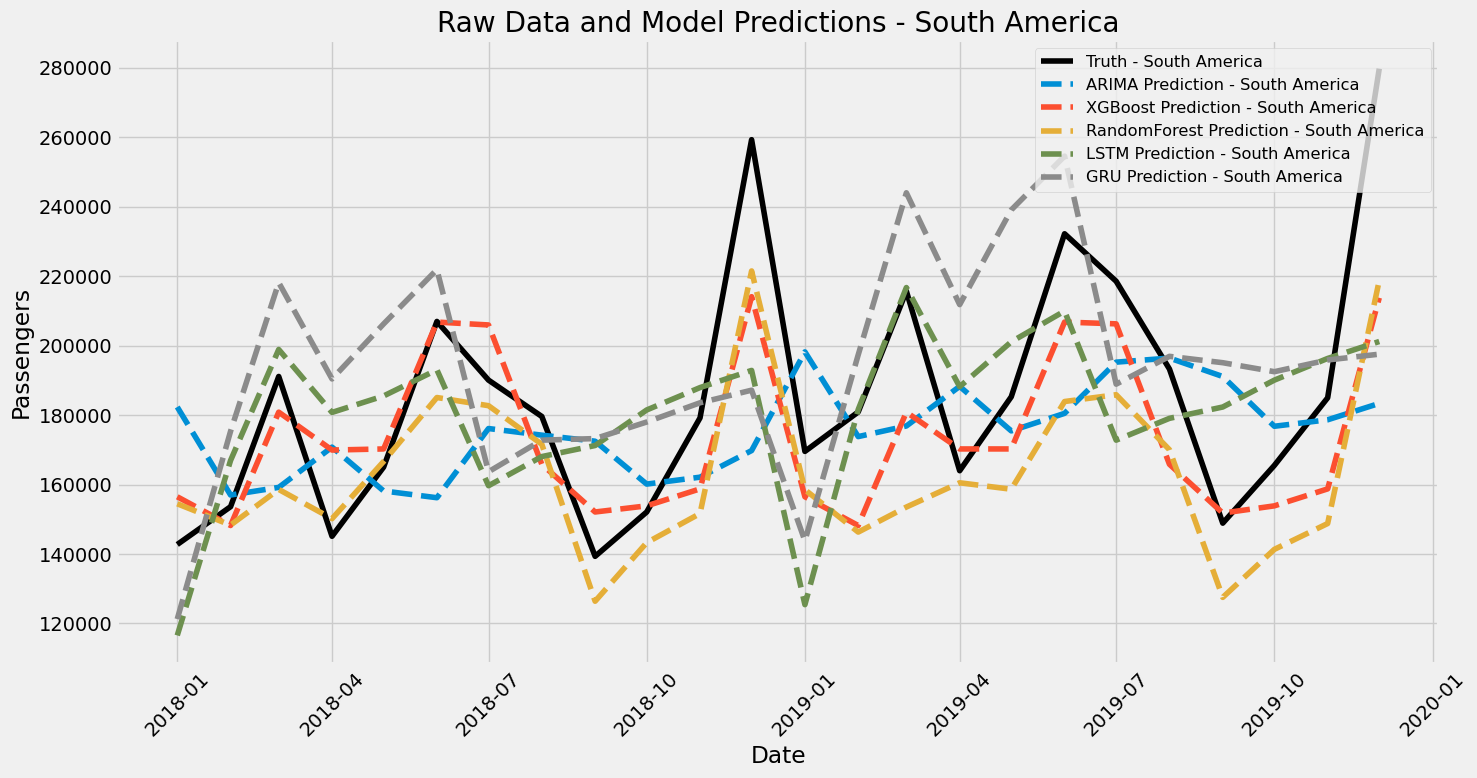

In [91]:
import numpy as np
import pandas as pd
from math import sqrt, log, pi
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
import xgboost as xgb
from tabulate import tabulate
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, GRU, Dense

pd.options.display.float_format = '{:.6f}'.format

# Metric Calculation Functions
def calculate_rmse(y_true, y_pred):
    mse = np.mean((y_true - y_pred) ** 2)
    return sqrt(mse)

def calculate_r2(y_true, y_pred):
    ss_res = np.sum((y_true - y_pred) ** 2)
    ss_tot = np.sum((y_true - np.mean(y_true)) ** 2)
    return 1 - (ss_res / ss_tot)

def calculate_mae(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred))

def calculate_mean(y_true):
    return np.mean(y_true)

def calculate_aic(y_true, y_pred, num_params):
    resid = y_true - y_pred
    sse = np.sum(resid ** 2)
    aic = 2 * num_params + len(y_true) * log(sse / len(y_true))
    return aic

def calculate_bic(y_true, y_pred, num_params):
    resid = y_true - y_pred
    sse = np.sum(resid ** 2)
    bic = num_params * log(len(y_true)) + len(y_true) * log(sse / len(y_true))
    return bic

def calculate_nrmse(y_true, y_pred):
    rmse = calculate_rmse(y_true, y_pred)
    return rmse / (np.max(y_true) - np.min(y_true))

# Make a copy of test_data to use for merging predictions later
new_pre_copy_new = test_data.copy()

region = 'South America'
region_train_data = train_data[train_data['Regions'] == region]
region_test_data = test_data[test_data['Regions'] == region]

# ARIMA Model
print(f"Running ARIMA model for {region}")
history = region_train_data['Passengers'].tolist()
predictions_arima = []

for t in range(len(region_test_data)):
    model = ARIMA(history, order=(1,1,1))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    predictions_arima.append(yhat)
    obs = region_test_data.iloc[t]['Passengers']
    history.append(obs)

actual = region_test_data['Passengers'].values
predicted_arima = np.array(predictions_arima)

rmse_arima = calculate_rmse(actual, predicted_arima)
r2_arima = calculate_r2(actual, predicted_arima)
mae_arima = calculate_mae(actual, predicted_arima)
mean_val_arima = calculate_mean(actual)
k_arima = 3  # Number of parameters in ARIMA(1,1,1) including constant term
aic_arima = calculate_aic(actual, predicted_arima, k_arima)
bic_arima = calculate_bic(actual, predicted_arima, k_arima)
nrmse_arima = calculate_nrmse(actual, predicted_arima)

metrics_arima = {
    'Model': 'ARIMA(1,1,1)',
    'RMSE': rmse_arima,
    'NRMSE': nrmse_arima,
    'MAE': mae_arima,
    'R^2': r2_arima,
    'AIC': aic_arima,
    'BIC': bic_arima,
    'Mean': mean_val_arima
}

region_test_data['prediction_arima'] = predictions_arima

# XGBoost Model
print(f"Running XGBoost model for {region}")
train = create_features(train_data)
test = create_features(test_data)

train = pd.get_dummies(train, columns=['Regions'])
test = pd.get_dummies(test, columns=['Regions'])

FEATURES = ['dayofyear', 'dayofweek', 'quarter', 'month', 'year'] + \
           [col for col in train.columns if 'Regions_' in col]
TARGET = 'Passengers'

X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',
                       n_estimators=1000,
                       early_stopping_rounds=50,
                       objective='reg:squarederror',
                       max_depth=3,
                       learning_rate=0.01)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=100)

test['prediction_xgb'] = reg.predict(X_test)

region_column = 'Regions_South America'
region_data = test[test[region_column] == 1]

actual = region_data['Passengers'].values
predicted_xgb = region_data['prediction_xgb'].values
k_xgb = len(FEATURES)

rmse_xgb, r2_xgb, mae_xgb, bic_xgb, aic_xgb, mean_actual_xgb, nrmse_xgb = (
    calculate_rmse(actual, predicted_xgb),
    calculate_r2(actual, predicted_xgb),
    calculate_mae(actual, predicted_xgb),
    calculate_bic(actual, predicted_xgb, k_xgb),
    calculate_aic(actual, predicted_xgb, k_xgb),
    calculate_mean(actual),
    calculate_nrmse(actual, predicted_xgb)
)

metrics_xgb = {
    'Model': 'XGBoost',
    'RMSE': rmse_xgb,
    'NRMSE': nrmse_xgb,
    'MAE': mae_xgb,
    'R^2': r2_xgb,
    'AIC': aic_xgb,
    'BIC': bic_xgb,
    'Mean': mean_actual_xgb
}

# Random Forest model
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

test['prediction_rf'] = y_pred_rf

region_data_rf = test[test[region_column] == 1]

actual_rf = region_data_rf['Passengers'].values
predicted_rf = region_data_rf['prediction_rf'].values
k_rf = rf.n_estimators

rmse_rf, r2_rf, mae_rf, bic_rf, aic_rf, mean_actual_rf, nrmse_rf = (
    calculate_rmse(actual_rf, predicted_rf),
    calculate_r2(actual_rf, predicted_rf),
    calculate_mae(actual_rf, predicted_rf),
    calculate_bic(actual_rf, predicted_rf, k_rf),
    calculate_aic(actual_rf, predicted_rf, k_rf),
    calculate_mean(actual_rf),
    calculate_nrmse(actual_rf, predicted_rf)
)

metrics_rf = {
    'Model': 'RandomForest',
    'RMSE': rmse_rf,
    'NRMSE': nrmse_rf,
    'MAE': mae_rf,
    'R^2': r2_rf,
    'AIC': aic_rf,
    'BIC': bic_rf,
    'Mean': mean_actual_rf
}

# LSTM Model
print(f"Running LSTM model for {region}")

feature_scaler = MinMaxScaler(feature_range=(0, 1))
target_scaler = MinMaxScaler(feature_range=(0, 1))

X_train_scaled = feature_scaler.fit_transform(X_train)
X_test_scaled = feature_scaler.transform(X_test)

y_train_scaled = target_scaler.fit_transform(y_train.values.reshape(-1, 1))
y_test_scaled = target_scaler.transform(y_test.values.reshape(-1, 1))

X_train_reshaped = np.reshape(X_train_scaled, (X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_test_reshaped = np.reshape(X_test_scaled, (X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

lstm_model = Sequential()
lstm_model.add(LSTM(50, return_sequences=True, input_shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2])))
lstm_model.add(LSTM(50))
lstm_model.add(Dense(1))

lstm_model.compile(loss='mean_squared_error', optimizer='adam')
lstm_model.fit(X_train_reshaped, y_train_scaled, epochs=200, batch_size=32, validation_data=(X_test_reshaped, y_test_scaled), verbose=2, shuffle=False)

y_pred_lstm_scaled = lstm_model.predict(X_test_reshaped)

y_test_inv = target_scaler.inverse_transform(y_test_scaled)
y_pred_lstm_inv = target_scaler.inverse_transform(y_pred_lstm_scaled)

test['Date'] = test_data['Date']

test['prediction_lstm'] = y_pred_lstm_inv
new_pre_copy_new = new_pre_copy_new.merge(test[['Date', 'prediction_lstm']], how='left', left_index=True, right_index=True)

south_america_data = new_pre_copy_new[new_pre_copy_new['Regions'] == 'South America']

if not south_america_data.empty:
    south_america_data = south_america_data.dropna(subset=['Passengers', 'prediction_lstm'])

    actual = south_america_data['Passengers'].values
    predicted = south_america_data['prediction_lstm'].values

    rmse_lstm, r2_lstm, mae_lstm, mean_lstm, num_params_lstm, aic_lstm, bic_lstm, nrmse_lstm = (
        calculate_rmse(actual, predicted),
        calculate_r2(actual, predicted),
        calculate_mae(actual, predicted),
        calculate_mean(actual),
        lstm_model.count_params(),
        calculate_aic(actual, predicted, lstm_model.count_params()),
        calculate_bic(actual, predicted, lstm_model.count_params()),
        calculate_nrmse(actual, predicted)
    )

    metrics_lstm = {
        'Model': 'LSTM',
        'RMSE': rmse_lstm,
        'NRMSE': nrmse_lstm,
        'MAE': mae_lstm,
        'R^2': r2_lstm,
        'AIC': aic_lstm,
        'BIC': bic_lstm,
        'Mean': mean_lstm
    }

# GRU Model
print(f"Running GRU model for {region}")
X_train_scaled = feature_scaler.fit_transform(X_train)
X_test_scaled = feature_scaler.transform(X_test)

y_train_scaled = target_scaler.fit_transform(y_train.values.reshape(-1, 1))
y_test_scaled = target_scaler.transform(y_test.values.reshape(-1, 1))

X_train_reshaped = np.reshape(X_train_scaled, (X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_test_reshaped = np.reshape(X_test_scaled, (X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

gru_model = Sequential()
gru_model.add(GRU(50, return_sequences=True, input_shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2])))
gru_model.add(GRU(50))
gru_model.add(Dense(1))

gru_model.compile(loss='mean_squared_error', optimizer='adam')
gru_model.fit(X_train_reshaped, y_train_scaled, epochs=200, batch_size=32, validation_data=(X_test_reshaped, y_test_scaled), verbose=2, shuffle=False)

y_pred_gru_scaled = gru_model.predict(X_test_reshaped)

y_pred_gru_inv = target_scaler.inverse_transform(y_pred_gru_scaled)

test['prediction_gru'] = y_pred_gru_inv
new_pre_copy_new = new_pre_copy_new.merge(test[['Date', 'prediction_gru']], how='left', left_index=True, right_index=True)

south_america_data = new_pre_copy_new[new_pre_copy_new['Regions'] == 'South America']

if not south_america_data.empty:
    south_america_data = south_america_data.dropna(subset=['Passengers', 'prediction_gru'])

    actual = south_america_data['Passengers'].values
    predicted = south_america_data['prediction_gru'].values

    rmse_gru, r2_gru, mae_gru, mean_gru, num_params_gru, aic_gru, bic_gru, nrmse_gru = (
        calculate_rmse(actual, predicted),
        calculate_r2(actual, predicted),
        calculate_mae(actual, predicted),
        calculate_mean(actual),
        gru_model.count_params(),
        calculate_aic(actual, predicted, gru_model.count_params()),
        calculate_bic(actual, predicted, gru_model.count_params()),
        calculate_nrmse(actual, predicted)
    )

    metrics_gru = {
        'Model': 'GRU',
        'RMSE': rmse_gru,
        'NRMSE': nrmse_gru,
        'MAE': mae_gru,
        'R^2': r2_gru,
        'AIC': aic_gru,
        'BIC': bic_gru,
        'Mean': mean_gru
    }

metrics_df = pd.DataFrame([metrics_arima, metrics_xgb, metrics_rf, metrics_lstm, metrics_gru])

print(tabulate(metrics_df, headers="keys", tablefmt="grid"))

# Plot predictions for South America
plt.figure(figsize=(15, 8))
plt.plot(region_test_data['Date'], region_test_data['Passengers'], label='Truth - South America', color='black')
plt.plot(region_test_data['Date'], region_test_data['prediction_arima'], linestyle='--', label='ARIMA Prediction - South America')
plt.plot(region_data['Date'], predicted_xgb, linestyle='--', label='XGBoost Prediction - South America')
plt.plot(region_data_rf['Date'], predicted_rf, linestyle='--', label='RandomForest Prediction - South America')
plt.plot(south_america_data['Date'], south_america_data['prediction_lstm'], linestyle='--', label='LSTM Prediction - South America')
plt.plot(south_america_data['Date'], south_america_data['prediction_gru'], linestyle='--', label='GRU Prediction - South America')

plt.title('Raw Data and Model Predictions - South America')
plt.xlabel('Date')
plt.ylabel('Passengers')
plt.legend(loc='upper right', fontsize='small')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [92]:
metrics_df = metrics_df.round(2)

print(tabulate(metrics_df, headers="keys", tablefmt="grid"))


+----+--------------+---------+---------+---------+-------+----------+-----------+--------+
|    | Model        |    RMSE |   NRMSE |     MAE |   R^2 |      AIC |       BIC |   Mean |
+====+==============+=========+=========+=========+=======+==========+===========+========+
|  0 | ARIMA(1,1,1) | 37132   |    0.26 | 27842.2 | -0.11 |   511.07 |    514.6  | 185103 |
+----+--------------+---------+---------+---------+-------+----------+-----------+--------+
|  1 | XGBoost      | 23702.4 |    0.17 | 18465.6 |  0.55 |   509.52 |    524.83 | 185103 |
+----+--------------+---------+---------+---------+-------+----------+-----------+--------+
|  2 | RandomForest | 29000.9 |    0.21 | 23552.7 |  0.32 |   693.2  |    811.01 | 185103 |
+----+--------------+---------+---------+---------+-------+----------+-----------+--------+
|  3 | LSTM         | 31506.4 |    0.22 | 25483.4 |  0.2  | 66599.2  | 105535    | 185103 |
+----+--------------+---------+---------+---------+-------+----------+----------

## Results

## Forecast on Test Data

In [ ]:
test['prediction'] = reg.predict(X_test)

new_pre_copy_new = new_pre_copy.merge(test[['prediction']], how='left', left_index=True, right_index=True)

ax = new_pre_copy_new.plot(x='Date', y='Passengers', figsize=(15, 5), label='Truth Data')
new_pre_copy_new.plot(x='Date', y='prediction', ax=ax, style='--', label='Predictions')

plt.legend()
ax.set_title('Raw Data and XGBoost Prediction')
plt.xlabel('Date')
plt.ylabel('Passengers')
plt.grid(True)
plt.show()

### With Regions

In [ ]:
fig, ax = plt.subplots(figsize=(15, 8))

for region in new_pre_copy_new['Regions'].unique():
    region_data = new_pre_copy_new[new_pre_copy_new['Regions'] == region]
    region_data.plot(x='Date', y='Passengers', ax=ax, label=f'Truth - {region}')
    region_data.plot(x='Date', y='prediction', ax=ax, style='--', label=f'Prediction - {region}')
plt.legend(loc='upper left', fontsize='small', ncol=2)
ax.set_title('Raw Data and XGBoost Prediction by Region')
plt.xlabel('Date')
plt.ylabel('Passengers')
plt.grid(True)
plt.gcf().autofmt_xdate()
plt.show()

### Score (RMSE)

In [ ]:
score = np.sqrt(mean_squared_error(test['Passengers'], test['prediction']))
print(f'XGBoost RMSE Score on Test set: {score:0.2f}')
print(f'XGBoost R2 Score on Test set: {r2_score(test["Passengers"], test["prediction"]):0.2f}')
print(f'XGBoost MAE Score on Test set: {mean_absolute_error(test["Passengers"], test["prediction"]):0.2f}')

In [ ]:
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import xgboost as xgb

reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',
                       n_estimators=1000,
                       early_stopping_rounds=50,
                       objective='reg:linear',
                       max_depth=3,
                       learning_rate=0.01)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=100)

test['prediction'] = reg.predict(X_test)

rss = np.sum((test['Passengers'] - test['prediction']) ** 2)

n = len(test)

sigma2 = rss / n

log_likelihood = -n / 2 * (np.log(2 * np.pi * sigma2) + 1)

k = reg.n_estimators * X_train.shape[1]

aic = 2 * k - 2 * log_likelihood
bic = k * np.log(n) - 2 * log_likelihood

print(f'XGBoost AIC: {aic:0.2f}')
print(f'XGBoost BIC: {bic:0.2f}')

rmse = np.sqrt(mean_squared_error(test['Passengers'], test['prediction']))
mae = mean_absolute_error(test['Passengers'], test['prediction'])
r2 = r2_score(test['Passengers'], test['prediction'])

print(f'RMSE: {rmse}')
print(f'MAE: {mae}')
print(f'R²: {r2}')

## BIC&AIC  INCLUSIVE

In [ ]:
import numpy as np
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt
from math import sqrt, log
from tabulate import tabulate

train = create_features(train_data)
test = create_features(test_data)

train = pd.get_dummies(train, columns=['Regions'])
test = pd.get_dummies(test, columns=['Regions'])

FEATURES = ['dayofyear', 'dayofweek', 'quarter', 'month', 'year'] + \
           [col for col in train.columns if 'Regions_' in col]
TARGET = 'Passengers'

X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',
                       n_estimators=1000,
                       early_stopping_rounds=50,
                       objective='reg:linear',
                       max_depth=3,
                       learning_rate=0.01)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=100)

test['prediction'] = reg.predict(X_test)

regions = [col for col in test.columns if 'Regions_' in col]

def calculate_metrics(actual, predicted, n, k):
    residuals = actual - predicted
    mse = np.mean(residuals ** 2)
    rmse = sqrt(mse)
    mae = np.mean(np.abs(residuals))
    mean_actual = np.mean(actual)
    ss_total = np.sum((actual - mean_actual) ** 2)
    ss_res = np.sum(residuals ** 2)
    r2 = 1 - (ss_res / ss_total)
    bic = n * log(mse) + k * log(n)
    aic = n * log(mse) + 2 * k
    nrmse = rmse / (np.max(actual) - np.min(actual))
    return rmse, r2, mae, bic, aic, mean_actual, nrmse

headers = ["Region", "RMSE", "R2", "MAE", "BIC", "AIC", "Mean", "NRMSE"]
rows = []

for region in regions:
    region_name = region.split('_')[1]
    region_data = test[test[region] == 1]

    if not region_data.empty:
        actual = region_data['Passengers'].values
        predicted = region_data['prediction'].values
        n = len(actual)
        k = len(FEATURES)

        rmse, r2, mae, bic, aic, mean_actual, nrmse = calculate_metrics(actual, predicted, n, k)

        rows.append([region_name, f'{rmse:0.2f}', f'{r2:0.2f}', f'{mae:0.2f}', f'{bic:0.2f}', f'{aic:0.2f}', f'{mean_actual:0.2f}', f'{nrmse:0.2f}'])

        fig, ax = plt.subplots(figsize=(15, 8))
        region_data.plot(x='Date', y='Passengers', ax=ax, label=f'Truth - {region_name}')
        region_data.plot(x='Date', y='prediction', ax=ax, style='--', label=f'Prediction - {region_name}')
        plt.legend(loc='upper left', fontsize='small', ncol=2)
        ax.set_title(f'Raw Data and XGBoost Prediction for {region_name}')
        plt.xlabel('Date')
        plt.ylabel('Passengers')
        plt.grid(True)
        plt.gcf().autofmt_xdate()
        plt.show()

print(tabulate(rows, headers, tablefmt="grid"))

### Error Calculation

- Now I want to look at the worst and best predicted days

In [ ]:
test['error'] = np.abs(test[TARGET] - test['prediction'])
test.groupby(['Date'])['error'].mean().sort_values(ascending=False)

## Random Forest Model

In [ ]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Random Forest RMSE: {rmse}")

r2 = r2_score(y_test, y_pred)
print(f"Random Forest R2: {r2}")

mae = mean_absolute_error(y_test, y_pred)
print(f"Random Forest MAE: {mae}")

test['prediction'] = y_pred
new_pre_copy_new = new_pre_copy.merge(test[['prediction']], how='left', left_index=True, right_index=True)

ax = new_pre_copy_new.plot(x='Date', y='Passengers', figsize=(15, 5), label='Truth Data')
new_pre_copy_new.plot(x='Date', y='prediction', ax=ax, style='--', label='Predictions')

plt.legend()
ax.set_title('Raw Data and Random Forest Prediction')
plt.xlabel('Date')
plt.ylabel('Passengers')
plt.grid(True)
plt.show()

fig, ax = plt.subplots(figsize=(15, 8))

for region in new_pre_copy_new['Regions'].unique():
    region_data = new_pre_copy_new[new_pre_copy_new['Regions'] == region]
    region_data.plot(x='Date', y='Passengers', ax=ax, label=f'Truth - {region}')
    region_data.plot(x='Date', y='prediction', ax=ax, style='--', label=f'Prediction - {region}')

plt.legend(loc='upper left', fontsize='small', ncol=2)
ax.set_title('Raw Data and Random Forest Prediction by Region')
plt.xlabel('Date')
plt.ylabel('Passengers')
plt.grid(True)
plt.gcf().autofmt_xdate()
plt.show()

### Random Forest AIC & BIC Included

In [ ]:
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error


rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Random Forest RMSE: {rmse}")

r2 = r2_score(y_test, y_pred)
print(f"Random Forest R2: {r2}")

mae = mean_absolute_error(y_test, y_pred)
print(f"Random Forest MAE: {mae}")

rss = np.sum((y_test - y_pred) ** 2)

n = len(y_test)

sigma2 = rss / n

log_likelihood = -n / 2 * (np.log(2 * np.pi * sigma2) + 1)


k = rf.n_estimators * X_train.shape[1]

aic = 2 * k - 2 * log_likelihood

bic = k * np.log(n) - 2 * log_likelihood

print(f'Random Forest AIC: {aic:0.2f}')
print(f'Random Forest BIC: {bic:0.2f}')

## AIC & BIC INCLUDED

In [ ]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
from math import sqrt, log
from tabulate import tabulate

rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

test['prediction'] = y_pred
new_pre_copy_new = new_pre_copy.merge(test[['prediction']], how='left', left_index=True, right_index=True)


def calculate_rmse(y_true, y_pred):
    mse = np.mean((y_true - y_pred) ** 2)
    return sqrt(mse)

def calculate_r2(y_true, y_pred):
    ss_res = np.sum((y_true - y_pred) ** 2)
    ss_tot = np.sum((y_true - np.mean(y_true)) ** 2)
    return 1 - (ss_res / ss_tot)

def calculate_mae(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred))

def calculate_mean(y_true):
    return np.mean(y_true)

def calculate_aic(y_true, y_pred, num_params):
    resid = y_true - y_pred
    sse = np.sum(resid ** 2)
    aic = 2 * num_params + len(y_true) * log(sse / len(y_true))
    return aic

def calculate_bic(y_true, y_pred, num_params):
    resid = y_true - y_pred
    sse = np.sum(resid ** 2)
    bic = num_params * log(len(y_true)) + len(y_true) * log(sse / len(y_true))
    return bic

def calculate_nrmse(y_true, y_pred):
    rmse = calculate_rmse(y_true, y_pred)
    mean_y_true = calculate_mean(y_true)
    return rmse / mean_y_true

metrics_list = []

fig, ax = plt.subplots(figsize=(15, 8))

for region in new_pre_copy_new['Regions'].unique():
    region_data = new_pre_copy_new[new_pre_copy_new['Regions'] == region]

    if not region_data.empty:
        region_data = region_data.dropna(subset=['Passengers', 'prediction'])

        actual = region_data['Passengers'].values
        predicted = region_data['prediction'].values

        if len(actual) > 0 and len(predicted) > 0:
            rmse = calculate_rmse(actual, predicted)
            r2 = calculate_r2(actual, predicted)
            mae = calculate_mae(actual, predicted)
            mean = calculate_mean(actual)
            num_params = rf.n_estimators
            aic = calculate_aic(actual, predicted, num_params)
            bic = calculate_bic(actual, predicted, num_params)
            nrmse = calculate_nrmse(actual, predicted)

            metrics_list.append([
                region,
                rmse,
                r2,
                mae,
                mean,
                aic,
                bic,
                nrmse
            ])

            region_data.plot(x='Date', y='Passengers', ax=ax, label=f'Truth - {region}')
            region_data.plot(x='Date', y='prediction', ax=ax, style='--', label=f'Prediction - {region}')

headers = ['Region', 'RMSE', 'R2', 'MAE', 'Mean', 'AIC', 'BIC', 'NRMSE']

print(tabulate(metrics_list, headers=headers, tablefmt='grid'))

plt.legend(loc='upper left', fontsize='small', ncol=2)
ax.set_title('Raw Data and Random Forest Prediction by Region')
plt.xlabel('Date')
plt.ylabel('Passengers')
plt.grid(True)
plt.gcf().autofmt_xdate()
plt.show()

## Deep Learning Approaches
- LSTM
- GRU

## LSTM

In [ ]:
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

y_train_array = y_train.values if isinstance(y_train, pd.Series) else y_train
y_test_array = y_test.values if isinstance(y_test, pd.Series) else y_test

feature_scaler = MinMaxScaler(feature_range=(0, 1))
target_scaler = MinMaxScaler(feature_range=(0, 1))

X_train_scaled = feature_scaler.fit_transform(X_train)
X_test_scaled = feature_scaler.transform(X_test)

y_train_scaled = target_scaler.fit_transform(y_train_array.reshape(-1, 1))
y_test_scaled = target_scaler.transform(y_test_array.reshape(-1, 1))

X_train_reshaped = np.reshape(X_train_scaled, (X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_test_reshaped = np.reshape(X_test_scaled, (X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2])))
model.add(LSTM(50))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(X_train_reshaped, y_train_scaled, epochs=200, batch_size=32, validation_data=(X_test_reshaped, y_test_scaled), verbose=2, shuffle=False)

y_pred_scaled = model.predict(X_test_reshaped)

y_test_inv = target_scaler.inverse_transform(y_test_scaled)
y_pred_inv = target_scaler.inverse_transform(y_pred_scaled)

rmse = np.sqrt(mean_squared_error(y_test_inv, y_pred_inv))
mae = mean_absolute_error(y_test_inv, y_pred_inv)
r2 = r2_score(y_test_inv, y_pred_inv)

print(f'RMSE: {rmse}')
print(f'MAE: {mae}')
print(f'R²: {r2}')

test['prediction'] = y_pred_inv
new_pre_copy_new = new_pre_copy.merge(test[['prediction']], how='left', left_index=True, right_index=True)

plt.figure(figsize=(14, 5))
plt.plot(y_test_inv, label='Actual')
plt.plot(y_pred_inv, label='Predicted')
plt.title('Actual vs LSTM Predicted Passengers')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()

fig, ax = plt.subplots(figsize=(15, 8))

for region in new_pre_copy_new['Regions'].unique():
    region_data = new_pre_copy_new[new_pre_copy_new['Regions'] == region]
    region_data.plot(x='Date', y='Passengers', ax=ax, label=f'Truth - {region}')
    region_data.plot(x='Date', y='prediction', ax=ax, style='--', label=f'Prediction - {region}')

plt.legend(loc='upper left', fontsize='small', ncol=2)
ax.set_title('Raw Data and LSTM Prediction by Region')
plt.xlabel('Date')
plt.ylabel('Passengers')
plt.grid(True)
plt.gcf().autofmt_xdate()
plt.show()

### LSTM AIC & BIC Included

In [ ]:
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

y_train_array = y_train.values if isinstance(y_train, pd.Series) else y_train
y_test_array = y_test.values if isinstance(y_test, pd.Series) else y_test

feature_scaler = MinMaxScaler(feature_range=(0, 1))
target_scaler = MinMaxScaler(feature_range=(0, 1))

X_train_scaled = feature_scaler.fit_transform(X_train)
X_test_scaled = feature_scaler.transform(X_test)

y_train_scaled = target_scaler.fit_transform(y_train_array.reshape(-1, 1))
y_test_scaled = target_scaler.transform(y_test_array.reshape(-1, 1))

X_train_reshaped = np.reshape(X_train_scaled, (X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_test_reshaped = np.reshape(X_test_scaled, (X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2])))
model.add(LSTM(50))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(X_train_reshaped, y_train_scaled, epochs=200, batch_size=32, validation_data=(X_test_reshaped, y_test_scaled), verbose=2, shuffle=False)

y_pred_scaled = model.predict(X_test_reshaped)

y_test_inv = target_scaler.inverse_transform(y_test_scaled)
y_pred_inv = target_scaler.inverse_transform(y_pred_scaled)

rmse = np.sqrt(mean_squared_error(y_test_inv, y_pred_inv))
mae = mean_absolute_error(y_test_inv, y_pred_inv)
r2 = r2_score(y_test_inv, y_pred_inv)

print(f'RMSE: {rmse}')
print(f'MAE: {mae}')
print(f'R²: {r2}')

rss = np.sum((y_test_inv - y_pred_inv) ** 2)

n = len(y_test_inv)

sigma2 = rss / n

log_likelihood = -n / 2 * (np.log(2 * np.pi * sigma2) + 1)

k = model.count_params()

aic = 2 * k - 2 * log_likelihood

bic = k * np.log(n) - 2 * log_likelihood

print(f'LSTM AIC: {aic:0.2f}')
print(f'LSTM BIC: {bic:0.2f}')

test['prediction'] = y_pred_inv
new_pre_copy_new = new_pre_copy.merge(test[['prediction']], how='left', left_index=True, right_index=True)

plt.figure(figsize=(14, 5))
plt.plot(y_test_inv, label='Actual')
plt.plot(y_pred_inv, label='Predicted')
plt.title('Actual vs LSTM Predicted Passengers')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()

fig, ax = plt.subplots(figsize=(15, 8))

for region in new_pre_copy_new['Regions'].unique():
    region_data = new_pre_copy_new[new_pre_copy_new['Regions'] == region]
    region_data.plot(x='Date', y='Passengers', ax=ax, label=f'Truth - {region}')
    region_data.plot(x='Date', y='prediction', ax=ax, style='--', label=f'Prediction - {region}')

plt.legend(loc='upper left', fontsize='small', ncol=2)
ax.set_title('Raw Data and LSTM Prediction by Region')
plt.xlabel('Date')
plt.ylabel('Passengers')
plt.grid(True)
plt.gcf().autofmt_xdate()
plt.show()

In [ ]:
# lmean_actual = 375939.8
# lrmse = 103053.31073488624

# lrelative_rmse = (lrmse / lmean_actual) * 100
# print(f'Relative RMSE: {lrelative_rmse:.2f}%')

## Full code Tablulated Metrics

In [ ]:
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import sqrt, log
from tabulate import tabulate

y_train_array = y_train.values if isinstance(y_train, pd.Series) else y_train
y_test_array = y_test.values if isinstance(y_test, pd.Series) else y_test

feature_scaler = MinMaxScaler(feature_range=(0, 1))
target_scaler = MinMaxScaler(feature_range=(0, 1))

X_train_scaled = feature_scaler.fit_transform(X_train)
X_test_scaled = feature_scaler.transform(X_test)

y_train_scaled = target_scaler.fit_transform(y_train_array.reshape(-1, 1))
y_test_scaled = target_scaler.transform(y_test_array.reshape(-1, 1))

X_train_reshaped = np.reshape(X_train_scaled, (X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_test_reshaped = np.reshape(X_test_scaled, (X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2])))
model.add(LSTM(50))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(X_train_reshaped, y_train_scaled, epochs=200, batch_size=32, validation_data=(X_test_reshaped, y_test_scaled), verbose=2, shuffle=False)

y_pred_scaled = model.predict(X_test_reshaped)

y_test_inv = target_scaler.inverse_transform(y_test_scaled)
y_pred_inv = target_scaler.inverse_transform(y_pred_scaled)

def calculate_rmse(y_true, y_pred):
    mse = np.mean((y_true - y_pred) ** 2)
    return sqrt(mse)

def calculate_r2(y_true, y_pred):
    ss_res = np.sum((y_true - y_pred) ** 2)
    ss_tot = np.sum((y_true - np.mean(y_true)) ** 2)
    return 1 - (ss_res / ss_tot)

def calculate_mae(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred))

def calculate_mean(y_true):
    return np.mean(y_true)

def calculate_aic(y_true, y_pred, num_params):
    resid = y_true - y_pred
    sse = np.sum(resid ** 2)
    aic = 2 * num_params + len(y_true) * log(sse / len(y_true))
    return aic

def calculate_bic(y_true, y_pred, num_params):
    resid = y_true - y_pred
    sse = np.sum(resid ** 2)
    bic = num_params * log(len(y_true)) + len(y_true) * log(sse / len(y_true))
    return bic

def calculate_nrmse(y_true, y_pred):
    rmse = calculate_rmse(y_true, y_pred)
    return rmse / (np.max(y_true) - np.min(y_true))

metrics_list = []

test['prediction'] = y_pred_inv
new_pre_copy_new = new_pre_copy.merge(test[['prediction']], how='left', left_index=True, right_index=True)

for region in new_pre_copy_new['Regions'].unique():
    region_data = new_pre_copy_new[new_pre_copy_new['Regions'] == region]

    if not region_data.empty:
        region_data = region_data.dropna(subset=['Passengers', 'prediction'])

        actual = region_data['Passengers'].values
        predicted = region_data['prediction'].values

        if len(actual) > 0 and len(predicted) > 0:
            rmse = calculate_rmse(actual, predicted)
            r2 = calculate_r2(actual, predicted)
            mae = calculate_mae(actual, predicted)
            mean = calculate_mean(actual)
            num_params = model.count_params()
            aic = calculate_aic(actual, predicted, num_params)
            bic = calculate_bic(actual, predicted, num_params)
            nrmse = calculate_nrmse(actual, predicted)

            metrics_list.append([
                region,
                rmse,
                r2,
                mae,
                mean,
                aic,
                bic,
                nrmse
            ])

            plt.figure(figsize=(14, 5))
            plt.plot(region_data['Date'], actual, label='Actual')
            plt.plot(region_data['Date'], predicted, label='Predicted', linestyle='--')
            plt.title(f'Actual vs LSTM Predicted Passengers for {region}')
            plt.xlabel('Date')
            plt.ylabel('Passengers')
            plt.legend()
            plt.grid(True)
            plt.gcf().autofmt_xdate()
            plt.show()

headers = ['Region', 'RMSE', 'R2', 'MAE', 'Mean', 'AIC', 'BIC', 'NRMSE']

print(tabulate(metrics_list, headers=headers, tablefmt='grid'))

## GRU Model Predictions

## Full code Tablulated Metrics

In [ ]:
import numpy as np
from keras.models import Sequential
from keras.layers import GRU, Dense
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import matplotlib.pyplot as plt
from math import sqrt, log


y_train_array = y_train.values if isinstance(y_train, pd.Series) else y_train
y_test_array = y_test.values if isinstance(y_test, pd.Series) else y_test

feature_scaler = MinMaxScaler(feature_range=(0, 1))
target_scaler = MinMaxScaler(feature_range=(0, 1))

X_train_scaled = feature_scaler.fit_transform(X_train)
X_test_scaled = feature_scaler.transform(X_test)

y_train_scaled = target_scaler.fit_transform(y_train_array.reshape(-1, 1))
y_test_scaled = target_scaler.transform(y_test_array.reshape(-1, 1))

X_train_reshaped = np.reshape(X_train_scaled, (X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_test_reshaped = np.reshape(X_test_scaled, (X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

model = Sequential()
model.add(GRU(50, return_sequences=True, input_shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2])))
model.add(GRU(50))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(X_train_reshaped, y_train_scaled, epochs=200, batch_size=32, validation_data=(X_test_reshaped, y_test_scaled), verbose=2, shuffle=False)

y_pred_scaled = model.predict(X_test_reshaped)

y_test_inv = target_scaler.inverse_transform(y_test_scaled)
y_pred_inv = target_scaler.inverse_transform(y_pred_scaled)

def calculate_rmse(y_true, y_pred):
    mse = np.mean((y_true - y_pred) ** 2)
    return sqrt(mse)

def calculate_r2(y_true, y_pred):
    ss_res = np.sum((y_true - y_pred) ** 2)
    ss_tot = np.sum((y_true - np.mean(y_true)) ** 2)
    return 1 - (ss_res / ss_tot)

def calculate_mae(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred))

def calculate_mean(y_true):
    return np.mean(y_true)

def calculate_aic(y_true, y_pred, num_params):
    resid = y_true - y_pred
    sse = np.sum(resid ** 2)
    n = len(y_true)
    sigma2 = sse / n
    log_likelihood = -n / 2 * (np.log(2 * np.pi * sigma2) + 1)
    aic = 2 * num_params - 2 * log_likelihood
    return aic

def calculate_bic(y_true, y_pred, num_params):
    resid = y_true - y_pred
    sse = np.sum(resid ** 2)
    n = len(y_true)
    sigma2 = sse / n
    log_likelihood = -n / 2 * (np.log(2 * np.pi * sigma2) + 1)
    bic = num_params * log(n) - 2 * log_likelihood
    return bic

def calculate_nrmse(y_true, y_pred):
    rmse = calculate_rmse(y_true, y_pred)
    return rmse / (np.max(y_true) - np.min(y_true))

test['prediction'] = y_pred_inv
new_pre_copy_new = new_pre_copy.merge(test[['prediction']], how='left', left_index=True, right_index=True)

metrics_list = []

for region in new_pre_copy_new['Regions'].unique():
    region_data = new_pre_copy_new[new_pre_copy_new['Regions'] == region]

    if not region_data.empty:
        region_data = region_data.dropna(subset=['Passengers', 'prediction'])

        actual = region_data['Passengers'].values
        predicted = region_data['prediction'].values

        if len(actual) > 0 and len(predicted) > 0:
            rmse = calculate_rmse(actual, predicted)
            r2 = calculate_r2(actual, predicted)
            mae = calculate_mae(actual, predicted)
            mean = calculate_mean(actual)
            num_params = model.count_params()
            aic = calculate_aic(actual, predicted, num_params)
            bic = calculate_bic(actual, predicted, num_params)
            nrmse = calculate_nrmse(actual, predicted)

            metrics_list.append([
                region,
                rmse,
                r2,
                mae,
                mean,
                aic,
                bic,
                nrmse
            ])

            plt.figure(figsize=(14, 5))
            plt.plot(region_data['Date'], actual, label='Actual')
            plt.plot(region_data['Date'], predicted, label='Predicted', linestyle='--')
            plt.title(f'Actual vs GRU Predicted Passengers for {region}')
            plt.xlabel('Date')
            plt.ylabel('Passengers')
            plt.legend()
            plt.grid(True)
            plt.gcf().autofmt_xdate()
            plt.show()

headers = ['Region', 'RMSE', 'R2', 'MAE', 'Mean', 'AIC', 'BIC', 'NRMSE']

from tabulate import tabulate
print(tabulate(metrics_list, headers=headers, tablefmt='grid'))

In [ ]:
from keras.models import Sequential
from keras.layers import GRU, Dense
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

y_train_array = y_train.values if isinstance(y_train, pd.Series) else y_train
y_test_array = y_test.values if isinstance(y_test, pd.Series) else y_test

feature_scaler = MinMaxScaler(feature_range=(0, 1))
target_scaler = MinMaxScaler(feature_range=(0, 1))

X_train_scaled = feature_scaler.fit_transform(X_train)
X_test_scaled = feature_scaler.transform(X_test)

y_train_scaled = target_scaler.fit_transform(y_train_array.reshape(-1, 1))
y_test_scaled = target_scaler.transform(y_test_array.reshape(-1, 1))

X_train_reshaped = np.reshape(X_train_scaled, (X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_test_reshaped = np.reshape(X_test_scaled, (X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

model = Sequential()
model.add(GRU(50, return_sequences=True, input_shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2])))
model.add(GRU(50))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(X_train_reshaped, y_train_scaled, epochs=200, batch_size=32, validation_data=(X_test_reshaped, y_test_scaled), verbose=2, shuffle=False)

y_pred_scaled = model.predict(X_test_reshaped)

y_test_inv = target_scaler.inverse_transform(y_test_scaled)
y_pred_inv = target_scaler.inverse_transform(y_pred_scaled)

rmse = np.sqrt(mean_squared_error(y_test_inv, y_pred_inv))
mae = mean_absolute_error(y_test_inv, y_pred_inv)
r2 = r2_score(y_test_inv, y_pred_inv)

print(f'RMSE: {rmse}')
print(f'MAE: {mae}')
print(f'R²: {r2}')

test['prediction'] = y_pred_inv
new_pre_copy_new = new_pre_copy.merge(test[['prediction']], how='left', left_index=True, right_index=True)

plt.figure(figsize=(14, 5))
plt.plot(y_test_inv, label='Actual')
plt.plot(y_pred_inv, label='Predicted')
plt.title('Actual vs GRU Predicted')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()


fig, ax = plt.subplots(figsize=(15, 8))

for region in new_pre_copy_new['Regions'].unique():
    region_data = new_pre_copy_new[new_pre_copy_new['Regions'] == region]
    region_data.plot(x='Date', y='Passengers', ax=ax, label=f'Truth - {region}')
    region_data.plot(x='Date', y='prediction', ax=ax, style='--', label=f'Prediction - {region}')

plt.legend()
ax.set_title('Raw Data and GRU Prediction by Region')
plt.xlabel('Date')
plt.ylabel('Passengers')
plt.grid(True)
plt.gcf().autofmt_xdate()
plt.show()

### AIC & BIC Included

In [ ]:
import numpy as np
from sklearn.metrics import mean_squared_error

y_train_array = y_train.values if isinstance(y_train, pd.Series) else y_train
y_test_array = y_test.values if isinstance(y_test, pd.Series) else y_test

feature_scaler = MinMaxScaler(feature_range=(0, 1))
target_scaler = MinMaxScaler(feature_range=(0, 1))

X_train_scaled = feature_scaler.fit_transform(X_train)
X_test_scaled = feature_scaler.transform(X_test)

y_train_scaled = target_scaler.fit_transform(y_train_array.reshape(-1, 1))
y_test_scaled = target_scaler.transform(y_test_array.reshape(-1, 1))

X_train_reshaped = np.reshape(X_train_scaled, (X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_test_reshaped = np.reshape(X_test_scaled, (X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

model = Sequential()
model.add(GRU(50, return_sequences=True, input_shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2])))
model.add(GRU(50))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(X_train_reshaped, y_train_scaled, epochs=200, batch_size=32, validation_data=(X_test_reshaped, y_test_scaled), verbose=2, shuffle=False)

y_pred_scaled = model.predict(X_test_reshaped)

y_test_inv = target_scaler.inverse_transform(y_test_scaled)
y_pred_inv = target_scaler.inverse_transform(y_pred_scaled)

rss = np.sum((y_test_inv - y_pred_inv) ** 2)

n = len(y_test_inv)

sigma2 = rss / n

log_likelihood = -n / 2 * (np.log(2 * np.pi * sigma2) + 1)

k = model.count_params()

aic = 2 * k - 2 * log_likelihood

bic = k * np.log(n) - 2 * log_likelihood

print(f'GRU AIC: {aic:0.2f}')
print(f'GRU BIC: {bic:0.2f}')


rmse = np.sqrt(mean_squared_error(y_test_inv, y_pred_inv))
mae = mean_absolute_error(y_test_inv, y_pred_inv)
r2 = r2_score(y_test_inv, y_pred_inv)

print(f'RMSE: {rmse}')
print(f'MAE: {mae}')
print(f'R²: {r2}')

test['prediction'] = y_pred_inv
new_pre_copy_new = new_pre_copy.merge(test[['prediction']], how='left', left_index=True, right_index=True)

plt.figure(figsize=(14, 5))
plt.plot(y_test_inv, label='Actual')
plt.plot(y_pred_inv, label='Predicted')
plt.title('Actual vs GRU Predicted')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()

fig, ax = plt.subplots(figsize=(15, 8))

for region in new_pre_copy_new['Regions'].unique():
    region_data = new_pre_copy_new[new_pre_copy_new['Regions'] == region]
    region_data.plot(x='Date', y='Passengers', ax=ax, label=f'Truth - {region}')
    region_data.plot(x='Date', y='prediction', ax=ax, style='--', label=f'Prediction - {region}')

plt.legend(loc='upper left', fontsize='small', ncol=2)
ax.set_title('Raw Data and GRU Prediction by Region')
plt.xlabel('Date')
plt.ylabel('Passengers')
plt.grid(True)
plt.gcf().autofmt_xdate()
plt.show()